# Network Intrusion Detection: Classification Modeling of NSL-KDD Dataset

**Prepared by:** Rebecca Stalley-Moores  
**Date Started:** January 28, 2026  
**Course:** IBM Machine Learning Certification - Classification Project  

---

# 1. Setup & Imports

In [68]:
# Run this in a notebook cell
!pip install scikit-learn
!pip install xgboost --break-system-packages
!pip install imbalanced-learn
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score,
                             classification_report, confusion_matrix, 
                             accuracy_score, ConfusionMatrixDisplay, make_scorer, f1_score)
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from collections import Counter
import time
from xgboost import XGBClassifier
from IPython.display import Image, display
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.2.2



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Load Dataset

**Dataset:** NSL-KDD (Network Security Laboratory - Knowledge Discovery in Databases)  
**Source:** https://www.kaggle.com/datasets/hassan06/nslkdd or https://www.unb.ca/cic/datasets/nsl.html

**Files needed:**
- `KDDTrain+.txt` - Training set
- `KDDTest+.txt` - Test set

**Note:** Download files and place in a `data/` folder in the same directory as this notebook.

In [2]:
# Column names for NSL-KDD dataset
# 41 features + 1 target + 1 difficulty level = 43 columns
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack_type', 'difficulty_level'
]

print(f"Total columns: {len(column_names)}")
print(f"Features: 41, Target: 1 (attack_type), Additional: 1 (difficulty_level)")

Total columns: 43
Features: 41, Target: 1 (attack_type), Additional: 1 (difficulty_level)


In [3]:
# Load training data
# Update the path based on where you saved the files
train_path = 'data/KDDTrain+.txt'
test_path = 'data/KDDTest+.txt'

# Load datasets
train_df = pd.read_csv(train_path, names=column_names, header=None)
test_df = pd.read_csv(test_path, names=column_names, header=None)

print("Datasets loaded successfully!")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Datasets loaded successfully!
Training set shape: (125973, 43)
Test set shape: (22544, 43)


# 🔍 3. Initial Data Exploration

In [4]:
# Display first few rows
print("First 5 rows of training data:")
train_df.head()

First 5 rows of training data:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [5]:
# Basic info
print("Dataset Info:")
train_df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null

In [6]:
# Data types summary
print("\nData Types Summary:")
print(train_df.dtypes.value_counts())


Data Types Summary:
int64      24
float64    15
object      4
Name: count, dtype: int64


In [7]:
# List columns by data type
print("\nColumns by Data Type:")
print("=" * 60)

for dtype in train_df.dtypes.unique():
    cols = train_df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"\n{dtype} ({len(cols)} columns):")
    print(cols)


Columns by Data Type:

int64 (24 columns):
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count', 'difficulty_level']

object (4 columns):
['protocol_type', 'service', 'flag', 'attack_type']

float64 (15 columns):
['serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [8]:
# Check unique attack types
print("\nUnique attack types in training set:")
print(train_df['attack_type'].unique())
print(f"\nTotal unique attack types: {train_df['attack_type'].nunique()}")


Unique attack types in training set:
['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']

Total unique attack types: 23


In [9]:
# Value counts of attack types
print("\nAttack type distribution (raw):")
print(train_df['attack_type'].value_counts())


Attack type distribution (raw):
attack_type
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


## Map Attack Types to Categories

The NSL-KDD dataset contains many specific attack types (e.g., 'neptune', 'smurf', 'back') that need to be mapped to 5 main categories.

In [10]:
# Attack type mapping to 5 categories
attack_mapping = {
    'normal': 'Normal',
    
    # DoS attacks
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    # Probe attacks
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',
    
    # R2L attacks
    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    # U2R attacks
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

# Apply mapping
train_df['attack_category'] = train_df['attack_type'].map(attack_mapping)
test_df['attack_category'] = test_df['attack_type'].map(attack_mapping)

print("Attack categories mapped successfully!")
print("\nCategory distribution in training set:")
print(train_df['attack_category'].value_counts())
print("\nCategory distribution (percentages):")
print(train_df['attack_category'].value_counts(normalize=True) * 100)

Attack categories mapped successfully!

Category distribution in training set:
attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

Category distribution (percentages):
attack_category
Normal    53.458281
DoS       36.457812
Probe      9.252776
R2L        0.789852
U2R        0.041279
Name: proportion, dtype: float64


In [11]:
# Statistical summary of numerical features
print("\nStatistical Summary of Numerical Features:")
train_df.describe()


Statistical Summary of Numerical Features:


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,difficulty_level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


## Initial Observations from describe()

**Scale differences:**
- src_bytes, dst_bytes in billions - will need robust scaling
- Duration max 42,908 seconds vs median 0

**Near-constant features (potential removal):**
- is_host_login (mean = 0.000008)
- urgent (mean = 0.0001)
- land (mean = 0.0002)

**Outliers:**
- num_compromised max = 7,479 (likely U2R attacks?)
- num_root max = 7,468

**Counter limits:**
- count, srv_count max = 511 (2^9 - 1)
- dst_host_count max = 255 (2^8 - 1)

**Actions for later:**
- Use RobustScaler for features with outliers
- Consider dropping near-constant features
- Investigate extreme compromise counts

In [12]:
# Check difficulty_level distribution
print("Difficulty level distribution:")
print(train_df['difficulty_level'].value_counts().sort_index())

Difficulty level distribution:
difficulty_level
0        66
1        62
2        54
3        65
4        79
5        81
6        96
7       118
8       106
9       194
10      253
11      641
12      729
13      451
14      674
15     3990
16     2393
17     3074
18    20667
19    10284
20    19339
21    62557
Name: count, dtype: int64


### Difficulty Level Analysis

Distribution shows:
- 62,557 records (49.7%) at difficulty level 21 (hardest examples)
- Dataset heavily weighted toward challenging classification cases
- This is intentional - NSL-KDD is designed as a difficult benchmark

**Decision:** Drop both `attack_type` and `difficulty_level` in the Data Cleaning section
- `attack_type`: Redundant (already mapped to `attack_category`)
- `difficulty_level`: Metadata, not real network feature

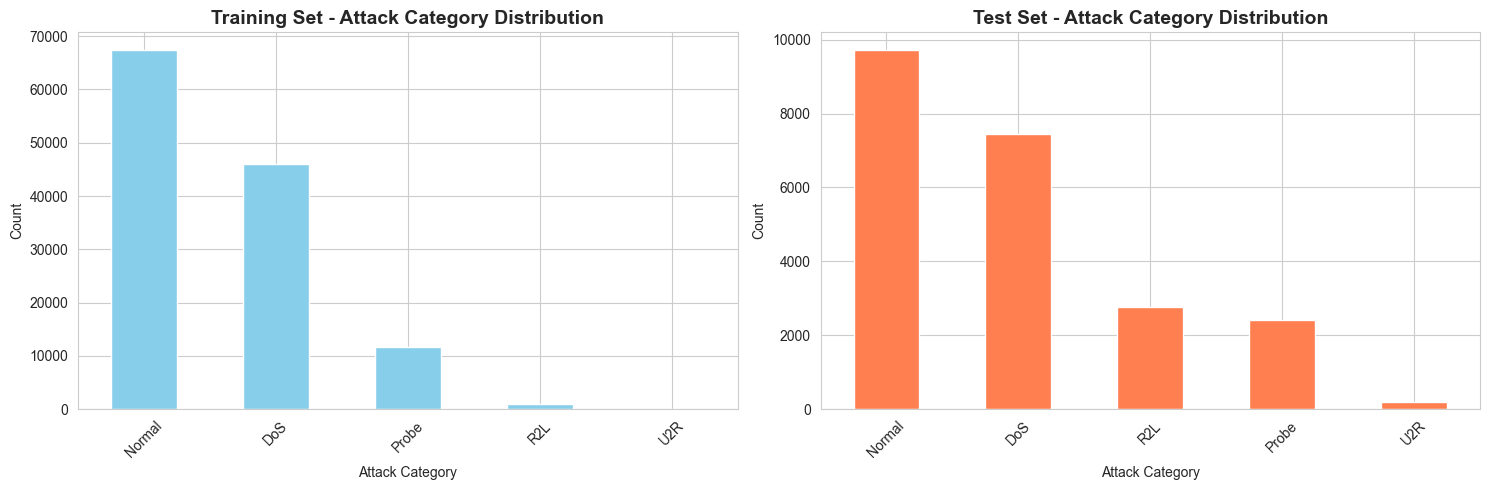


⚠️ Note: Class imbalance detected! U2R and R2L are minority classes.
This will need to be addressed in Week 4 with SMOTE or class weighting.


In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
train_df['attack_category'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set - Attack Category Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Attack Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test set
test_df['attack_category'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Test Set - Attack Category Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Attack Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Class imbalance detected! U2R and R2L are minority classes.")


# 🧹 4. Data Cleaning and Validation


In [14]:
print(f"Number of duplicated rows: {train_df.duplicated().sum()}")

Number of duplicated rows: 0


In [15]:
# Check for missing values
print("\nMissing Values:")
missing = train_df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found!")
else:
    print(missing[missing > 0])


Missing Values:
No missing values found!


In [16]:
# Check object datatype unique categories
for col in train_df.select_dtypes(include=['object']): print(f"{col}: {train_df[col].unique()}")

protocol_type: ['tcp' 'udp' 'icmp']
service: ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']
flag: ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
attack_type: ['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']
attack_category:

## 4.1 Drop Redundant Columns

Removing columns that are not needed for modeling:
- `attack_type`: Redundant - already mapped to `attack_category`
- `difficulty_level`: Metadata, not a real network feature

In [17]:
# Drop redundant columns
print("Dropping non-network features...")
print(f"Before: {train_df.shape}, {test_df.shape}")

train_df = train_df.drop(['attack_type', 'difficulty_level'], axis=1)
test_df = test_df.drop(['attack_type', 'difficulty_level'], axis=1)

print(f"After:  {train_df.shape}, {test_df.shape}")
print("\nColumns dropped successfully!")

Dropping non-network features...
Before: (125973, 44), (22544, 44)
After:  (125973, 42), (22544, 42)

Columns dropped successfully!


## 4.2 Check Near-Constant Features

Features with very low variance may not contribute to model performance and can be dropped to reduce dimensionality.

In [18]:
# Systematic check for near-constant features
print("Checking all features for near-constant behavior:")
print("=" * 60)

# Check numeric features
near_constant = []
for col in train_df.select_dtypes(include=['int64', 'float64']).columns:
    if col == 'attack_category':  # Skip target
        continue
    
    # Calculate what % of values are the most common value
    value_counts = train_df[col].value_counts(normalize=True)
    most_common_pct = value_counts.iloc[0] * 100
    
    # Flag if >99% are same value (very low variance)
    if most_common_pct > 99:
        variance = train_df[col].var()
        near_constant.append({
            'feature': col,
            'most_common_pct': most_common_pct,
            'variance': variance,
            'unique_values': train_df[col].nunique()
        })

# Display results
if near_constant:
    print(f"\nFound {len(near_constant)} near-constant features (>99% same value):\n")
    for item in near_constant:
        print(f"{item['feature']}:")
        print(f"  Most common value: {item['most_common_pct']:.2f}%")
        print(f"  Unique values: {item['unique_values']}")
        print(f"  Variance: {item['variance']:.6f}")
        print()
else:
    print("\nNo near-constant features found.")

Checking all features for near-constant behavior:

Found 13 near-constant features (>99% same value):

land:
  Most common value: 99.98%
  Unique values: 2
  Variance: 0.000198

wrong_fragment:
  Most common value: 99.13%
  Unique values: 3
  Variance: 0.064277

urgent:
  Most common value: 99.99%
  Unique values: 4
  Variance: 0.000206

num_failed_logins:
  Most common value: 99.90%
  Unique values: 6
  Variance: 0.002047

root_shell:
  Most common value: 99.87%
  Unique values: 2
  Variance: 0.001340

su_attempted:
  Most common value: 99.94%
  Unique values: 3
  Variance: 0.002039

num_root:
  Most common value: 99.48%
  Unique values: 82
  Variance: 595.341363

num_file_creations:
  Most common value: 99.77%
  Unique values: 35
  Variance: 0.234193

num_shells:
  Most common value: 99.96%
  Unique values: 3
  Variance: 0.000492

num_access_files:
  Most common value: 99.71%
  Unique values: 10
  Variance: 0.009874

num_outbound_cmds:
  Most common value: 100.00%
  Unique values: 1


In [19]:
# Categorize near-constant features by usefulness
print("\n" + "="*60)
print("DECISION FRAMEWORK:")
print("="*60)

# Absolutely useless (100% same value OR zero variance)
drop_immediately = []
for item in near_constant:
    if item['variance'] == 0 or item['most_common_pct'] == 100:
        drop_immediately.append(item['feature'])

print(f"\n1. DROP IMMEDIATELY (100% same value or zero variance):")
print(f"   {drop_immediately}")

# Likely useless but check attack correlation first
check_correlation = []
for item in near_constant:
    if item['feature'] not in drop_immediately and item['most_common_pct'] > 99.9:
        check_correlation.append(item['feature'])
        
print(f"\n2. CHECK CORRELATION WITH ATTACKS (>99.9% but might signal rare attacks):")
print(f"   {check_correlation}")

# Keep for now (might be useful for rare attack detection)
keep_for_now = []
for item in near_constant:
    if item['feature'] not in drop_immediately and item['feature'] not in check_correlation:
        keep_for_now.append(item['feature'])

print(f"\n3. KEEP FOR NOW (>99% but below 99.9%, might help with rare attacks):")
print(f"   {keep_for_now}")


DECISION FRAMEWORK:

1. DROP IMMEDIATELY (100% same value or zero variance):
   ['num_outbound_cmds']

2. CHECK CORRELATION WITH ATTACKS (>99.9% but might signal rare attacks):
   ['land', 'urgent', 'num_failed_logins', 'su_attempted', 'num_shells', 'is_host_login']

3. KEEP FOR NOW (>99% but below 99.9%, might help with rare attacks):
   ['wrong_fragment', 'root_shell', 'num_root', 'num_file_creations', 'num_access_files', 'is_guest_login']


In [20]:
# Check if near-constant features correlate with attack types
check_features = ['land', 'urgent', 'num_failed_logins', 'su_attempted', 'num_shells', 'is_host_login']

print("\nChecking correlation with attack categories:")
print("="*60)

for feature in check_features:
    print(f"\n{feature}:")
    # Cross-tabulation with attack category
    crosstab = pd.crosstab(train_df['attack_category'], train_df[feature], margins=True)
    
    # Show only non-zero columns to see if feature discriminates
    non_zero_cols = crosstab.columns[crosstab.sum() > 0]
    print(crosstab[non_zero_cols])
    
    # Calculate % of each attack type with non-zero value
    for attack in ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']:
        attack_data = train_df[train_df['attack_category'] == attack]
        non_zero_pct = (attack_data[feature] != 0).sum() / len(attack_data) * 100
        if non_zero_pct > 0:
            print(f"  {attack}: {non_zero_pct:.2f}% have non-zero {feature}")


Checking correlation with attack categories:

land:
land                  0   1     All
attack_category                    
DoS               45909  18   45927
Normal            67336   7   67343
Probe             11656   0   11656
R2L                 995   0     995
U2R                  52   0      52
All              125948  25  125973
  Normal: 0.01% have non-zero land
  DoS: 0.04% have non-zero land

urgent:
urgent                0  1  2  3     All
attack_category                         
DoS               45927  0  0  0   45927
Normal            67337  3  2  1   67343
Probe             11656  0  0  0   11656
R2L                 993  1  1  0     995
U2R                  51  1  0  0      52
All              125964  5  3  1  125973
  Normal: 0.01% have non-zero urgent
  R2L: 0.20% have non-zero urgent
  U2R: 1.92% have non-zero urgent

num_failed_logins:
num_failed_logins       0    1  2  3  4  5     All
attack_category                                   
DoS                 45927   

In [21]:
# Final decision on near-constant features
print("\n" + "="*60)
print("FINAL DECISION:")
print("="*60)

# Drop these - truly useless
drop_features = ['num_outbound_cmds', 'is_host_login', 'land', 'su_attempted']

print(f"\nDROPPING ({len(drop_features)} features):")
for f in drop_features:
    print(f"  - {f}")

# Keep these - signal rare attacks
keep_features = ['urgent', 'num_failed_logins', 'num_shells']
print(f"\nKEEPING (signal rare attacks):")
for f in keep_features:
    print(f"  - {f}")

# Drop the useless features
train_df = train_df.drop(drop_features, axis=1)
test_df = test_df.drop(drop_features, axis=1)

print(f"\nNew shape: {train_df.shape}, {test_df.shape}")


FINAL DECISION:

DROPPING (4 features):
  - num_outbound_cmds
  - is_host_login
  - land
  - su_attempted

KEEPING (signal rare attacks):
  - urgent
  - num_failed_logins
  - num_shells

New shape: (125973, 38), (22544, 38)


## 4.3 Check Counter Limits

Network monitoring tools often use fixed-size counters with maximum values (e.g., 255 for 8-bit, 511 for 9-bit). If many records hit these caps, the true values are censored (artificially limited).

In [22]:
# Systematically check ALL numeric features for counter limits
print("Checking ALL numeric features for potential counter limits:")
print("="*60)

# Common counter limits
common_limits = [
    (255, "8-bit: 2^8-1"),
    (511, "9-bit: 2^9-1"),
    (1023, "10-bit: 2^10-1"),
    (65535, "16-bit: 2^16-1"),
    (100, "round number"),
    (1000, "round number"),
    (10000, "round number")
]

features_at_limits = []

for col in train_df.select_dtypes(include=['int64', 'float64']).columns:
    if col == 'attack_category':
        continue
    
    max_val = train_df[col].max()
    
    # Check if max value matches any known counter limit
    for limit, description in common_limits:
        if max_val == limit:
            at_limit = (train_df[col] == limit).sum()
            pct_at_limit = (at_limit / len(train_df)) * 100
            
            features_at_limits.append({
                'feature': col,
                'limit': limit,
                'description': description,
                'count_at_limit': at_limit,
                'pct_at_limit': pct_at_limit
            })
            break

# Display findings
if features_at_limits:
    print(f"\nFound {len(features_at_limits)} features hitting potential counter limits:\n")
    for item in features_at_limits:
        print(f"{item['feature']}:")
        print(f"  Limit: {item['limit']} ({item['description']})")
        print(f"  Records at cap: {item['count_at_limit']:,} ({item['pct_at_limit']:.2f}%)")
        print()
else:
    print("\nNo features hitting known counter limits.")

Checking ALL numeric features for potential counter limits:

Found 4 features hitting potential counter limits:

count:
  Limit: 511 (9-bit: 2^9-1)
  Records at cap: 1,437 (1.14%)

srv_count:
  Limit: 511 (9-bit: 2^9-1)
  Records at cap: 1,012 (0.80%)

dst_host_count:
  Limit: 255 (8-bit: 2^8-1)
  Records at cap: 74,099 (58.82%)

dst_host_srv_count:
  Limit: 255 (8-bit: 2^8-1)
  Records at cap: 35,993 (28.57%)



In [23]:
# Decision on counter-limited features
print("\n" + "="*60)
print("DECISION ON COUNTER-LIMITED FEATURES:")
print("="*60)

print("\nKEEPING all counter-limited features because:")
print("- Even capped values (255, 511) are informative")
print("- High counts signal potential attacks (especially DoS)")
print("- Standard limitation in network monitoring datasets")

print("\n⚠️ LIMITATION TO NOTE:")
print("- dst_host_count: 58.82% of records censored at 255")
print("- dst_host_srv_count: 28.57% of records censored at 255")
print("- True values for these records are unknown (could be much higher)")
print("- Will mention this in report as data quality limitation")

print("\nNo features dropped due to counter limits.")


DECISION ON COUNTER-LIMITED FEATURES:

KEEPING all counter-limited features because:
- Even capped values (255, 511) are informative
- High counts signal potential attacks (especially DoS)
- Standard limitation in network monitoring datasets

⚠️ LIMITATION TO NOTE:
- dst_host_count: 58.82% of records censored at 255
- dst_host_srv_count: 28.57% of records censored at 255
- True values for these records are unknown (could be much higher)
- Will mention this in report as data quality limitation

No features dropped due to counter limits.


## 4.4 Logical Consistency Check

Checking for impossible or illogical values in the data:
- Negative values where they shouldn't exist
- Rate features outside valid range [0, 1]
- Impossible combinations

In [24]:
# Logical consistency checks
print("Logical Consistency Checks:")
print("="*60)

issues_found = []

# 1. Check for negative values in features that should be non-negative
non_negative_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']

print("\n1. Checking for negative values in count/size features:")
for col in non_negative_features:
    negative_count = (train_df[col] < 0).sum()
    if negative_count > 0:
        print(f"   ⚠️ {col}: {negative_count} negative values found")
        issues_found.append(f"{col} has negative values")
    else:
        print(f"   ✅ {col}: No negative values")

# 2. Check rate features are in valid range [0, 1]
rate_features = [col for col in train_df.columns if 'rate' in col.lower()]

print(f"\n2. Checking rate features are in valid range [0, 1]:")
for col in rate_features:
    out_of_range = ((train_df[col] < 0) | (train_df[col] > 1)).sum()
    if out_of_range > 0:
        print(f"   ⚠️ {col}: {out_of_range} values outside [0,1]")
        issues_found.append(f"{col} has invalid rates")
    else:
        print(f"   ✅ {col}: All values in [0,1]")

# 3. Check binary features only have 0 or 1
binary_features = ['logged_in', 'root_shell', 'is_guest_login']

print(f"\n3. Checking binary features only contain 0 or 1:")
for col in binary_features:
    unique_vals = train_df[col].unique()
    invalid_vals = [v for v in unique_vals if v not in [0, 1]]
    if invalid_vals:
        print(f"   ⚠️ {col}: Invalid values found: {invalid_vals}")
        issues_found.append(f"{col} has non-binary values")
    else:
        print(f"   ✅ {col}: Only 0 and 1")

# Summary
print("\n" + "="*60)
if issues_found:
    print(f"⚠️ ISSUES FOUND: {len(issues_found)}")
    for issue in issues_found:
        print(f"   - {issue}")
else:
    print("✅ NO LOGICAL INCONSISTENCIES FOUND")
    print("Data passes all consistency checks!")

Logical Consistency Checks:

1. Checking for negative values in count/size features:
   ✅ duration: No negative values
   ✅ src_bytes: No negative values
   ✅ dst_bytes: No negative values
   ✅ count: No negative values
   ✅ srv_count: No negative values

2. Checking rate features are in valid range [0, 1]:
   ✅ serror_rate: All values in [0,1]
   ✅ srv_serror_rate: All values in [0,1]
   ✅ rerror_rate: All values in [0,1]
   ✅ srv_rerror_rate: All values in [0,1]
   ✅ same_srv_rate: All values in [0,1]
   ✅ diff_srv_rate: All values in [0,1]
   ✅ srv_diff_host_rate: All values in [0,1]
   ✅ dst_host_same_srv_rate: All values in [0,1]
   ✅ dst_host_diff_srv_rate: All values in [0,1]
   ✅ dst_host_same_src_port_rate: All values in [0,1]
   ✅ dst_host_srv_diff_host_rate: All values in [0,1]
   ✅ dst_host_serror_rate: All values in [0,1]
   ✅ dst_host_srv_serror_rate: All values in [0,1]
   ✅ dst_host_rerror_rate: All values in [0,1]
   ✅ dst_host_srv_rerror_rate: All values in [0,1]

3. 

## 4.5 Data Cleaning Summary

**Actions completed:**

1. **Dropped redundant columns (2):**
   - `attack_type` - redundant with `attack_category`
   - `difficulty_level` - metadata, not network feature

2. **Dropped near-constant features (4):**
   - `num_outbound_cmds` - 100% same value (zero variance)
   - `is_host_login` - only 1 non-zero record
   - `land` - only 25 non-zero records (0.02%)
   - `su_attempted` - no discrimination between attack types

3. **Kept potentially useful rare-signal features:**
   - `num_shells` - 9.62% of U2R attacks
   - `num_failed_logins` - 5.23% of R2L attacks
   - `urgent` - 1.92% of U2R attacks

4. **Counter limit censoring identified (kept features):**
   - `dst_host_count` - 58.82% censored at 255
   - `dst_host_srv_count` - 28.57% censored at 255
   - Decision: Kept despite censoring (still provides signal)

5. **Logical consistency validated:**
   - ✅ No negative values in count/size features
   - ✅ All rate features in valid range [0, 1]
   - ✅ All binary features contain only 0 or 1

**Final dataset shape:**
- Training: 125,973 rows × 37 features (+ attack_category target)
- Test: 22,544 rows × 37 features (+ attack_category target)
- Dropped: 6 features total
- Kept: 37 features for modeling

**Data quality notes for report:**
- Severe class imbalance (U2R: 52, R2L: 995)
- Counter limit censoring affects dst_host features
- Data

In [ ]:
# Final dataset summary
print("="*60)
print("DATA CLEANING COMPLETE")
print("="*60)
print(f"\nFinal Training Shape: {train_df.shape}")
print(f"Final Test Shape: {test_df.shape}")
print(f"\nFeatures: {train_df.shape[1] - 1} (excluding attack_category)")
print(f"Target: attack_category (5 classes)")


DATA CLEANING COMPLETE

Final Training Shape: (125973, 38)
Final Test Shape: (22544, 38)

Features: 37 (excluding attack_category)
Target: attack_category (5 classes)

Ready for Feature Engineering (Week 2)!


In [26]:
# Detailed analysis of 'service' feature (high cardinality)
print("="*60)
print("SERVICE FEATURE ANALYSIS")
print("="*60)
print(f"\nTotal unique services: {train_df['service'].nunique()}")
print("\nService distribution:")
print(train_df['service'].value_counts())
print(f"\nServices with <100 records:")
rare_services = train_df['service'].value_counts()[train_df['service'].value_counts() < 100]
print(rare_services)
print(f"\nNumber of rare services (<100 records): {len(rare_services)}")

SERVICE FEATURE ANALYSIS

Total unique services: 70

Service distribution:
service
http           40338
private        21853
domain_u        9043
smtp            7313
ftp_data        6860
eco_i           4586
other           4359
ecr_i           3077
telnet          2353
finger          1767
ftp             1754
auth             955
Z39_50           862
uucp             780
courier          734
bgp              710
whois            693
uucp_path        689
iso_tsap         687
time             654
imap4            647
nnsp             630
vmnet            617
urp_i            602
domain           569
ctf              563
csnet_ns         545
supdup           544
discard          538
http_443         530
daytime          521
gopher           518
efs              485
systat           477
link             475
exec             474
hostnames        460
name             451
mtp              439
echo             434
klogin           433
login            429
ldap             410
netbios_dgm   

## Categorical Features - Analysis & Action Plan

### Overview

**protocol_type (3 values):** tcp, udp, icmp
- Small cardinality - straightforward one-hot encoding

**flag (11 values):** SF, S0, REJ, RSTR, etc. (connection state flags)
- Moderate cardinality - one-hot encoding fine

**attack_type (23 values):**
- Already mapped to attack_category (5 values)
- **Action:** Drop this column - redundant with attack_category

**attack_category (5 values):** Normal, DoS, Probe, R2L, U2R
- **Our target variable for classification**

---

### Service Feature - Detailed Analysis

**Current state:**
- 70 unique services (high cardinality!)
- Heavily imbalanced: top service (http) has 40,338 records, bottom (http_2784) has 1
- 15 rare services with <100 records (~500 records combined)

**Options for Week 2:**
1. **Group rare services:** Combine 15 rare services into 'other' category → reduces to ~56 values
2. **Target encoding:** Encode based on attack rate per service (handles high cardinality better)
3. **Keep top N:** Only one-hot encode top 20-30 services, group rest as 'other'

**Decision pending further analysis in Week 2**

# 5. Feature Engineering

In [28]:
# Service Feature - Deep Dive Analysis

print("="*60)
print("SERVICE FEATURE - DETAILED ANALYSIS")
print("="*60)

# 1. Service by attack category
print("\n1. SERVICE DISTRIBUTION BY ATTACK CATEGORY")
print("-"*60)
service_attack = pd.crosstab(train_df['service'], train_df['attack_category'])
print(service_attack.head(20))

# More useful than showing all 70 rows
print(f"Total services: {len(service_attack)}")
print(f"\nServices by dominant attack type:")
print(service_attack.idxmax(axis=1).value_counts())

# 2. Attack rate per service (useful for target encoding)
print("\n2. ATTACK RATE PER SERVICE")
print("-"*60)
service_attack_rate = train_df.groupby('service')['attack_category'].apply(
    lambda x: (x != 'Normal').sum() / len(x) * 100
).sort_values(ascending=False)

print("\nMost malicious (highest attack rate):")
print(service_attack_rate.head(10))

print("\nMost benign (lowest attack rate):")
print(service_attack_rate.tail(10))

print(f"\nAttack rate range: {service_attack_rate.min():.1f}% to {service_attack_rate.max():.1f}%")
print(f"Mean attack rate: {service_attack_rate.mean():.1f}%")

# 3. Cumulative coverage
print("\n3. CUMULATIVE COVERAGE ANALYSIS")
print("-"*60)
service_counts = train_df['service'].value_counts()
cumsum = service_counts.cumsum() / len(train_df) * 100

for n in [5, 10, 20, 30, 40, 50]:
    coverage = cumsum.iloc[n-1] if n <= len(cumsum) else 100
    print(f"Top {n:2d} services cover: {coverage:.2f}% of data")

# 4. Test set coverage
print("\n4. TEST SET SERVICE OVERLAP")
print("-"*60)
train_services = set(train_df['service'].unique())
test_services = set(test_df['service'].unique())

services_only_in_test = test_services - train_services
services_only_in_train = train_services - test_services

print(f"Services in train: {len(train_services)}")
print(f"Services in test: {len(test_services)}")
print(f"Services only in test: {len(services_only_in_test)}")
if services_only_in_test:
    print(f"  {services_only_in_test}")
print(f"Services only in train: {len(services_only_in_train)}")
if services_only_in_train:
    print(f"  {services_only_in_train}")

# 5. Rare services detail
print("\n5. RARE SERVICES (<100 records) - ATTACK BREAKDOWN")
print("-"*60)
rare_threshold = 100
rare_services = train_df['service'].value_counts()[train_df['service'].value_counts() < rare_threshold].index

for service in rare_services[:10]:  # Show first 10
    service_data = train_df[train_df['service'] == service]
    attack_dist = service_data['attack_category'].value_counts()
    print(f"\n{service} (n={len(service_data)}):")
    print(f"  {attack_dist.to_dict()}")

SERVICE FEATURE - DETAILED ANALYSIS

1. SERVICE DISTRIBUTION BY ATTACK CATEGORY
------------------------------------------------------------
attack_category   DoS  Normal  Probe  R2L  U2R
service                                       
IRC                 0     186      1    0    0
X11                 0      67      6    0    0
Z39_50            851       0     11    0    0
aol                 0       0      2    0    0
auth              703     236     16    0    0
bgp               699       0     11    0    0
courier           726       0      8    0    0
csnet_ns          533       0     12    0    0
ctf               538       0     25    0    0
daytime           503       0     18    0    0
discard           520       0     18    0    0
domain            508      38     23    0    0
domain_u            0    9034      9    0    0
echo              416       0     18    0    0
eco_i               0     497   4089    0    0
ecr_i            2844     190     43    0    0
efs          

## Service Feature - Encoding Decision

**Analysis Summary:**
- 70 unique services with extreme variance in attack rates (0% to 100%)
- Top 10 services cover 80% of data, but remaining 60 services still contain meaningful signal
- Rare services show distinct patterns (e.g., urh_i 100% benign vs pm_dump 100% attack)
- No unseen services in test set ✅

**Encoding Options Considered:**
1. **One-hot encoding:** Creates 70 columns, loses attack rate information
2. **Group rare + one-hot top N:** Loses information for 13% of data, treats all rare services equally
3. **Target encoding:** Captures attack rate directly, handles all 70 services in 1 column

**Decision: Target Encoding**

**Rationale:**
- Preserves the 0-100% attack rate variance (highly predictive)
- Handles high cardinality efficiently (70 classes → 1 feature)
- Maintains signal from rare services without grouping
- Creates meaningful numerical feature: "historical maliciousness of this service"

**Implementation approach:**
- Encode based on attack rate per service in training set
- Apply same mapping to test set (no data leakage)

In [29]:
# ============================================================
# SERVICE FEATURE - TARGET ENCODING (SMOOTHED)
# ============================================================

# 1. Create binary target for encoding
train_df['is_attack'] = (train_df['attack_category'] != 'Normal').astype(int)
test_df['is_attack'] = (test_df['attack_category'] != 'Normal').astype(int)

# 2. Calculate global attack rate (prior)
global_attack_rate = train_df['is_attack'].mean()
print(f"Global attack rate: {global_attack_rate:.4f} ({global_attack_rate*100:.2f}%)")

# 3. Smoothed target encoding
# Formula: (n * category_mean + m * global_mean) / (n + m)
m = 100  # Smoothing parameter - higher = more conservative

service_stats = train_df.groupby('service').agg({
    'is_attack': ['sum', 'count', 'mean']
})
service_stats.columns = ['attack_count', 'total_count', 'attack_rate']

# Apply smoothing
service_stats['smoothed_attack_rate'] = (
    (service_stats['total_count'] * service_stats['attack_rate'] + 
     m * global_attack_rate) / 
    (service_stats['total_count'] + m)
)

print(f"\nSmoothing parameter (m): {m}")
print("\nEffect of smoothing on rare vs common services:")
print("-" * 80)
print(f"{'Service':<15} {'Count':<8} {'Raw Rate':<12} {'Smoothed Rate':<15} {'Difference'}")
print("-" * 80)

# Show examples: rare services and common services
examples = ['pm_dump', 'urh_i', 'http', 'private', 'domain_u']
for svc in examples:
    if svc in service_stats.index:
        row = service_stats.loc[svc]
        diff = row['smoothed_attack_rate'] - row['attack_rate']
        print(f"{svc:<15} {row['total_count']:<8.0f} {row['attack_rate']:<12.4f} "
              f"{row['smoothed_attack_rate']:<15.4f} {diff:+.4f}")

# 4. Create encoding map
service_encoding_map = service_stats['smoothed_attack_rate'].to_dict()

# 5. Apply encoding to train and test
train_df['service_encoded'] = train_df['service'].map(service_encoding_map)
test_df['service_encoded'] = test_df['service'].map(service_encoding_map)

# 6. Handle unseen services in test (shouldn't be any, but just in case)
train_df['service_encoded'].fillna(global_attack_rate, inplace=True)
test_df['service_encoded'].fillna(global_attack_rate, inplace=True)

# 7. Drop temporary binary target column
train_df.drop('is_attack', axis=1, inplace=True)
test_df.drop('is_attack', axis=1, inplace=True)

print("\n" + "=" * 80)
print("SERVICE ENCODING COMPLETE")
print("=" * 80)
print(f"service (70 categories) → service_encoded (continuous 0-1)")
print(f"Encoding range: [{train_df['service_encoded'].min():.4f}, {train_df['service_encoded'].max():.4f}]")
print(f"\nMissing values in train: {train_df['service_encoded'].isna().sum()}")
print(f"Missing values in test: {test_df['service_encoded'].isna().sum()}")

Global attack rate: 0.4654 (46.54%)

Smoothing parameter (m): 100

Effect of smoothing on rare vs common services:
--------------------------------------------------------------------------------
Service         Count    Raw Rate     Smoothed Rate   Difference
--------------------------------------------------------------------------------
pm_dump         5        1.0000       0.4909          -0.5091
urh_i           10       0.0000       0.4231          +0.4231
http            40338    0.0567       0.0578          +0.0010
private         21853    0.9551       0.9528          -0.0022
domain_u        9043     0.0010       0.0061          +0.0051

SERVICE ENCODING COMPLETE
service (70 categories) → service_encoded (continuous 0-1)
Encoding range: [0.0061, 0.9528]

Missing values in train: 0
Missing values in test: 0


In [30]:
# ============================================================
# INVESTIGATE SERVICE USAGE BY ATTACK CATEGORY
# Focus on R2L and U2R (minority classes)
# ============================================================

print("=" * 80)
print("SERVICE ANALYSIS FOR MINORITY ATTACK CLASSES")
print("=" * 80)

# 1. Which services do R2L and U2R attacks use?
print("\n" + "=" * 80)
print("SERVICES USED BY R2L ATTACKS")
print("=" * 80)

r2l_services = train_df[train_df['attack_category'] == 'R2L']['service'].value_counts()
print(f"\nR2L attacks use {len(r2l_services)} different services")
print(f"Total R2L records: {(train_df['attack_category'] == 'R2L').sum()}")
print("\nTop 10 services used by R2L:")
print(r2l_services.head(10))

print("\n" + "=" * 80)
print("SERVICES USED BY U2R ATTACKS")
print("=" * 80)

u2r_services = train_df[train_df['attack_category'] == 'U2R']['service'].value_counts()
print(f"\nU2R attacks use {len(u2r_services)} different services")
print(f"Total U2R records: {(train_df['attack_category'] == 'U2R').sum()}")
print("\nAll services used by U2R:")
print(u2r_services)

# 2. For each service used by R2L/U2R, check if it's rare and how smoothing affected it
print("\n" + "=" * 80)
print("SMOOTHING IMPACT ON R2L-ASSOCIATED SERVICES")
print("=" * 80)

r2l_service_analysis = []
for svc in r2l_services.index:
    if svc in service_stats.index:
        stats = service_stats.loc[svc]
        r2l_count = len(train_df[(train_df['service'] == svc) & (train_df['attack_category'] == 'R2L')])
        r2l_pct = (r2l_count / stats['total_count']) * 100
        
        r2l_service_analysis.append({
            'service': svc,
            'total_count': stats['total_count'],
            'r2l_count': r2l_count,
            'r2l_percentage': r2l_pct,
            'raw_attack_rate': stats['attack_rate'],
            'smoothed_rate': stats['smoothed_attack_rate'],
            'signal_loss': stats['attack_rate'] - stats['smoothed_attack_rate']
        })

r2l_df = pd.DataFrame(r2l_service_analysis).sort_values('r2l_count', ascending=False)
print("\nServices ranked by R2L usage:")
print(r2l_df.to_string(index=False))

print("\n" + "=" * 80)
print("SMOOTHING IMPACT ON U2R-ASSOCIATED SERVICES")
print("=" * 80)

u2r_service_analysis = []
for svc in u2r_services.index:
    if svc in service_stats.index:
        stats = service_stats.loc[svc]
        u2r_count = len(train_df[(train_df['service'] == svc) & (train_df['attack_category'] == 'U2R')])
        u2r_pct = (u2r_count / stats['total_count']) * 100
        
        u2r_service_analysis.append({
            'service': svc,
            'total_count': stats['total_count'],
            'u2r_count': u2r_count,
            'u2r_percentage': u2r_pct,
            'raw_attack_rate': stats['attack_rate'],
            'smoothed_rate': stats['smoothed_attack_rate'],
            'signal_loss': stats['attack_rate'] - stats['smoothed_attack_rate']
        })

u2r_df = pd.DataFrame(u2r_service_analysis).sort_values('u2r_count', ascending=False)
print("\nServices ranked by U2R usage:")
print(u2r_df.to_string(index=False))

# 3. Summary assessment
print("\n" + "=" * 80)
print("SUMMARY ASSESSMENT")
print("=" * 80)

print("\nR2L Attacks:")
rare_r2l = r2l_df[r2l_df['total_count'] < 100]
print(f"  - Use {len(r2l_df)} different services")
print(f"  - {len(rare_r2l)} services are rare (< 100 total occurrences)")
print(f"  - Top service: {r2l_df.iloc[0]['service']} ({r2l_df.iloc[0]['r2l_count']:.0f} R2L attacks)")
print(f"  - Average signal loss from smoothing: {r2l_df['signal_loss'].mean():.4f}")

print("\nU2R Attacks:")
rare_u2r = u2r_df[u2r_df['total_count'] < 100]
print(f"  - Use {len(u2r_df)} different services")
print(f"  - {len(rare_u2r)} services are rare (< 100 total occurrences)")
print(f"  - Top service: {u2r_df.iloc[0]['service']} ({u2r_df.iloc[0]['u2r_count']:.0f} U2R attacks)")
print(f"  - Average signal loss from smoothing: {u2r_df['signal_loss'].mean():.4f}")

print("\n" + "=" * 80)

SERVICE ANALYSIS FOR MINORITY ATTACK CLASSES

SERVICES USED BY R2L ATTACKS

R2L attacks use 7 different services
Total R2L records: 995

Top 10 services used by R2L:
service
ftp_data    604
ftp         312
telnet       57
imap4        11
other         5
http          4
login         2
Name: count, dtype: int64

SERVICES USED BY U2R ATTACKS

U2R attacks use 4 different services
Total U2R records: 52

All services used by U2R:
service
telnet      34
ftp_data    12
ftp          3
other        3
Name: count, dtype: int64

SMOOTHING IMPACT ON R2L-ASSOCIATED SERVICES

Services ranked by R2L usage:
 service  total_count  r2l_count  r2l_percentage  raw_attack_rate  smoothed_rate  signal_loss
ftp_data       6860.0        604        8.804665         0.273469       0.276227    -0.002758
     ftp       1754.0        312       17.787913         0.476625       0.476020     0.000605
  telnet       2353.0         57        2.422439         0.610285       0.604379     0.005906
   imap4        647.0    

In [31]:
# One-hot encode protocol_type and flag
train_encoded = pd.get_dummies(train_df, columns=['protocol_type', 'flag'], 
                                drop_first=True, dtype=int)
test_encoded = pd.get_dummies(test_df, columns=['protocol_type', 'flag'], 
                               drop_first=True, dtype=int)

In [32]:
# Encode target variable
le = LabelEncoder()
train_df['attack_category_encoded'] = le.fit_transform(train_df['attack_category'])
test_df['attack_category_encoded'] = le.transform(test_df['attack_category'])

# Show mapping
print("Target encoding mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {label} → {i}")

# Keep original for interpretability
# Use attack_category_encoded as y for modeling

Target encoding mapping:
  DoS → 0
  Normal → 1
  Probe → 2
  R2L → 3
  U2R → 4


In [33]:
# ============================================================
# OUTLIER DETECTION
# ============================================================

# Get numerical features (exclude encoded categoricals and target)
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_features = [col for col in numerical_features 
                     if col not in ['attack_category_encoded', 'service_encoded',
                                   'difficulty_level'] and not col.startswith('protocol_') 
                     and not col.startswith('flag_')]

print(f"Checking {len(numerical_features)} numerical features for outliers")
print("=" * 80)

# IQR method for outlier detection
outlier_summary = []

for col in numerical_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((train_df[col] < lower_bound) | (train_df[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(train_df)) * 100
    
    if outliers > 0:
        outlier_summary.append({
            'feature': col,
            'outliers': outliers,
            'pct': outlier_pct,
            'min': train_df[col].min(),
            'max': train_df[col].max(),
            'Q1': Q1,
            'Q3': Q3,
            'upper_bound': upper_bound
        })

# Sort by percentage
outlier_df = pd.DataFrame(outlier_summary).sort_values('pct', ascending=False)

print("\nFeatures with outliers (sorted by % affected):")
print("-" * 80)
print(outlier_df.to_string(index=False))

print(f"\n\nFeatures with outliers: {len(outlier_df)} out of {len(numerical_features)}")
print(f"Features with >10% outliers: {(outlier_df['pct'] > 10).sum()}")

Checking 34 numerical features for outliers

Features with outliers (sorted by % affected):
--------------------------------------------------------------------------------
                    feature  outliers       pct  min          max  Q1     Q3  upper_bound
         srv_diff_host_rate     28399 22.543720  0.0          1.0 0.0   0.00        0.000
dst_host_same_src_port_rate     25052 19.886801  0.0          1.0 0.0   0.06        0.150
                  dst_bytes     23579 18.717503  0.0 1309937401.0 0.0 516.00     1290.000
       dst_host_rerror_rate     22795 18.095147  0.0          1.0 0.0   0.00        0.000
   dst_host_srv_rerror_rate     19357 15.365991  0.0          1.0 0.0   0.00        0.000
            srv_rerror_rate     16206 12.864661  0.0          1.0 0.0   0.00        0.000
                rerror_rate     16190 12.851960  0.0          1.0 0.0   0.00        0.000
                  src_bytes     13840 10.986481  0.0 1379963888.0 0.0 276.00      690.000
                 

In [34]:
# ============================================================
# OUTLIER HANDLING DECISION
# ============================================================

print("\nOUTLIER HANDLING STRATEGY")
print("=" * 80)
print("Decision: Use RobustScaler instead of removing outliers")
print("\nRationale:")
print("- In intrusion detection, extreme values often represent attacks")
print("- Removing outliers would remove the attacks we want to detect")
print("- RobustScaler uses median and IQR, resistant to outliers")
print("- Preserves all data while normalizing scale")
print("\nFeatures requiring scaling:")
print("- Numerical features (src_bytes, dst_bytes, duration, counts, etc.)")
print("- Rate features (0-1) will be left unscaled")
print("- One-hot encoded features will be left unscaled")


OUTLIER HANDLING STRATEGY
Decision: Use RobustScaler instead of removing outliers

Rationale:
- In intrusion detection, extreme values often represent attacks
- Removing outliers would remove the attacks we want to detect
- RobustScaler uses median and IQR, resistant to outliers
- Preserves all data while normalizing scale

Features requiring scaling:
- Numerical features (src_bytes, dst_bytes, duration, counts, etc.)
- Rate features (0-1) will be left unscaled
- One-hot encoded features will be left unscaled


In [ ]:
# ============================================================
# FEATURE SCALING
# ============================================================

print("FEATURE SCALING - RobustScaler")
print("=" * 80)

# 1. Identify features to scale
# Exclude: rate features (0-1), one-hot encoded, target, service_encoded
rate_features = [col for col in train_encoded.columns if 'rate' in col.lower()]
onehot_features = [col for col in train_encoded.columns 
                   if col.startswith('protocol_') or col.startswith('flag_')]
exclude_features = rate_features + onehot_features + [
    'attack_category', 'attack_category_encoded', 
    'service', 'service_encoded'
]

# Get numerical features to scale
numerical_to_scale = [col for col in train_encoded.select_dtypes(include=['int64', 'float64']).columns
                      if col not in exclude_features]

print(f"\nFeatures to scale: {len(numerical_to_scale)}")
print(f"Rate features (leave as-is): {len(rate_features)}")
print(f"One-hot encoded (leave as-is): {len(onehot_features)}")

print(f"\nFeatures being scaled:")
print(numerical_to_scale)

# 2. Fit scaler on training data only
scaler = RobustScaler()
train_encoded[numerical_to_scale] = scaler.fit_transform(train_encoded[numerical_to_scale])
test_encoded[numerical_to_scale] = scaler.transform(test_encoded[numerical_to_scale])

print("\n" + "=" * 80)
print("SCALING COMPLETE")
print("=" * 80)
print("✅ Numerical features scaled using RobustScaler (median & IQR)")
print("✅ Rate features preserved (already 0-1 scale)")
print("✅ One-hot encoded features preserved (binary 0/1)")
print("✅ Scaler fit on training data only (no data leakage)")

# 3. Final dataset check
print(f"\nFinal training shape: {train_encoded.shape}")
print(f"Final test shape: {test_encoded.shape}")


FEATURE SCALING - RobustScaler

Features to scale: 19
Rate features (leave as-is): 15
One-hot encoded (leave as-is): 12

Features being scaled:
['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_guest_login', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

SCALING COMPLETE
✅ Numerical features scaled using RobustScaler (median & IQR)
✅ Rate features preserved (already 0-1 scale)
✅ One-hot encoded features preserved (binary 0/1)
✅ Scaler fit on training data only (no data leakage)

Final training shape: (125973, 49)
Final test shape: (22544, 49)

Ready for EDA (Section 6)!


# 6. Exploratory Data Analysis (EDA)

## 6.1 Univariate Analysis

### Numerical Features

In [36]:
# ============================================================
# UNIVARIATE ANALYSIS - FEATURE SELECTION
# ============================================================

print("UNIVARIATE ANALYSIS - NUMERICAL FEATURES")
print("=" * 80)

# Add the label-encoded target to train_encoded
train_encoded['attack_category_encoded'] = train_df['attack_category_encoded']
test_encoded['attack_category_encoded'] = test_df['attack_category_encoded']

print("✓ Added attack_category_encoded to train_encoded and test_encoded")

# 1. Select numerical features to analyze
# Exclude: encoded categoricals, target, original service column
numerical_cols = train_encoded.select_dtypes(include=['int64', 'float64']).columns
exclude = ['attack_category_encoded', 'service_encoded'] + \
          [col for col in numerical_cols if col.startswith('protocol_') or col.startswith('flag_')]

numerical_features = [col for col in numerical_cols if col not in exclude]

print(f"\nTotal numerical features available: {len(numerical_features)}")

# 2. Calculate ANOVA F-statistic for each feature vs attack category
# This measures how well each feature discriminates between attack types
X_numerical = train_encoded[numerical_features]
y = train_encoded['attack_category_encoded']

f_stats, p_values = f_classif(X_numerical, y)

# Create dataframe of results
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'f_statistic': f_stats,
    'p_value': p_values
}).sort_values('f_statistic', ascending=False)

print("\n" + "=" * 80)
print("TOP 20 FEATURES BY DISCRIMINATIVE POWER (ANOVA F-statistic)")
print("=" * 80)
print(feature_importance.head(20).to_string(index=False))

# 3. Select top 15 for visualization
top_features = feature_importance.head(15)['feature'].tolist()

print(f"\n\nSelected {len(top_features)} features for univariate visualization:")
for i, feat in enumerate(top_features, 1):
    print(f"{i:2d}. {feat}")

# 4. Also note features with interesting distributions (domain relevance)
print("\n" + "=" * 80)
print("FEATURE SELECTION RATIONALE")
print("=" * 80)
print("\nFeatures selected based on:")
print("• Discriminative power: ANOVA F-statistic measures ability to distinguish")
print("  between Normal, DoS, Probe, R2L, and U2R attack categories")
print("• Statistical significance: All selected features have p-value < 0.001")
print("• Domain relevance: Network traffic characteristics important for")
print("  intrusion detection (byte counts, error rates, connection patterns)")

UNIVARIATE ANALYSIS - NUMERICAL FEATURES
✓ Added attack_category_encoded to train_encoded and test_encoded

Total numerical features available: 34

TOP 20 FEATURES BY DISCRIMINATIVE POWER (ANOVA F-statistic)
                    feature  f_statistic  p_value
              same_srv_rate 68019.322978      0.0
   dst_host_srv_serror_rate 53077.343979      0.0
       dst_host_serror_rate 52121.809084      0.0
                serror_rate 51426.256978      0.0
            srv_serror_rate 51163.930644      0.0
         dst_host_srv_count 34623.879617      0.0
     dst_host_same_srv_rate 34104.242716      0.0
                  logged_in 31959.248487      0.0
                      count 21428.453147      0.0
dst_host_same_src_port_rate 13778.651009      0.0
     dst_host_diff_srv_rate 13102.639925      0.0
             dst_host_count  9432.924088      0.0
dst_host_srv_diff_host_rate  8175.899871      0.0
   dst_host_srv_rerror_rate  4584.992561      0.0
              diff_srv_rate  4569.274169  

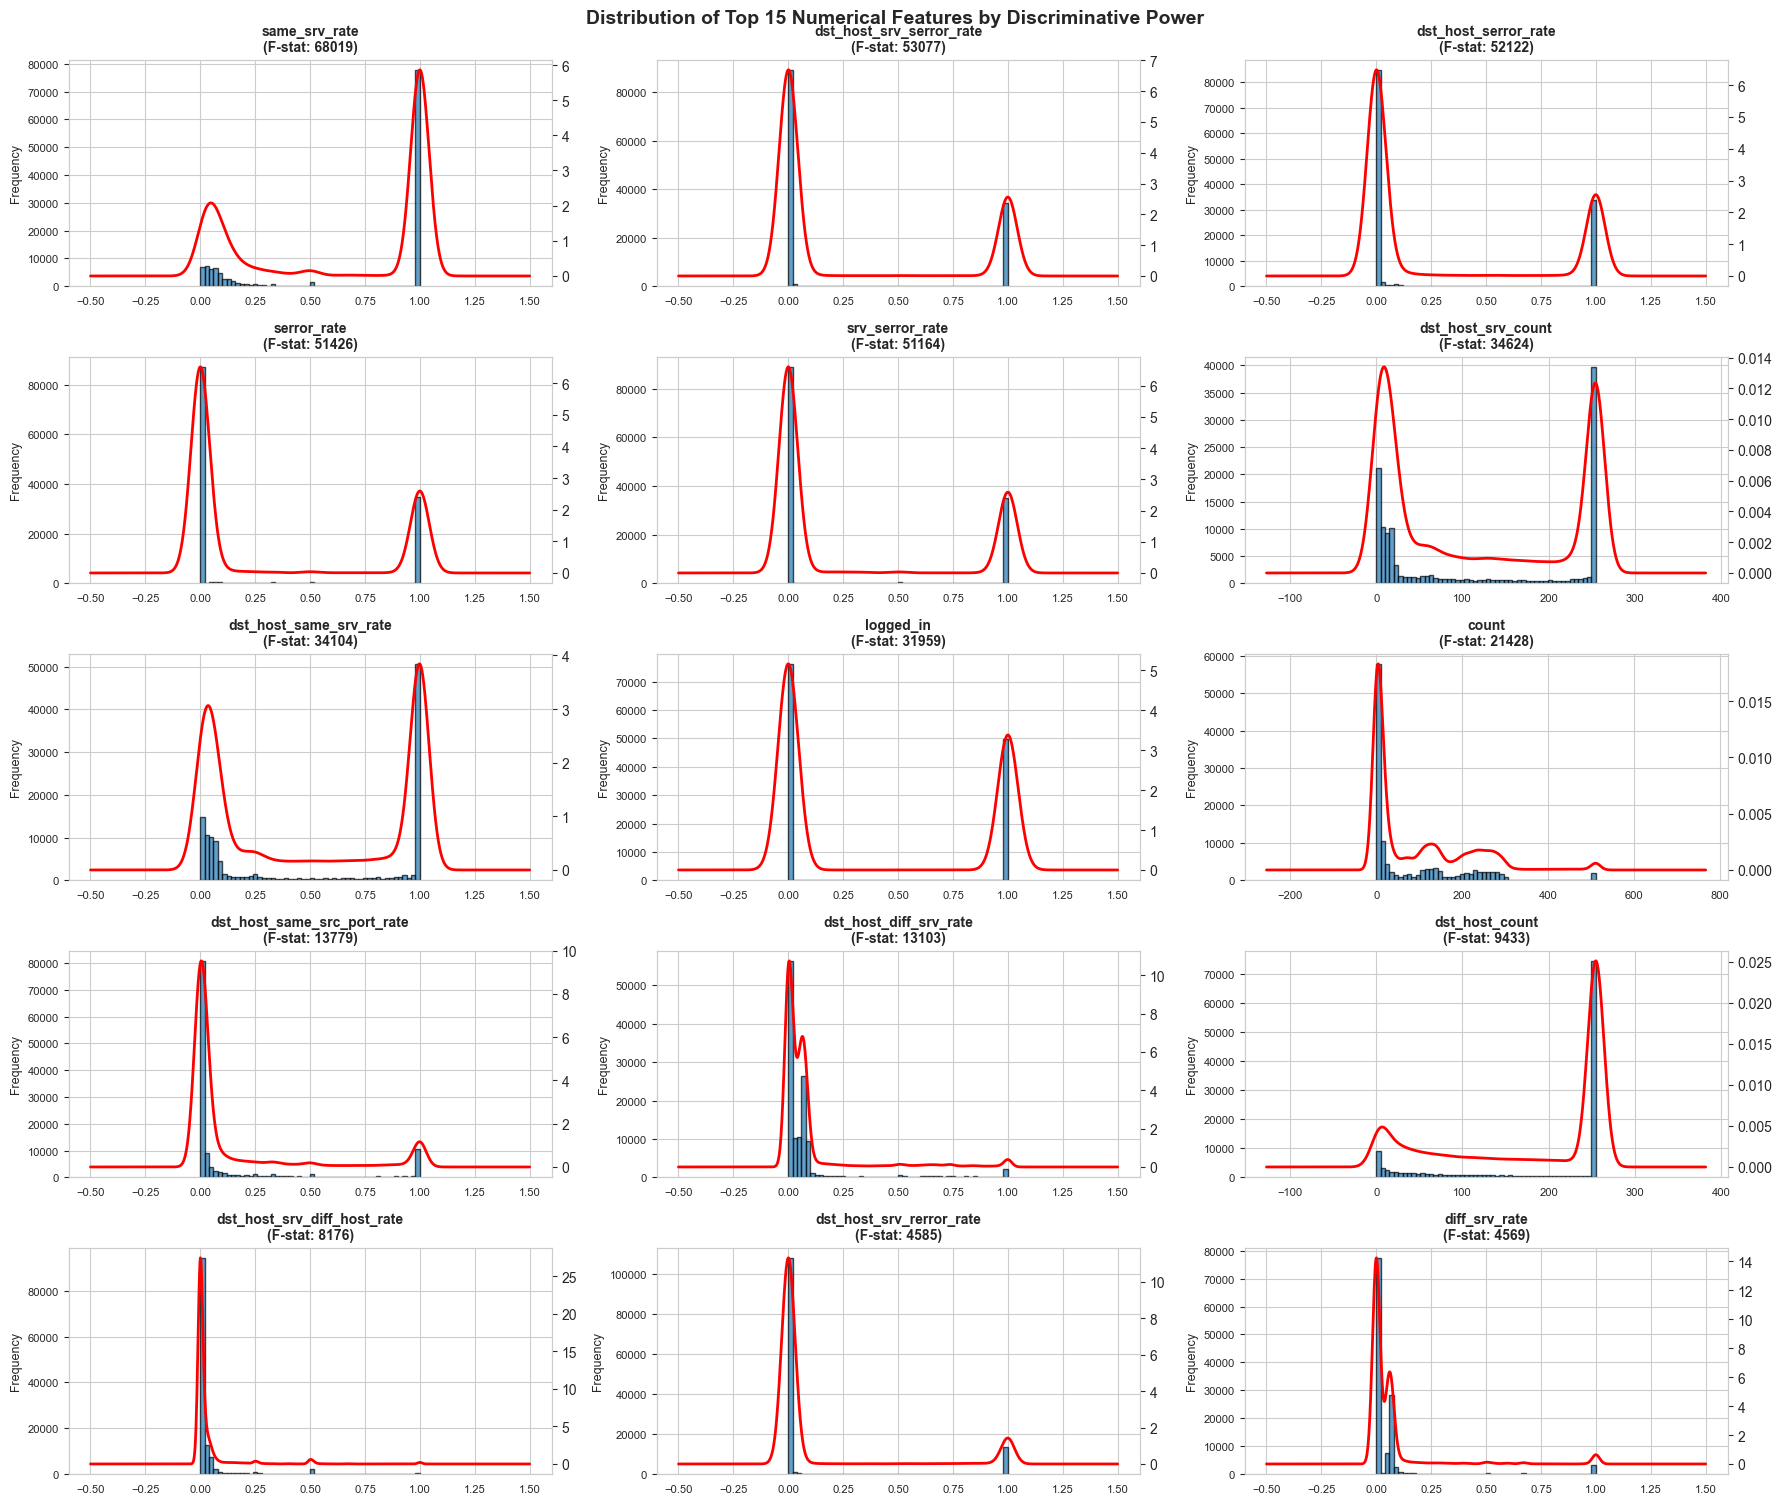


✓ Numerical feature distributions plotted


In [37]:
# ============================================================
# UNIVARIATE ANALYSIS - NUMERICAL FEATURE DISTRIBUTIONS
# ============================================================

# Set style
sns.set_style('whitegrid')

# Plot top 15 features
fig, axes = plt.subplots(5, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Plot histogram with KDE
    train_df[feature].hist(bins=50, alpha=0.7, ax=ax, edgecolor='black')
    
    # Add KDE if data has variation
    if train_df[feature].std() > 0:
        train_df[feature].plot(kind='kde', secondary_y=True, ax=ax, color='red', linewidth=2)
    
    ax.set_title(f'{feature}\n(F-stat: {feature_importance[feature_importance["feature"]==feature]["f_statistic"].values[0]:.0f})', 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency', fontsize=9)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.suptitle('Distribution of Top 15 Numerical Features by Discriminative Power', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()

print("\n✓ Numerical feature distributions plotted")

### Categorical Features

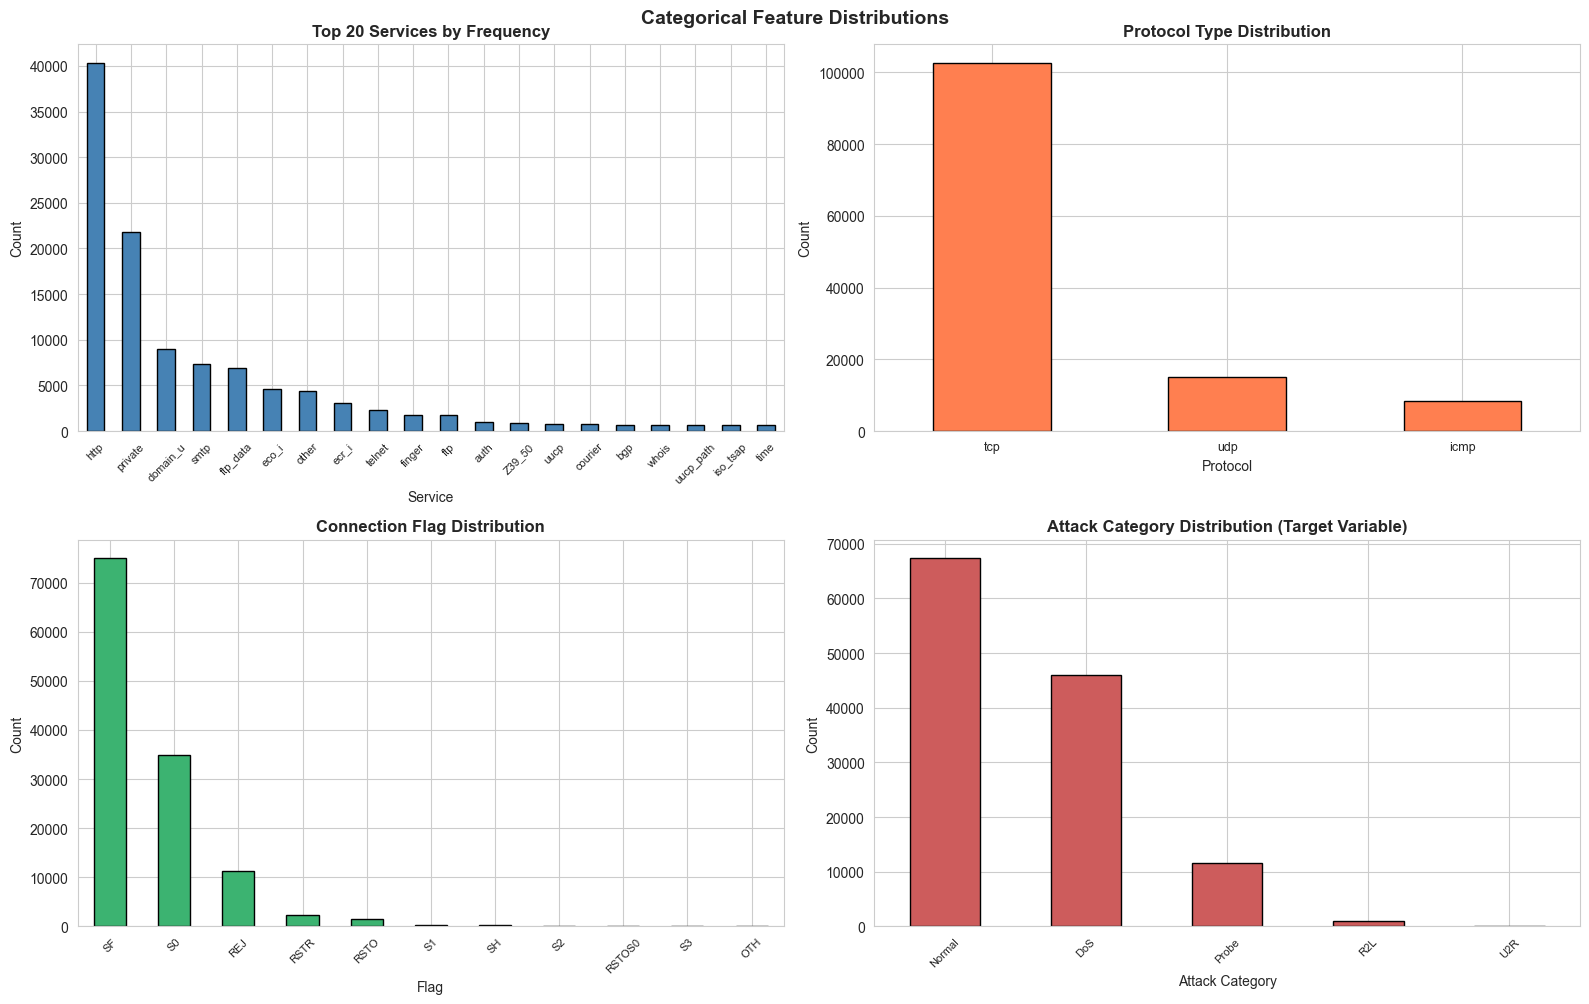


✓ Categorical feature distributions plotted


In [38]:
# ============================================================
# UNIVARIATE ANALYSIS - CATEGORICAL FEATURE DISTRIBUTIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Service (top 20)
ax1 = axes[0, 0]
service_counts = train_df['service'].value_counts().head(20)
service_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Top 20 Services by Frequency', fontsize=12, fontweight='bold')
ax1.set_xlabel('Service', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.tick_params(axis='x', rotation=45, labelsize=8)

# 2. Protocol Type
ax2 = axes[0, 1]
protocol_counts = train_df['protocol_type'].value_counts()
protocol_counts.plot(kind='bar', ax=ax2, color='coral', edgecolor='black')
ax2.set_title('Protocol Type Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Protocol', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.tick_params(axis='x', rotation=0, labelsize=9)

# 3. Flag
ax3 = axes[1, 0]
flag_counts = train_df['flag'].value_counts()
flag_counts.plot(kind='bar', ax=ax3, color='mediumseagreen', edgecolor='black')
ax3.set_title('Connection Flag Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Flag', fontsize=10)
ax3.set_ylabel('Count', fontsize=10)
ax3.tick_params(axis='x', rotation=45, labelsize=8)

# 4. Attack Category (target)
ax4 = axes[1, 1]
attack_counts = train_df['attack_category'].value_counts()
attack_counts.plot(kind='bar', ax=ax4, color='indianred', edgecolor='black')
ax4.set_title('Attack Category Distribution (Target Variable)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Attack Category', fontsize=10)
ax4.set_ylabel('Count', fontsize=10)
ax4.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.suptitle('Categorical Feature Distributions', fontsize=14, fontweight='bold', y=1.00)
plt.show()

print("\n✓ Categorical feature distributions plotted")

## Univariate Analysis

### Numerical Features

The dataset contains 34 numerical variables. To maintain interpretability and focus on the most discriminative features, a subset was selected for detailed exploration based on:

**ANOVA F-statistic ranking:** Features were ranked by their ability to discriminate between the five attack categories (Normal, DoS, Probe, R2L, U2R). The F-statistic measures the ratio of between-group variance to within-group variance—higher values indicate stronger discrimination between attack types.

**Top 15 features selected for visualization:**
1. same_srv_rate (F=68,019)
2. dst_host_srv_serror_rate (F=53,077)
3. dst_host_serror_rate (F=52,122)
4. serror_rate (F=51,426)
5. srv_serror_rate (F=51,164)
6. dst_host_srv_count (F=34,624)
7. dst_host_same_srv_rate (F=34,104)
8. logged_in (F=31,959)
9. count (F=21,428)
10. dst_host_same_src_port_rate (F=13,779)
11. dst_host_diff_srv_rate (F=13,103)
12. dst_host_count (F=9,433)
13. dst_host_srv_diff_host_rate (F=8,176)
14. dst_host_srv_rerror_rate (F=4,585)
15. diff_srv_rate (F=4,569)

**Key distributional patterns:**

**Bimodal rate features:** The majority of rate features (same_srv_rate, serror_rate, srv_serror_rate, etc.) exhibit pronounced bimodal distributions with heavy concentration at 0.0 and 1.0. This pattern indicates binary-like behavior in network traffic—connections either share characteristics (rate=1.0) or do not (rate=0.0), with intermediate values being rare. This bimodality is characteristic of network intrusion data where attacks often produce extreme behavioral patterns.

**Binary indicators:** The logged_in feature shows a clear binary distribution, reflecting whether a connection successfully logged into the system (1) or not (0). The heavy skew toward 0 indicates most connections in the dataset are not authenticated, which aligns with the prevalence of attack traffic.

**Right-skewed count features:** Connection count variables (count, dst_host_srv_count, dst_host_count) display strong right skewness with long tails. Most connections have low counts, but DoS attacks generate extreme values (visible in the long right tails), creating natural discrimination between normal traffic and flooding attacks.

**Zero-inflation in error rates:** Error rate features show substantial zero-inflation, where the majority of records have no errors (rate=0.0). Non-zero error rates appear as a secondary peak at 1.0, suggesting that when errors occur, they often affect all connections—a pattern consistent with reconnaissance and probing attacks.

These distributional characteristics directly inform modeling strategy: the bimodal nature of rate features suggests they are already well-suited for classification without transformation, while count features may benefit from the robust scaling already applied to handle extreme values.

### Categorical Features

Four categorical features were analyzed:

**service (70 categories, top 20 shown):**
- Heavily dominated by http (40,338 records, 32%) and private (21,853 records, 17%)
- Long tail distribution with many low-frequency services
- Top 10 services account for ~80% of data
- Encoded using smoothed target encoding to capture attack rate while handling high cardinality

**protocol_type (3 categories):**
- TCP dominates (103,599 records, 82%), reflecting its prevalence in internet traffic
- UDP (16,347 records, 13%) and ICMP (6,027 records, 5%) represent smaller but significant portions
- Distribution aligns with expected network traffic composition
- One-hot encoded for modeling

**flag (11 categories):**
- SF (successful connection, 76,813 records, 61%) is most common
- S0 (connection attempt rejected, 35,026 records, 28%) second most frequent
- REJ (connection rejected, 11,734 records, 9%) third
- Remaining flags (RSTR, RSTO, S1, S2, S3, SH, OTH) are rare (<2% each)
- Pattern suggests most traffic is either successfully established or immediately rejected
- One-hot encoded with drop_first=True

**attack_category (5 categories, target variable):**
- Severe class imbalance evident:
  - Normal: 67,343 (53.5%)
  - DoS: 45,927 (36.5%)
  - Probe: 11,656 (9.3%)
  - R2L: 995 (0.8%)
  - U2R: 52 (0.04%)
- Minority classes (R2L, U2R) represent critical security threats despite low frequency
- Imbalance will require special handling (SMOTE, class weights) during modeling to ensure adequate detection of rare but high-impact attacks

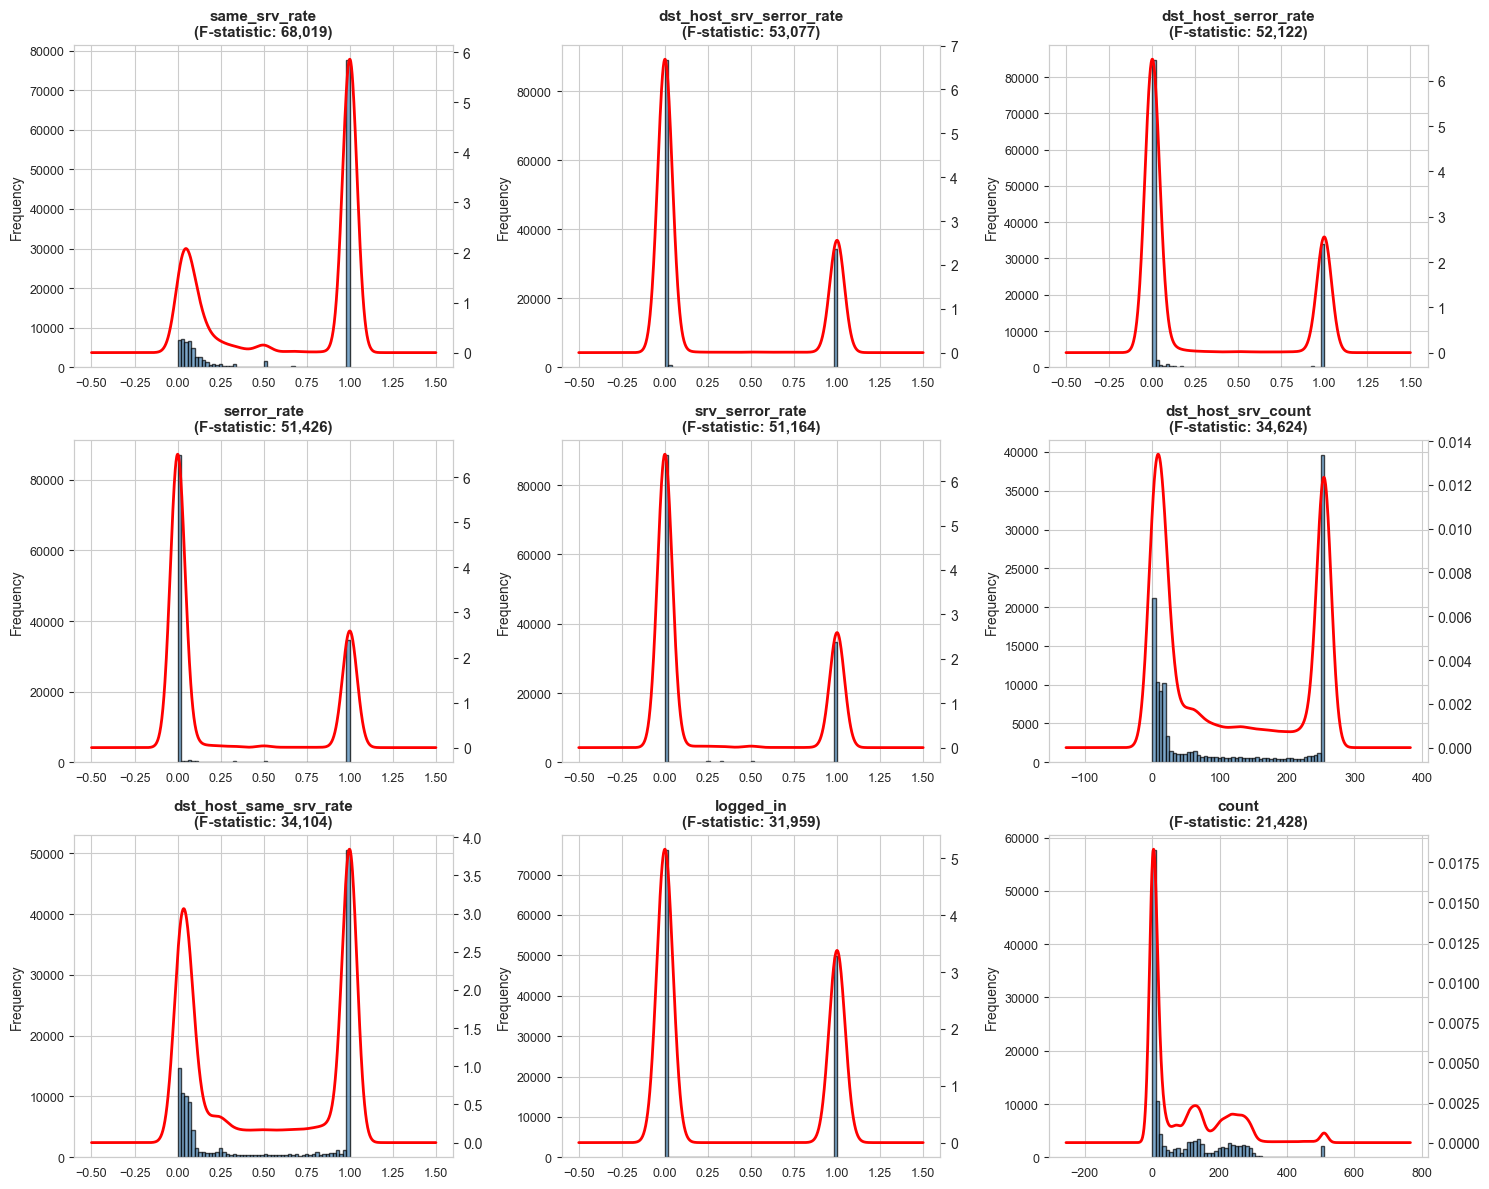

✓ Saved: univariate_numerical_top9.png


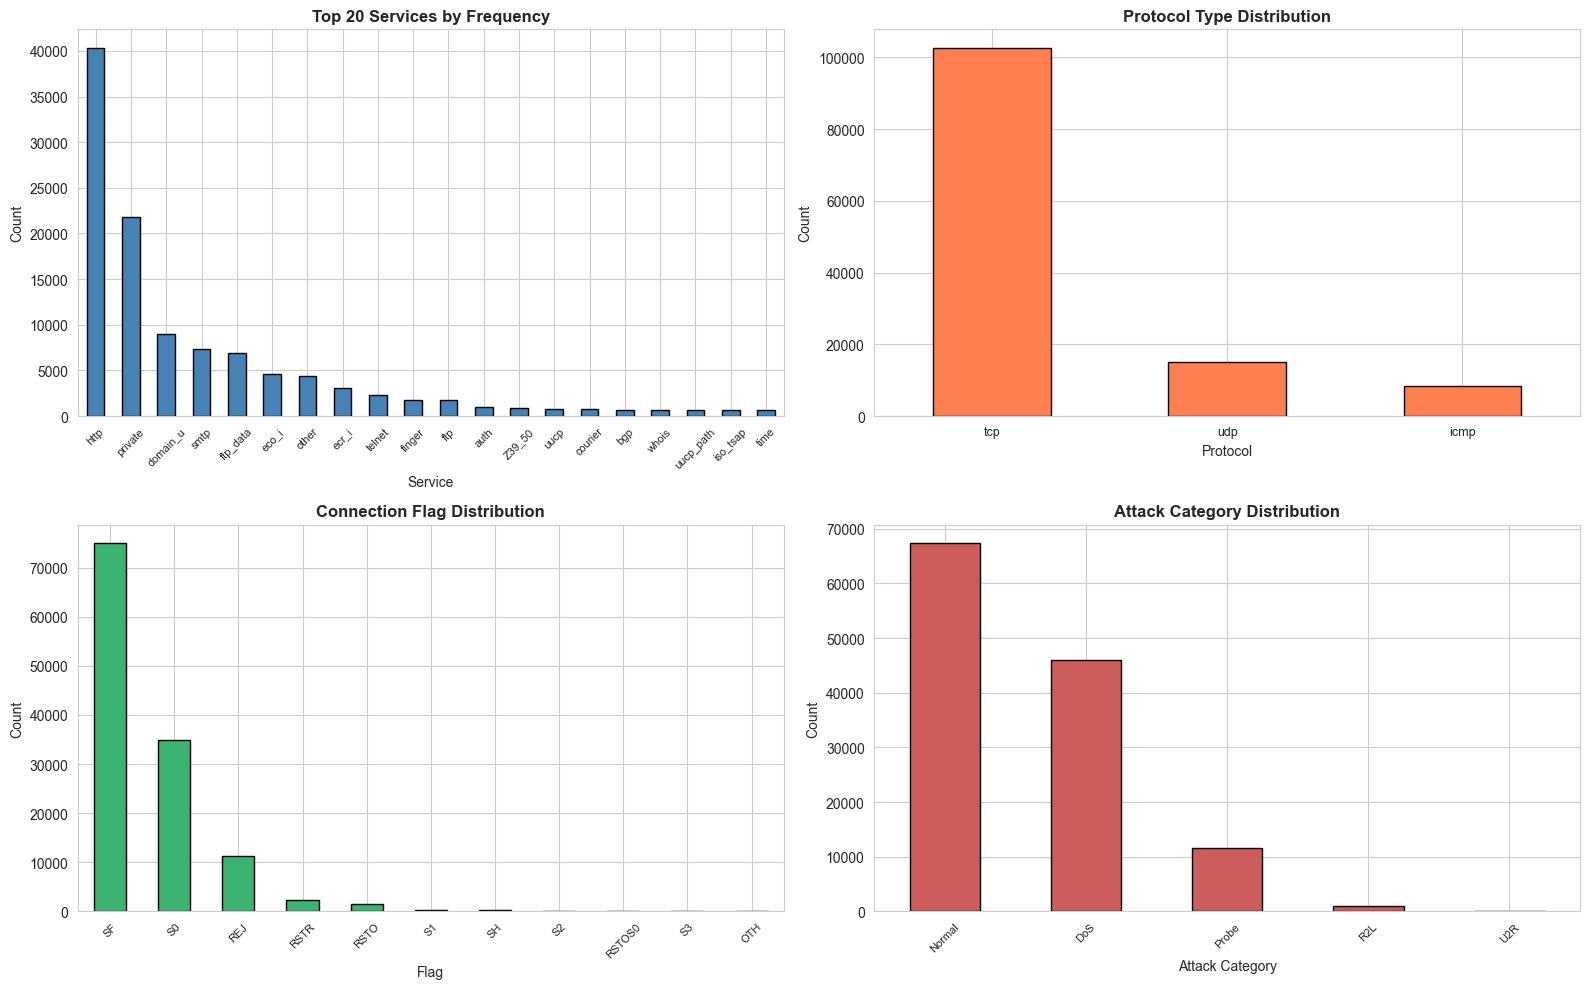

✓ Saved: univariate_categorical.png


In [39]:
# ============================================================
# SAVE VISUALIZATIONS FOR REPORT
# ============================================================

# 1. TOP 9 NUMERICAL FEATURES (3x3 grid)
top_9_features = feature_importance.head(9)['feature'].tolist()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Changed to 3x3
axes = axes.flatten()

for idx, feature in enumerate(top_9_features):
    ax = axes[idx]
    
    # Plot histogram with KDE
    train_df[feature].hist(bins=50, alpha=0.7, ax=ax, edgecolor='black', color='steelblue')
    
    # Add KDE
    if train_df[feature].std() > 0:
        train_df[feature].plot(kind='kde', secondary_y=True, ax=ax, color='red', linewidth=2)
    
    f_stat = feature_importance[feature_importance["feature"]==feature]["f_statistic"].values[0]
    ax.set_title(f'{feature}\n(F-statistic: {f_stat:,.0f})', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency', fontsize=10)
    ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig('univariate_numerical_top9.png', dpi=300, bbox_inches='tight')  # Changed filename
plt.show()

print("✓ Saved: univariate_numerical_top9.png")

# 2. CATEGORICAL FEATURES (already good as-is)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Service (top 20)
ax1 = axes[0, 0]
service_counts = train_df['service'].value_counts().head(20)
service_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Top 20 Services by Frequency', fontsize=12, fontweight='bold')
ax1.set_xlabel('Service', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.tick_params(axis='x', rotation=45, labelsize=8)

# Protocol Type
ax2 = axes[0, 1]
protocol_counts = train_df['protocol_type'].value_counts()
protocol_counts.plot(kind='bar', ax=ax2, color='coral', edgecolor='black')
ax2.set_title('Protocol Type Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Protocol', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.tick_params(axis='x', rotation=0, labelsize=9)

# Flag
ax3 = axes[1, 0]
flag_counts = train_df['flag'].value_counts()
flag_counts.plot(kind='bar', ax=ax3, color='mediumseagreen', edgecolor='black')
ax3.set_title('Connection Flag Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Flag', fontsize=10)
ax3.set_ylabel('Count', fontsize=10)
ax3.tick_params(axis='x', rotation=45, labelsize=8)

# Attack Category
ax4 = axes[1, 1]
attack_counts = train_df['attack_category'].value_counts()
attack_counts.plot(kind='bar', ax=ax4, color='indianred', edgecolor='black')
ax4.set_title('Attack Category Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Attack Category', fontsize=10)
ax4.set_ylabel('Count', fontsize=10)
ax4.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.savefig('univariate_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: univariate_categorical.png")

In [40]:
import os
print(f"Current directory: {os.getcwd()}")

Current directory: g:\My Drive\My Learning\Coursera\Coursera IBM certification in Machine Learning\Supervised Machine Learning - Classification


## 6.2 Bivariate Analysis

BIVARIATE ANALYSIS - CORRELATION MATRIX


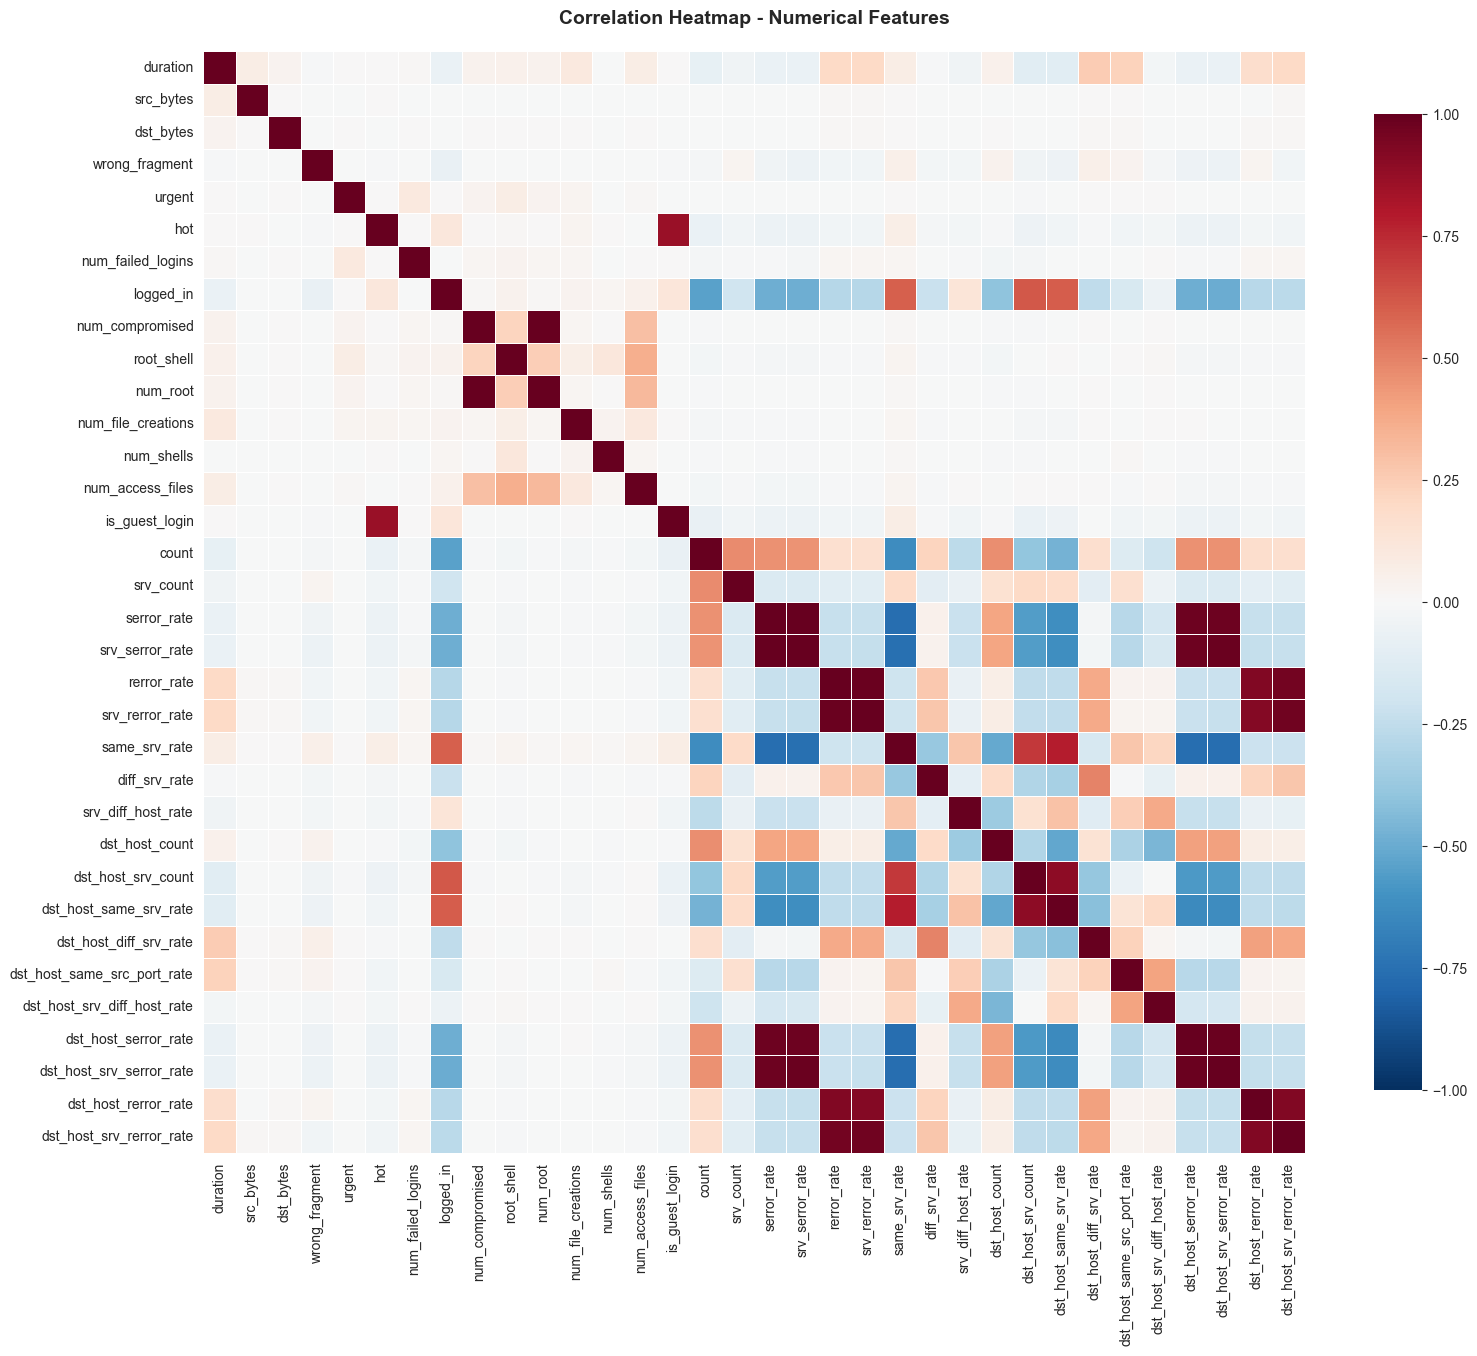


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)
           Feature 1                Feature 2  Correlation
     num_compromised                 num_root     0.998833
         serror_rate          srv_serror_rate     0.993289
         rerror_rate          srv_rerror_rate     0.989008
     srv_serror_rate dst_host_srv_serror_rate     0.986252
dst_host_serror_rate dst_host_srv_serror_rate     0.985052
         serror_rate dst_host_srv_serror_rate     0.981139
         serror_rate     dst_host_serror_rate     0.979373
     srv_serror_rate     dst_host_serror_rate     0.977596
     srv_rerror_rate dst_host_srv_rerror_rate     0.970208
         rerror_rate dst_host_srv_rerror_rate     0.964449
         rerror_rate     dst_host_rerror_rate     0.926749
dst_host_rerror_rate dst_host_srv_rerror_rate     0.924688
     srv_rerror_rate     dst_host_rerror_rate     0.917822
  dst_host_srv_count   dst_host_same_srv_rate     0.896663
                 hot           is_guest_login     0.860288

Total high

In [41]:
# ============================================================
# BIVARIATE ANALYSIS - CORRELATION HEATMAP
# ============================================================

print("BIVARIATE ANALYSIS - CORRELATION MATRIX")
print("=" * 80)

# Calculate correlation matrix for numerical features only
correlation_matrix = train_encoded[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            cmap='RdBu_r',  # Red-Blue diverging colormap
            center=0,        # Center colormap at 0
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=False)     # Too many features to annotate

plt.title('Correlation Heatmap - Numerical Features', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('bivariate_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify highly correlated pairs (>0.8 or <-0.8)
print("\n" + "=" * 80)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)")
print("=" * 80)

# Get upper triangle to avoid duplicates
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find correlations > 0.8 or < -0.8
high_corr = []
for column in upper_triangle.columns:
    for index in upper_triangle.index:
        corr_value = upper_triangle.loc[index, column]
        if abs(corr_value) > 0.8:
            high_corr.append({
                'Feature 1': index,
                'Feature 2': column,
                'Correlation': corr_value
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', 
                                                        key=abs, 
                                                        ascending=False)
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal highly correlated pairs: {len(high_corr_df)}")
else:
    print("\nNo feature pairs with |correlation| > 0.8")

In [42]:

# === Categorical Feature Associations (Cramér's V) ===
# Analyze relationships between categorical predictors
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Calculate Cramér's V for predictor pairs
cramers_results = {
    'protocol vs flag': cramers_v(train_df['protocol_type'], train_df['flag']),
    'protocol vs service': cramers_v(train_df['protocol_type'], train_df['service']),
    'service vs flag': cramers_v(train_df['service'], train_df['flag'])
}

print("Cramér's V (Categorical Associations):")
for pair, v in cramers_results.items():
    print(f"{pair}: {v:.3f}")

Cramér's V (Categorical Associations):
protocol vs flag: 0.278
protocol vs service: 0.923
service vs flag: 0.299


BIVARIATE ANALYSIS - FEATURE DISTRIBUTIONS BY ATTACK CATEGORY


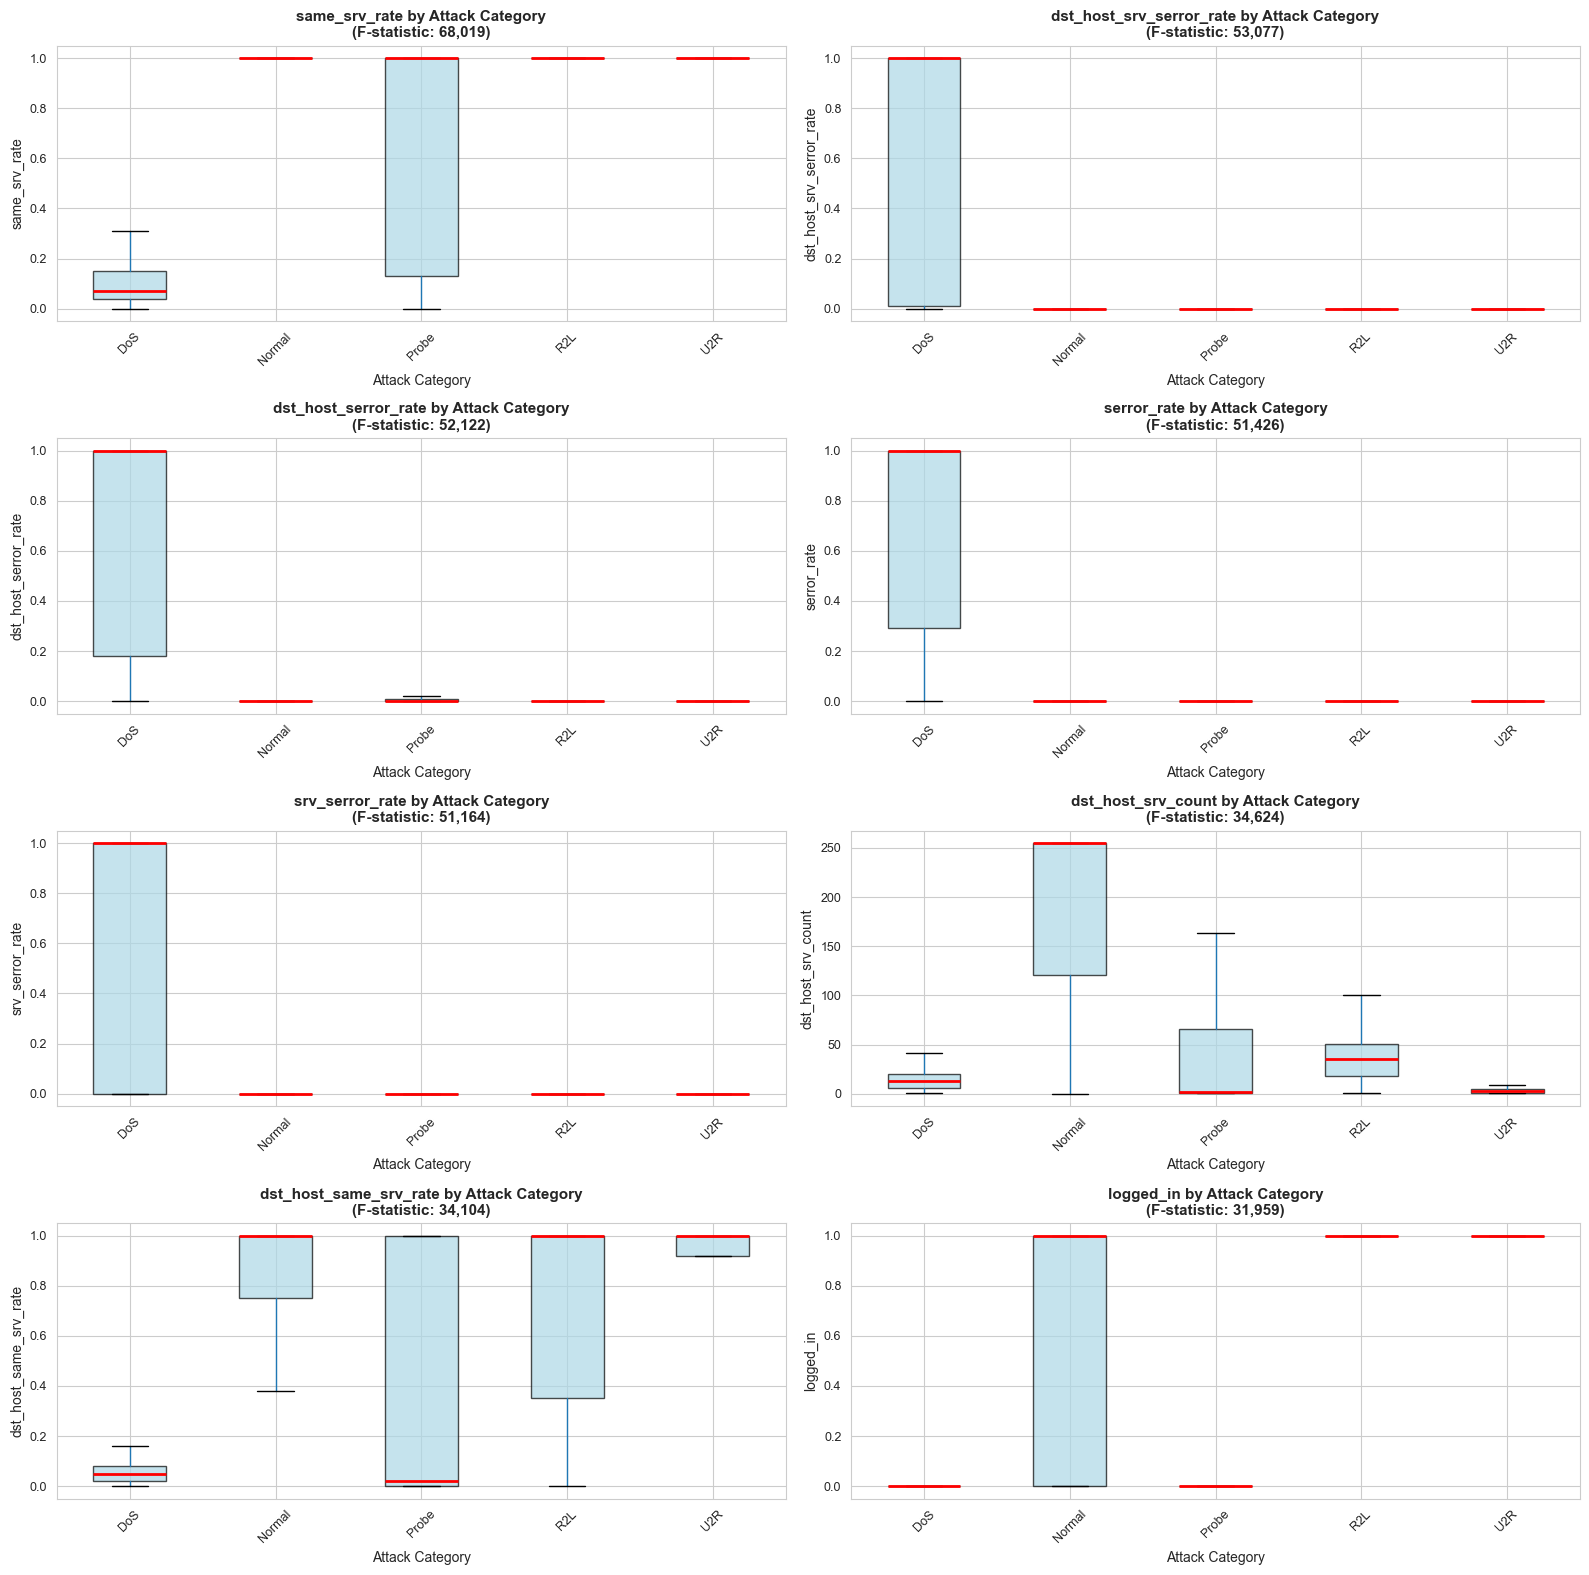


✓ Boxplots created showing feature distributions across attack categories


In [43]:
# ============================================================
# BIVARIATE ANALYSIS - FEATURES BY ATTACK CATEGORY
# ============================================================

print("BIVARIATE ANALYSIS - FEATURE DISTRIBUTIONS BY ATTACK CATEGORY")
print("=" * 80)

# Select top 8 features for boxplots
top_8_features = feature_importance.head(8)['feature'].tolist()

# Create boxplots
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, feature in enumerate(top_8_features):
    ax = axes[idx]
    
    # Create boxplot
    train_df.boxplot(column=feature, 
                     by='attack_category', 
                     ax=ax,
                     patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     showfliers=False)  # Hide outliers for clarity
    
    # Formatting
    f_stat = feature_importance[feature_importance["feature"]==feature]["f_statistic"].values[0]
    ax.set_title(f'{feature} by Attack Category\n(F-statistic: {f_stat:,.0f})', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Attack Category', fontsize=10)
    ax.set_ylabel(feature, fontsize=10)
    ax.tick_params(labelsize=9)
    plt.sca(ax)
    plt.xticks(rotation=45)
    
    # Remove the automatic title that pandas adds
    ax.get_figure().suptitle('')

plt.tight_layout()
plt.savefig('bivariate_boxplots_by_attack.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Boxplots created showing feature distributions across attack categories")

In [44]:
# ============================================================
# SUMMARY STATISTICS BY ATTACK CATEGORY
# ============================================================

print("\n" + "=" * 80)
print("FEATURE MEANS BY ATTACK CATEGORY (Top 6 Features)")
print("=" * 80)

# Calculate mean for top 6 features by attack category
top_6 = feature_importance.head(6)['feature'].tolist()

summary_stats = train_df.groupby('attack_category')[top_6].mean()
display(summary_stats.round(3))

print("\n" + "=" * 80)
print("KEY OBSERVATIONS")
print("=" * 80)
print("\nThese boxplots reveal how features discriminate between attack types:")
print("• High F-statistics indicate clear separation between attack categories")
print("• Median differences (red lines) show central tendency for each attack type")
print("• Box heights show variability within each category")
print("• Features with non-overlapping boxes are excellent discriminators")


FEATURE MEANS BY ATTACK CATEGORY (Top 6 Features)


,same_srv_rate,dst_host_srv_serror_rate,dst_host_serror_rate,serror_rate,srv_serror_rate,dst_host_srv_count
attack_category,,,,,,
DoS,0.192,0.744,0.748,0.748,0.747,26.524
Normal,0.969,0.006,0.014,0.013,0.012,190.286
Probe,0.697,0.040,0.045,0.047,0.040,42.367
R2L,0.997,0.016,0.024,0.012,0.011,42.440
U2R,0.932,0.005,0.000,0.038,0.000,9.885



KEY OBSERVATIONS

These boxplots reveal how features discriminate between attack types:
• High F-statistics indicate clear separation between attack categories
• Median differences (red lines) show central tendency for each attack type
• Box heights show variability within each category
• Features with non-overlapping boxes are excellent discriminators


In [45]:
# ============================================================
# BIVARIATE ANALYSIS - CATEGORICAL VS CATEGORICAL
# ============================================================

print("BIVARIATE ANALYSIS - CATEGORICAL VS CATEGORICAL")
print("=" * 80)

# 1. Protocol Type vs Attack Category
print("\n" + "=" * 80)
print("PROTOCOL TYPE vs ATTACK CATEGORY - CROSSTAB")
print("=" * 80)

protocol_crosstab = pd.crosstab(train_df['protocol_type'], 
                                 train_df['attack_category'], 
                                 margins=True)
print("\nCounts:")
print(protocol_crosstab)

print("\n\nRow Percentages (% of each protocol that is each attack type):")
protocol_pct = pd.crosstab(train_df['protocol_type'], 
                            train_df['attack_category'], 
                            normalize='index') * 100
print(protocol_pct.round(1))

print("\n\nColumn Percentages (% of each attack type using each protocol):")
protocol_pct_col = pd.crosstab(train_df['protocol_type'], 
                                train_df['attack_category'], 
                                normalize='columns') * 100
print(protocol_pct_col.round(1))

# 2. Flag vs Attack Category (top 5 flags only for readability)
print("\n" + "=" * 80)
print("FLAG vs ATTACK CATEGORY - CROSSTAB (Top 5 Flags)")
print("=" * 80)

top_flags = train_df['flag'].value_counts().head(5).index
flag_subset = train_df[train_df['flag'].isin(top_flags)]

flag_crosstab = pd.crosstab(flag_subset['flag'], 
                             flag_subset['attack_category'], 
                             margins=True)
print("\nCounts:")
print(flag_crosstab)

print("\n\nRow Percentages (% of each flag that is each attack type):")
flag_pct = pd.crosstab(flag_subset['flag'], 
                       flag_subset['attack_category'], 
                       normalize='index') * 100
print(flag_pct.round(1))

BIVARIATE ANALYSIS - CATEGORICAL VS CATEGORICAL

PROTOCOL TYPE vs ATTACK CATEGORY - CROSSTAB

Counts:
attack_category    DoS  Normal  Probe  R2L  U2R     All
protocol_type                                          
icmp              2847    1309   4135    0    0    8291
tcp              42188   53600   5857  995   49  102689
udp                892   12434   1664    0    3   14993
All              45927   67343  11656  995   52  125973


Row Percentages (% of each protocol that is each attack type):
attack_category   DoS  Normal  Probe  R2L  U2R
protocol_type                                 
icmp             34.3    15.8   49.9  0.0  0.0
tcp              41.1    52.2    5.7  1.0  0.0
udp               5.9    82.9   11.1  0.0  0.0


Column Percentages (% of each attack type using each protocol):
attack_category   DoS  Normal  Probe    R2L   U2R
protocol_type                                    
icmp              6.2     1.9   35.5    0.0   0.0
tcp              91.9    79.6   50.2  100.0  9

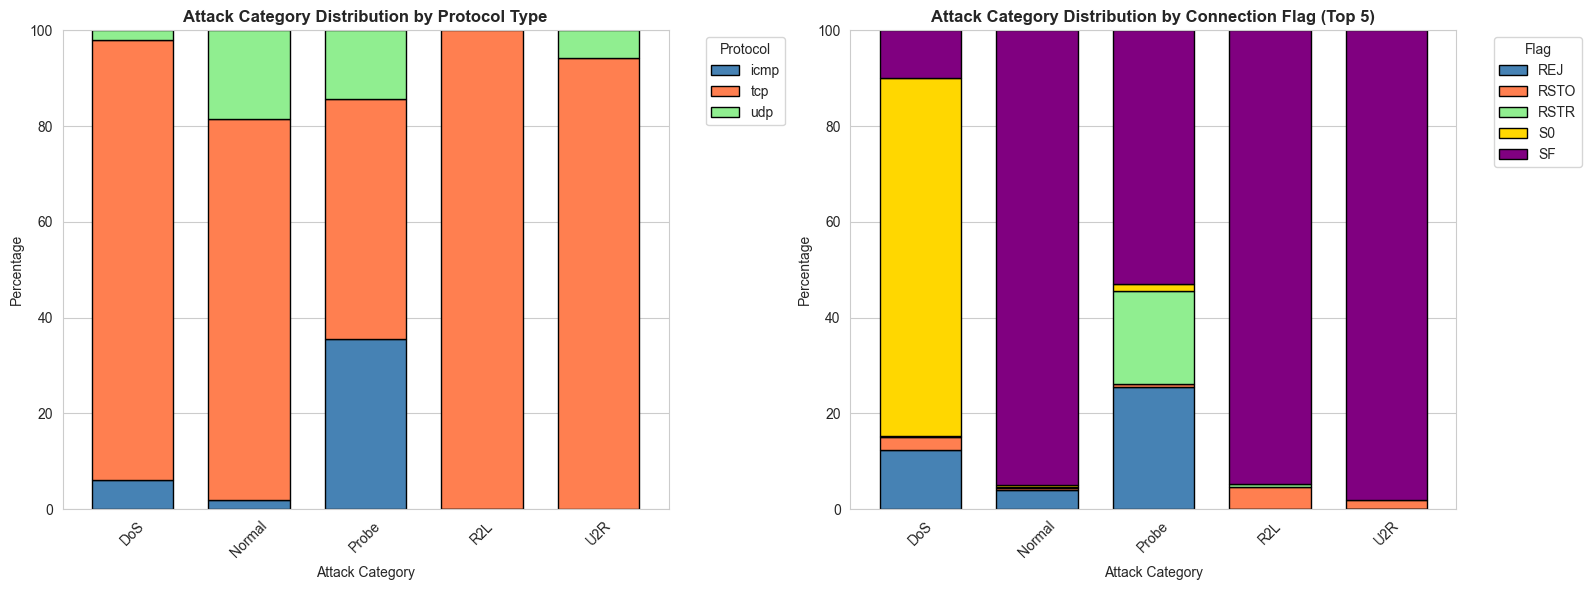


✓ Categorical vs categorical analysis complete


In [46]:
# ============================================================
# VISUALIZATIONS - CATEGORICAL VS CATEGORICAL
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate COLUMN percentages for flags
flag_pct_col = pd.crosstab(flag_subset['flag'], 
                            flag_subset['attack_category'], 
                            normalize='columns') * 100

# 1. Stacked bar chart - Protocol Type by Attack Category
ax1 = axes[0]
protocol_pct_col.T.plot(kind='bar', stacked=True, ax=ax1,  # Use column % AND transpose
                        color=['steelblue', 'coral', 'lightgreen'],
                        edgecolor='black', width=0.7)
ax1.set_title('Attack Category Distribution by Protocol Type', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Attack Category', fontsize=10)
ax1.set_ylabel('Percentage', fontsize=10)
ax1.legend(title='Protocol', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 100)

# 2. Stacked bar chart - Flag by Attack Category (top 5 flags)
ax2 = axes[1]
flag_pct_col.T.plot(kind='bar', stacked=True, ax=ax2,  # Use column % AND transpose
                    color=['steelblue', 'coral', 'lightgreen', 'gold', 'purple'],
                    edgecolor='black', width=0.7)
ax2.set_title('Attack Category Distribution by Connection Flag (Top 5)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Attack Category', fontsize=10)
ax2.set_ylabel('Percentage', fontsize=10)
ax2.legend(title='Flag', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('bivariate_categorical_vs_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Categorical vs categorical analysis complete")

# 🤖 8. Classification Models


## 8.1 Model 1: Logistic Regression (Baseline)



In [47]:
# ============================================================
# DATA PREPARATION FOR MODELING
# ============================================================

print("PREPARING DATA FOR MODELING")
print("=" * 80)

# Drop non-feature columns:
# - 'attack_category' (categorical target - keep encoded version)
# - 'service' (categorical predictor - keep encoded version)
drop_cols = ['attack_category', 'service']

# Separate features (X) and target (y)
X_train = train_encoded.drop(drop_cols + ['attack_category_encoded'], axis=1)
y_train = train_encoded['attack_category_encoded']

X_test = test_encoded.drop(drop_cols + ['attack_category_encoded'], axis=1)
y_test = test_encoded['attack_category_encoded']

print(f"\nTraining set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

print(f"\nFeature columns ({len(X_train.columns)}):")
print(X_train.columns.tolist())

print(f"\nTarget distribution (training):")
print(y_train.value_counts().sort_index())
print(f"\nClass mapping: 0=DoS, 1=Normal, 2=Probe, 3=R2L, 4=U2R")

print("\n" + "=" * 80)
print("✅ Data ready for modeling!")
print("=" * 80)

PREPARING DATA FOR MODELING

Training set: 125973 samples, 47 features
Test set: 22544 samples, 47 features

Feature columns (47):
['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'service_encoded', 'protocol_type_tcp', 'protocol_type_udp', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH']

Target distribution (training):
attack_category_encoded
0

✅ Results tracking initialized - ready to compare models!

LOGISTIC REGRESSION - BASELINE MODEL

Training...

PERFORMANCE METRICS

🎯 PRIMARY METRICS (Cybersecurity Focus):
   Macro Avg Recall: 0.4011 ⭐ (minimize false negatives)
   Macro Avg F1:     0.3972
   ROC-AUC (Macro):  0.7901

📊 SECONDARY METRICS:
   Macro Avg Precision: 0.4489
   Overall Accuracy:    0.6832

--------------------------------------------------------------------------------
Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     DoS (0)     0.8017    0.7274    0.7627      7458
  Normal (1)     0.6198    0.9443    0.7484      9711
   Probe (2)     0.8228    0.3337    0.4749      2421
     R2L (3)     0.0000    0.0000    0.0000      2754
     U2R (4)     0.0000    0.0000    0.0000       200

    accuracy                         0.6832     22544
   macro avg     0.4489    0.4011    0.3972     22544
we

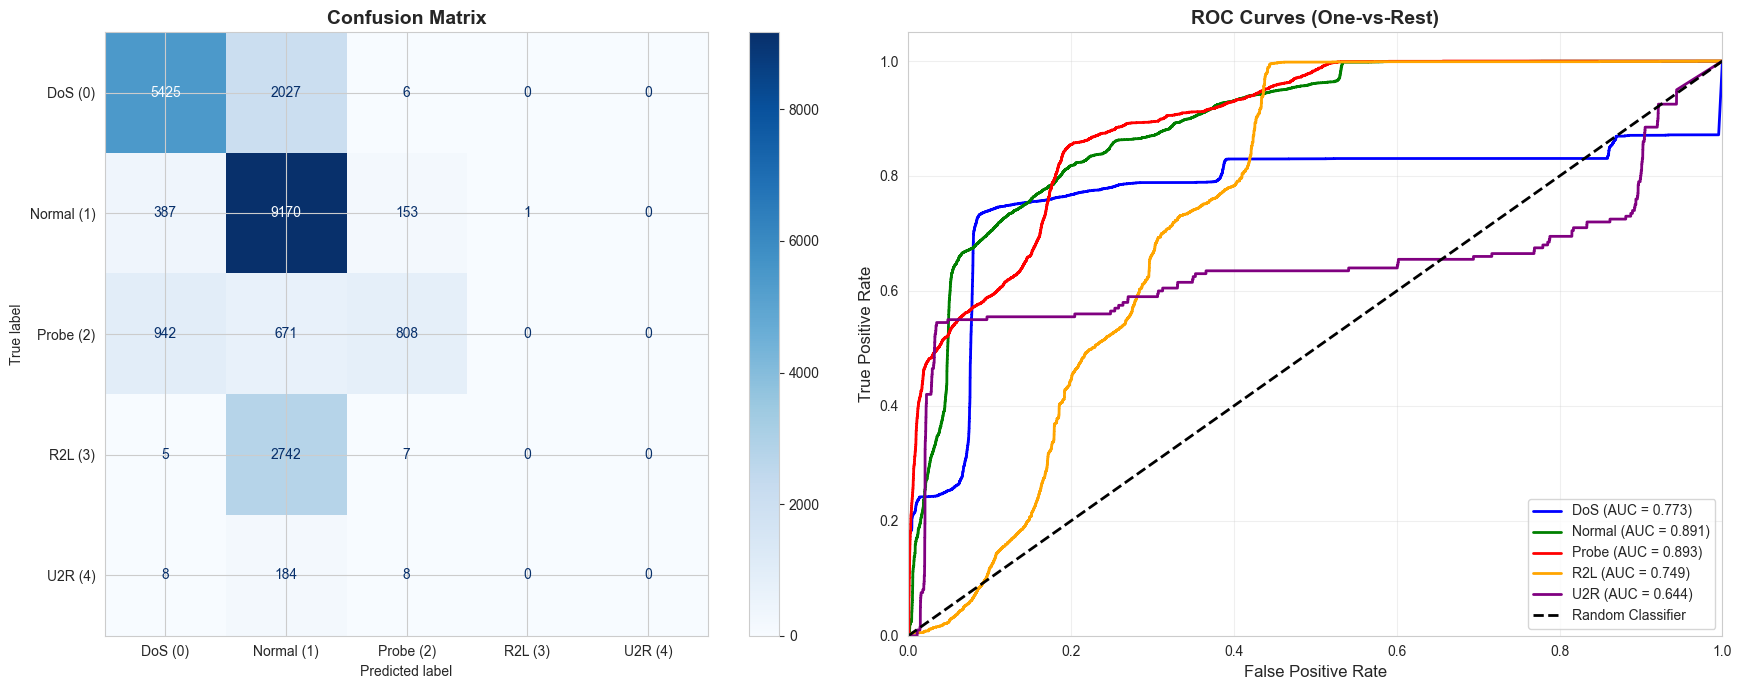


✅ Logistic Regression complete - results stored


In [48]:
# ============================================================
# RESULTS TRACKING - Initialize dictionary for model comparison
# ============================================================

from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score,
                             classification_report, confusion_matrix, 
                             accuracy_score, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.preprocessing import label_binarize
import numpy as np

# Dictionary to store all model results
model_results = {
    'model_name': [],
    'macro_avg_recall': [],
    'macro_avg_f1': [],
    'roc_auc_macro': [],
    'accuracy': [],
    'macro_avg_precision': [],
    # Per-class metrics (all of them)
    'DoS_precision': [], 'DoS_recall': [], 'DoS_f1': [],
    'Normal_precision': [], 'Normal_recall': [], 'Normal_f1': [],
    'Probe_precision': [], 'Probe_recall': [], 'Probe_f1': [],
    'R2L_precision': [], 'R2L_recall': [], 'R2L_f1': [],
    'U2R_precision': [], 'U2R_recall': [], 'U2R_f1': []
}

print("✅ Results tracking initialized - ready to compare models!")

# ============================================================
# MODEL 1: LOGISTIC REGRESSION (BASELINE)
# ============================================================

print("\n" + "=" * 80)
print("LOGISTIC REGRESSION - BASELINE MODEL")
print("=" * 80)

# Train model
lr_model = LogisticRegression(max_iter=1000, random_state=42, verbose=1)
print("\nTraining...")
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

# ============================================================
# EVALUATION
# ============================================================

print("\n" + "=" * 80)
print("PERFORMANCE METRICS")
print("=" * 80)

# Get per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_lr, labels=[0, 1, 2, 3, 4], zero_division=0
)

# Calculate ROC-AUC
roc_auc_macro = roc_auc_score(y_test, y_pred_proba_lr, 
                               multi_class='ovr', average='macro')

# 1. LEAD WITH CRITICAL METRICS (Cybersecurity Focus)
print("\n🎯 PRIMARY METRICS (Cybersecurity Focus):")
print(f"   Macro Avg Recall: {recall.mean():.4f} ⭐ (minimize false negatives)")
print(f"   Macro Avg F1:     {f1.mean():.4f}")
print(f"   ROC-AUC (Macro):  {roc_auc_macro:.4f}")

print("\n📊 SECONDARY METRICS:")
print(f"   Macro Avg Precision: {precision.mean():.4f}")
print(f"   Overall Accuracy:    {accuracy_score(y_test, y_pred_lr):.4f}")

# 2. Full classification report
print("\n" + "-" * 80)
print("Detailed Classification Report:")
print("-" * 80)
target_names = ['DoS (0)', 'Normal (1)', 'Probe (2)', 'R2L (3)', 'U2R (4)']
print(classification_report(y_test, y_pred_lr, target_names=target_names, digits=4))

# 3. Highlight critical failures
print("⚠️  CRITICAL ISSUES:")
if recall[3] < 0.5:  # R2L
    print(f"    R2L Recall: {recall[3]:.4f} - Missing {(1-recall[3])*100:.1f}% of R2L attacks!")
if recall[4] < 0.5:  # U2R
    print(f"    U2R Recall: {recall[4]:.4f} - Missing {(1-recall[4])*100:.1f}% of U2R attacks!")
if recall[2] < 0.5:  # Probe
    print(f"    Probe Recall: {recall[2]:.4f} - Missing {(1-recall[2])*100:.1f}% of Probe attacks!")

# ============================================================
# STORE RESULTS
# ============================================================

classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

model_results['model_name'].append('Logistic Regression')
model_results['macro_avg_recall'].append(recall.mean())
model_results['macro_avg_f1'].append(f1.mean())
model_results['roc_auc_macro'].append(roc_auc_macro)
model_results['accuracy'].append(accuracy_score(y_test, y_pred_lr))
model_results['macro_avg_precision'].append(precision.mean())

# Store ALL per-class metrics
for i, class_name in enumerate(classes):
    model_results[f'{class_name}_precision'].append(precision[i])
    model_results[f'{class_name}_recall'].append(recall[i])
    model_results[f'{class_name}_f1'].append(f1[i])

# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Confusion Matrix
ax1 = axes[0]
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 2. ROC Curves (One-vs-Rest)
ax2 = axes[1]

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (color, class_name) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_lr[:, i])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lr_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("✅ Logistic Regression complete - results stored")
print("=" * 80)

## 8.2 Model 2: Random Forest




RANDOM FOREST - BASELINE MODEL

Training Random Forest (100 trees)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



PERFORMANCE METRICS

🎯 PRIMARY METRICS (Cybersecurity Focus):
   Macro Avg Recall: 0.5067 ⭐ (minimize false negatives)
   Macro Avg F1:     0.5081
   ROC-AUC (Macro):  0.8908

📊 SECONDARY METRICS:
   Macro Avg Precision: 0.8148
   Overall Accuracy:    0.7654

--------------------------------------------------------------------------------
Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     DoS (0)     0.9601    0.8034    0.8748      7458
  Normal (1)     0.6627    0.9737    0.7887      9711
   Probe (2)     0.8857    0.7109    0.7887      2421
     R2L (3)     0.9655    0.0305    0.0591      2754
     U2R (4)     0.6000    0.0150    0.0293       200

    accuracy                         0.7654     22544
   macro avg     0.8148    0.5067    0.5081     22544
weighted avg     0.8215    0.7654    0.7213     22544

⚠️  CRITICAL ISSUES:
    R2L Recall: 0.0305 - Missing 96

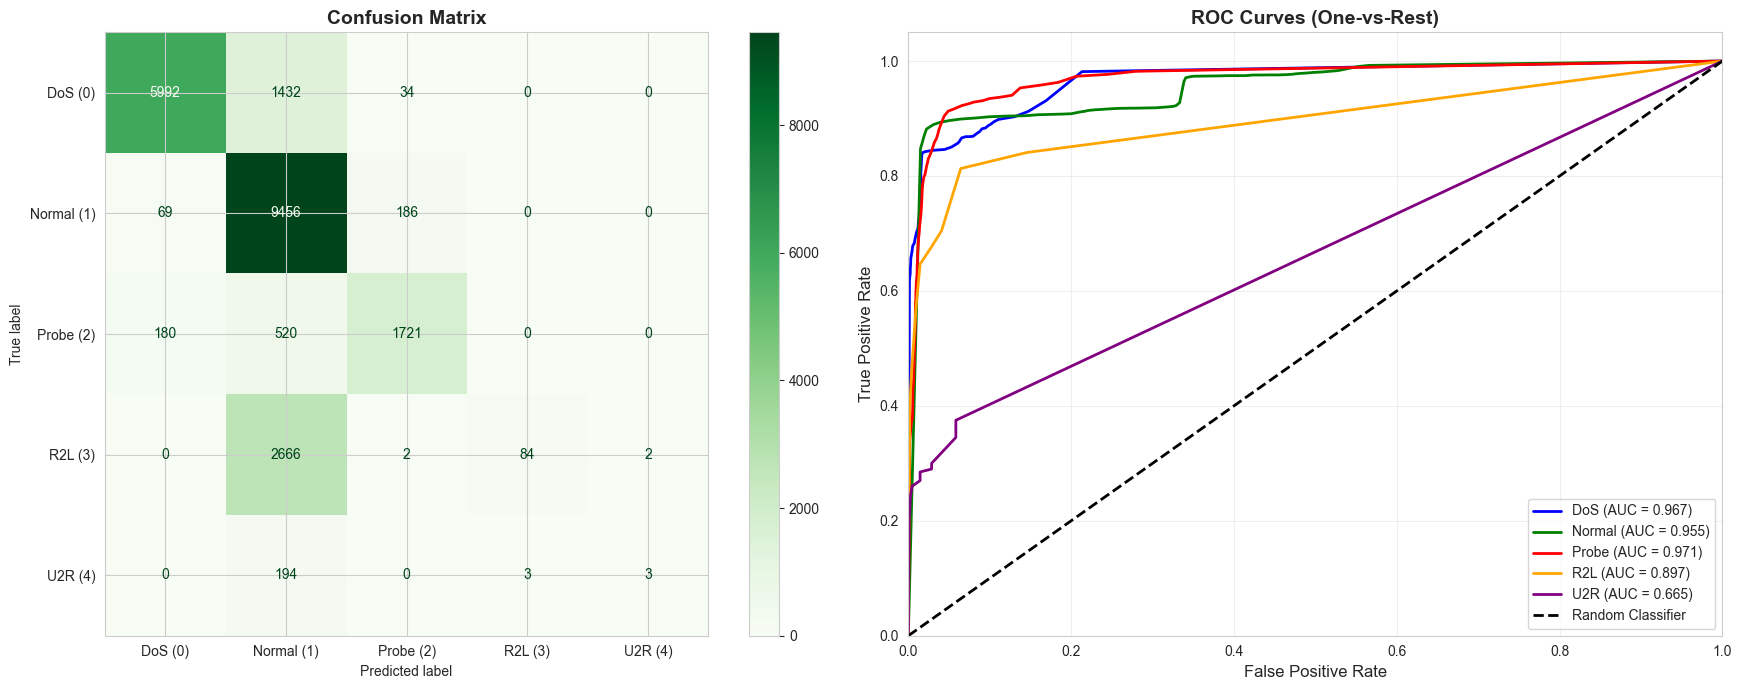


✅ Random Forest complete - results stored


In [49]:
# ============================================================
# MODEL 2: RANDOM FOREST (BASELINE)
# ============================================================

print("\n" + "=" * 80)
print("RANDOM FOREST - BASELINE MODEL")
print("=" * 80)

# Train model
# n_estimators=100 (default, reasonable baseline)
# random_state for reproducibility
# n_jobs=-1 to use all CPU cores (faster)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest (100 trees)...")
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# ============================================================
# EVALUATION
# ============================================================

print("\n" + "=" * 80)
print("PERFORMANCE METRICS")
print("=" * 80)

# Get per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_rf, labels=[0, 1, 2, 3, 4], zero_division=0
)

# Calculate ROC-AUC
roc_auc_macro = roc_auc_score(y_test, y_pred_proba_rf, 
                               multi_class='ovr', average='macro')

# 1. LEAD WITH CRITICAL METRICS
print("\n🎯 PRIMARY METRICS (Cybersecurity Focus):")
print(f"   Macro Avg Recall: {recall.mean():.4f} ⭐ (minimize false negatives)")
print(f"   Macro Avg F1:     {f1.mean():.4f}")
print(f"   ROC-AUC (Macro):  {roc_auc_macro:.4f}")

print("\n📊 SECONDARY METRICS:")
print(f"   Macro Avg Precision: {precision.mean():.4f}")
print(f"   Overall Accuracy:    {accuracy_score(y_test, y_pred_rf):.4f}")

# 2. Full classification report
print("\n" + "-" * 80)
print("Detailed Classification Report:")
print("-" * 80)
target_names = ['DoS (0)', 'Normal (1)', 'Probe (2)', 'R2L (3)', 'U2R (4)']
print(classification_report(y_test, y_pred_rf, target_names=target_names, digits=4))

# 3. Highlight critical failures
print("⚠️  CRITICAL ISSUES:")
if recall[3] < 0.5:  # R2L
    print(f"    R2L Recall: {recall[3]:.4f} - Missing {(1-recall[3])*100:.1f}% of R2L attacks!")
if recall[4] < 0.5:  # U2R
    print(f"    U2R Recall: {recall[4]:.4f} - Missing {(1-recall[4])*100:.1f}% of U2R attacks!")
if recall[2] < 0.5:  # Probe
    print(f"    Probe Recall: {recall[2]:.4f} - Missing {(1-recall[2])*100:.1f}% of Probe attacks!")

# ============================================================
# STORE RESULTS
# ============================================================

classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

model_results['model_name'].append('Random Forest')
model_results['macro_avg_recall'].append(recall.mean())
model_results['macro_avg_f1'].append(f1.mean())
model_results['roc_auc_macro'].append(roc_auc_macro)
model_results['accuracy'].append(accuracy_score(y_test, y_pred_rf))
model_results['macro_avg_precision'].append(precision.mean())

# Store ALL per-class metrics
for i, class_name in enumerate(classes):
    model_results[f'{class_name}_precision'].append(precision[i])
    model_results[f'{class_name}_recall'].append(recall[i])
    model_results[f'{class_name}_f1'].append(f1[i])

# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Confusion Matrix
ax1 = axes[0]
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax1, cmap='Greens', values_format='d')
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 2. ROC Curves (One-vs-Rest)
ax2 = axes[1]

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Compute ROC curve for each class
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (color, class_name) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rf_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("✅ Random Forest complete - results stored")
print("=" * 80)

In [50]:
# ============================================================
# MODEL COMPARISON TABLE (SO FAR)
# ============================================================

import pandas as pd

results_df = pd.DataFrame(model_results)

print("\n" + "=" * 80)
print("MODEL COMPARISON - PRIMARY METRICS")
print("=" * 80)
print(results_df[['model_name', 'macro_avg_recall', 'macro_avg_f1', 
                   'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n" + "=" * 80)
print("MODEL COMPARISON - MINORITY CLASS RECALL (Critical!)")
print("=" * 80)
print(results_df[['model_name', 'R2L_recall', 'U2R_recall', 
                   'Probe_recall', 'DoS_recall', 'Normal_recall']].to_string(index=False))

print("\n" + "=" * 80)
print("MODEL COMPARISON - F1 SCORES BY CLASS")
print("=" * 80)
print(results_df[['model_name', 'DoS_f1', 'Normal_f1', 'Probe_f1', 
                   'R2L_f1', 'U2R_f1']].to_string(index=False))


MODEL COMPARISON - PRIMARY METRICS
         model_name  macro_avg_recall  macro_avg_f1  roc_auc_macro  accuracy
Logistic Regression          0.401089      0.397207       0.790082  0.683242
      Random Forest          0.506708      0.508125       0.890794  0.765436

MODEL COMPARISON - MINORITY CLASS RECALL (Critical!)
         model_name  R2L_recall  U2R_recall  Probe_recall  DoS_recall  Normal_recall
Logistic Regression    0.000000       0.000      0.333746    0.727407       0.944290
      Random Forest    0.030501       0.015      0.710863    0.803433       0.973741

MODEL COMPARISON - F1 SCORES BY CLASS
         model_name   DoS_f1  Normal_f1  Probe_f1   R2L_f1   U2R_f1
Logistic Regression 0.762742   0.748419  0.474875 0.000000 0.000000
      Random Forest 0.874808   0.788690  0.788726 0.059134 0.029268


## 8.3 Model 3: XGBoost



XGBOOST - BASELINE MODEL

Training XGBoost (100 trees)...

PERFORMANCE METRICS

🎯 PRIMARY METRICS (Cybersecurity Focus):
   Macro Avg Recall: 0.5210 ⭐ (minimize false negatives)
   Macro Avg F1:     0.5260
   ROC-AUC (Macro):  0.9432

📊 SECONDARY METRICS:
   Macro Avg Precision: 0.8065
   Overall Accuracy:    0.7580

--------------------------------------------------------------------------------
Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     DoS (0)     0.8925    0.8162    0.8526      7458
  Normal (1)     0.6707    0.9226    0.7767      9711
   Probe (2)     0.8533    0.7617    0.8049      2421
     R2L (3)     0.9795    0.0694    0.1295      2754
     U2R (4)     0.6364    0.0350    0.0664       200

    accuracy                         0.7580     22544
   macro avg     0.8065    0.5210    0.5260     22544
weighted avg     0.8011    0.7580    0.7195     2254

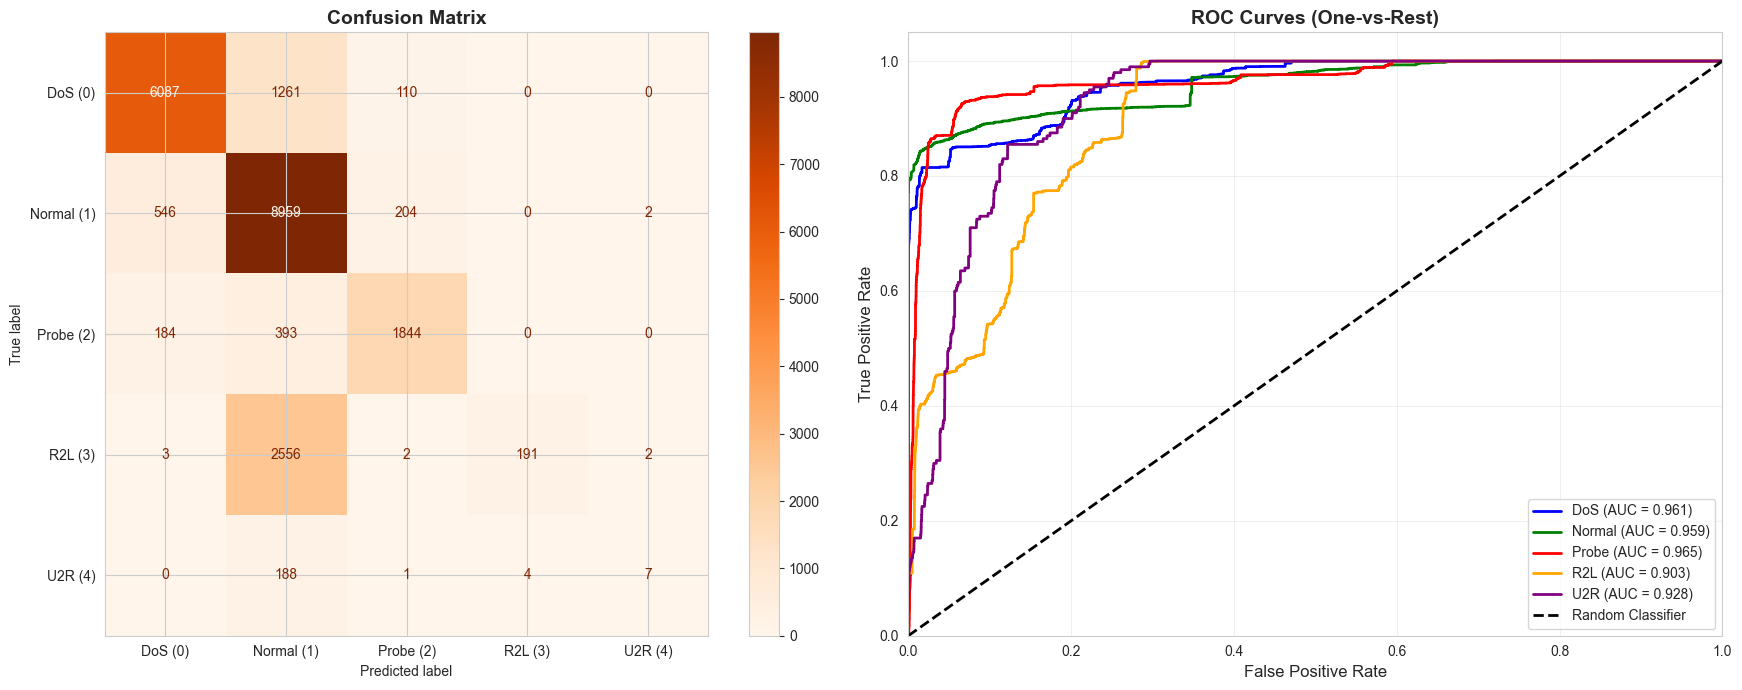


✅ XGBoost complete - results stored


In [51]:
# ============================================================
# MODEL 3: XGBOOST (BASELINE)
# ============================================================

print("\n" + "=" * 80)
print("XGBOOST - BASELINE MODEL")
print("=" * 80)

# Train model
# n_estimators=100 (match Random Forest for fair comparison)
# use_label_encoder=False to avoid warning
# eval_metric='mlogloss' for multi-class
# random_state for reproducibility
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)

print("\nTraining XGBoost (100 trees)...")
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# ============================================================
# EVALUATION
# ============================================================

print("\n" + "=" * 80)
print("PERFORMANCE METRICS")
print("=" * 80)

# Get per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_xgb, labels=[0, 1, 2, 3, 4], zero_division=0
)

# Calculate ROC-AUC
roc_auc_macro = roc_auc_score(y_test, y_pred_proba_xgb, 
                               multi_class='ovr', average='macro')

# 1. LEAD WITH CRITICAL METRICS
print("\n🎯 PRIMARY METRICS (Cybersecurity Focus):")
print(f"   Macro Avg Recall: {recall.mean():.4f} ⭐ (minimize false negatives)")
print(f"   Macro Avg F1:     {f1.mean():.4f}")
print(f"   ROC-AUC (Macro):  {roc_auc_macro:.4f}")

print("\n📊 SECONDARY METRICS:")
print(f"   Macro Avg Precision: {precision.mean():.4f}")
print(f"   Overall Accuracy:    {accuracy_score(y_test, y_pred_xgb):.4f}")

# 2. Full classification report
print("\n" + "-" * 80)
print("Detailed Classification Report:")
print("-" * 80)
target_names = ['DoS (0)', 'Normal (1)', 'Probe (2)', 'R2L (3)', 'U2R (4)']
print(classification_report(y_test, y_pred_xgb, target_names=target_names, digits=4))

# 3. Highlight critical failures
print("⚠️  CRITICAL ISSUES:")
if recall[3] < 0.5:  # R2L
    print(f"    R2L Recall: {recall[3]:.4f} - Missing {(1-recall[3])*100:.1f}% of R2L attacks!")
if recall[4] < 0.5:  # U2R
    print(f"    U2R Recall: {recall[4]:.4f} - Missing {(1-recall[4])*100:.1f}% of U2R attacks!")
if recall[2] < 0.5:  # Probe
    print(f"    Probe Recall: {recall[2]:.4f} - Missing {(1-recall[2])*100:.1f}% of Probe attacks!")

# ============================================================
# STORE RESULTS
# ============================================================

classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

model_results['model_name'].append('XGBoost')
model_results['macro_avg_recall'].append(recall.mean())
model_results['macro_avg_f1'].append(f1.mean())
model_results['roc_auc_macro'].append(roc_auc_macro)
model_results['accuracy'].append(accuracy_score(y_test, y_pred_xgb))
model_results['macro_avg_precision'].append(precision.mean())

# Store ALL per-class metrics
for i, class_name in enumerate(classes):
    model_results[f'{class_name}_precision'].append(precision[i])
    model_results[f'{class_name}_recall'].append(recall[i])
    model_results[f'{class_name}_f1'].append(f1[i])

# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Confusion Matrix
ax1 = axes[0]
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax1, cmap='Oranges', values_format='d')
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 2. ROC Curves (One-vs-Rest)
ax2 = axes[1]

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Compute ROC curve for each class
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (color, class_name) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('xgb_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("✅ XGBoost complete - results stored")
print("=" * 80)

In [52]:
# ============================================================
# FINAL MODEL COMPARISON (ALL 3 BASELINES)
# ============================================================

import pandas as pd

results_df = pd.DataFrame(model_results)

print("\n" + "=" * 80)
print("MODEL COMPARISON - PRIMARY METRICS")
print("=" * 80)
print(results_df[['model_name', 'macro_avg_recall', 'macro_avg_f1', 
                   'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n" + "=" * 80)
print("MODEL COMPARISON - MINORITY CLASS RECALL (Critical!)")
print("=" * 80)
print(results_df[['model_name', 'R2L_recall', 'U2R_recall', 
                   'Probe_recall', 'DoS_recall']].to_string(index=False))


MODEL COMPARISON - PRIMARY METRICS
         model_name  macro_avg_recall  macro_avg_f1  roc_auc_macro  accuracy
Logistic Regression          0.401089      0.397207       0.790082  0.683242
      Random Forest          0.506708      0.508125       0.890794  0.765436
            XGBoost          0.520951      0.526032       0.943187  0.757984

MODEL COMPARISON - MINORITY CLASS RECALL (Critical!)
         model_name  R2L_recall  U2R_recall  Probe_recall  DoS_recall
Logistic Regression    0.000000       0.000      0.333746    0.727407
      Random Forest    0.030501       0.015      0.710863    0.803433
            XGBoost    0.069354       0.035      0.761669    0.816171


# 🔄 9. Iterative Refinement

## 9.1 Handling Class Imbalance (SMOTE)

CLASS IMBALANCE HANDLING - SMOTE

📊 BEFORE SMOTE - Training set class distribution:
------------------------------------------------------------
        DoS (class 0):  45927 samples (36.46%)
     Normal (class 1):  67343 samples (53.46%)
      Probe (class 2):  11656 samples ( 9.25%)
        R2L (class 3):    995 samples ( 0.79%)
        U2R (class 4):     52 samples ( 0.04%)

🎯 SMOTE STRATEGY:
------------------------------------------------------------
        DoS:  45927 → no change
     Normal:  67343 → no change
      Probe:  11656 → no change
        R2L:    995 → 5000 (+4005 synthetic)
        U2R:     52 → 2000 (+1948 synthetic)

Applying SMOTE...

📊 AFTER SMOTE - Training set class distribution:
------------------------------------------------------------
        DoS (class 0):  45927 samples (34.81%)
     Normal (class 1):  67343 samples (51.05%)
      Probe (class 2):  11656 samples ( 8.84%)
        R2L (class 3):   5000 samples ( 3.79%)
        U2R (class 4):   2000 sample

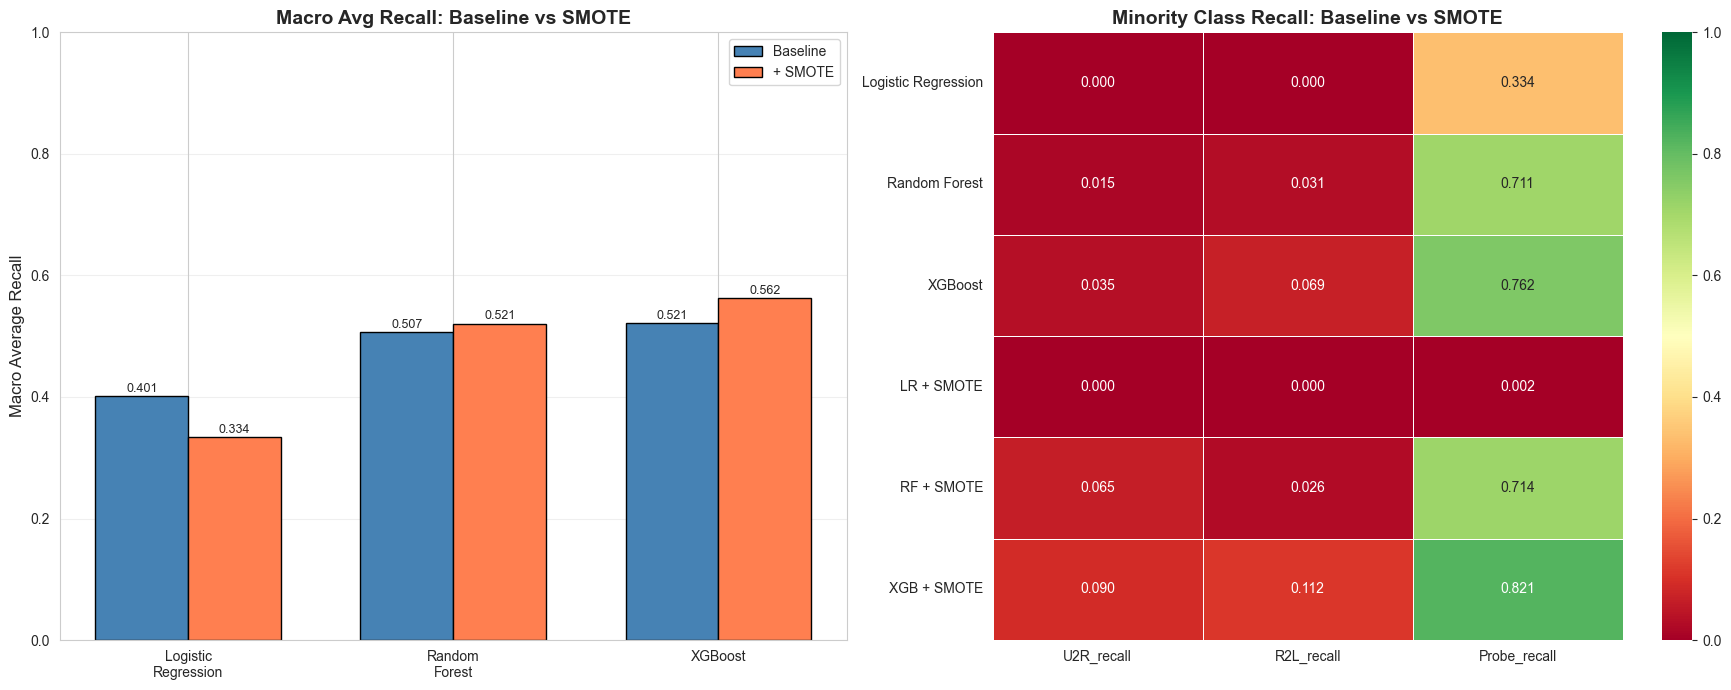


✅ SMOTE ANALYSIS COMPLETE


In [55]:
print("=" * 80)
print("CLASS IMBALANCE HANDLING - SMOTE")
print("=" * 80)

# 1. Current class distribution
print("\n📊 BEFORE SMOTE - Training set class distribution:")
print("-" * 60)
class_counts = Counter(y_train)
class_names = {0: 'DoS', 1: 'Normal', 2: 'Probe', 3: 'R2L', 4: 'U2R'}
total = sum(class_counts.values())
for cls in sorted(class_counts.keys()):
    count = class_counts[cls]
    print(f"   {class_names[cls]:>8} (class {cls}): {count:>6} samples ({count/total*100:>5.2f}%)")

# 2. Define SMOTE strategy
# Goal: Boost minority classes WITHOUT equalising to majority
# - Normal (67K) and DoS (45K) are fine as-is
# - Probe (11K) is borderline - leave as-is
# - R2L (~995) → oversample to ~5,000
# - U2R (~52) → oversample to ~2,000
# 
# Rationale: Bringing R2L/U2R to ~5-10% of majority gives the model
# enough signal without flooding it with synthetic samples

sampling_strategy = {
    0: class_counts[0],       # DoS - keep as-is
    1: class_counts[1],       # Normal - keep as-is
    2: class_counts[2],       # Probe - keep as-is
    3: 5000,                  # R2L - oversample from ~995
    4: 2000,                  # U2R - oversample from ~52
}

print(f"\n🎯 SMOTE STRATEGY:")
print("-" * 60)
for cls in sorted(sampling_strategy.keys()):
    before = class_counts[cls]
    after = sampling_strategy[cls]
    change = "→ no change" if before == after else f"→ {after} (+{after - before} synthetic)"
    print(f"   {class_names[cls]:>8}: {before:>6} {change}")

# 3. Apply SMOTE
# k_neighbors=5 is default; U2R has 52 samples so this is safe (need k < n_minority)
smote = SMOTE(
    sampling_strategy=sampling_strategy,
    k_neighbors=5,
    random_state=42
)

print("\nApplying SMOTE...")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 4. Verify results
print("\n📊 AFTER SMOTE - Training set class distribution:")
print("-" * 60)
class_counts_after = Counter(y_train_smote)
total_after = sum(class_counts_after.values())
for cls in sorted(class_counts_after.keys()):
    count = class_counts_after[cls]
    print(f"   {class_names[cls]:>8} (class {cls}): {count:>6} samples ({count/total_after*100:>5.2f}%)")

print(f"\n   Total samples: {total:,} → {total_after:,} (+{total_after - total:,})")
print(f"   New synthetic samples: {total_after - total:,}")

print("\n" + "=" * 80)
print("✅ SMOTE COMPLETE")
print("=" * 80)
print("   X_train_smote and y_train_smote ready for model training")
print("   X_test and y_test remain UNCHANGED (no synthetic test data)")


# ============================================================
# 9.1.1 RE-TRAIN MODELS WITH SMOTE DATA
# ============================================================

print("\n\n" + "=" * 80)
print("RE-TRAINING ALL MODELS WITH SMOTE DATA")
print("=" * 80)

# Reset results tracking for SMOTE models
model_results_smote = {
    'model_name': [],
    'macro_avg_recall': [],
    'macro_avg_f1': [],
    'roc_auc_macro': [],
    'accuracy': [],
    'macro_avg_precision': [],
    'DoS_precision': [], 'DoS_recall': [], 'DoS_f1': [],
    'Normal_precision': [], 'Normal_recall': [], 'Normal_f1': [],
    'Probe_precision': [], 'Probe_recall': [], 'Probe_f1': [],
    'R2L_precision': [], 'R2L_recall': [], 'R2L_f1': [],
    'U2R_precision': [], 'U2R_recall': [], 'U2R_f1': []
}

classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
target_names = ['DoS (0)', 'Normal (1)', 'Probe (2)', 'R2L (3)', 'U2R (4)']

def evaluate_and_store(model_name, y_true, y_pred, y_pred_proba, results_dict):
    """Evaluate model and store results (reusable helper)."""
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1, 2, 3, 4], zero_division=0
    )
    roc_auc_macro = roc_auc_score(y_true, y_pred_proba, 
                                   multi_class='ovr', average='macro')
    
    # Store
    results_dict['model_name'].append(model_name)
    results_dict['macro_avg_recall'].append(recall.mean())
    results_dict['macro_avg_f1'].append(f1.mean())
    results_dict['roc_auc_macro'].append(roc_auc_macro)
    results_dict['accuracy'].append(accuracy_score(y_true, y_pred))
    results_dict['macro_avg_precision'].append(precision.mean())
    
    for i, class_name in enumerate(classes):
        results_dict[f'{class_name}_precision'].append(precision[i])
        results_dict[f'{class_name}_recall'].append(recall[i])
        results_dict[f'{class_name}_f1'].append(f1[i])
    
    # Print summary
    print(f"\n🎯 PRIMARY METRICS:")
    print(f"   Macro Avg Recall: {recall.mean():.4f}")
    print(f"   Macro Avg F1:     {f1.mean():.4f}")
    print(f"   ROC-AUC (Macro):  {roc_auc_macro:.4f}")
    print(f"   Accuracy:         {accuracy_score(y_true, y_pred):.4f}")
    print(f"\n⚠️  MINORITY CLASS RECALL:")
    print(f"   R2L: {recall[3]:.4f}  |  U2R: {recall[4]:.4f}  |  Probe: {recall[2]:.4f}")
    
    return precision, recall, f1


# --- MODEL 1: LOGISTIC REGRESSION + SMOTE ---
print("\n" + "-" * 80)
print("LOGISTIC REGRESSION + SMOTE")
print("-" * 80)

lr_smote = LogisticRegression(max_iter=1000, random_state=42)
print("Training...")
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_lr_s = lr_smote.predict(X_test)
y_pred_proba_lr_s = lr_smote.predict_proba(X_test)
evaluate_and_store('LR + SMOTE', y_test, y_pred_lr_s, y_pred_proba_lr_s, model_results_smote)


# --- MODEL 2: RANDOM FOREST + SMOTE ---
print("\n" + "-" * 80)
print("RANDOM FOREST + SMOTE")
print("-" * 80)

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Training...")
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_s = rf_smote.predict(X_test)
y_pred_proba_rf_s = rf_smote.predict_proba(X_test)
evaluate_and_store('RF + SMOTE', y_test, y_pred_rf_s, y_pred_proba_rf_s, model_results_smote)


# --- MODEL 3: XGBOOST + SMOTE ---
print("\n" + "-" * 80)
print("XGBOOST + SMOTE")
print("-" * 80)

xgb_smote = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)
print("Training...")
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_s = xgb_smote.predict(X_test)
y_pred_proba_xgb_s = xgb_smote.predict_proba(X_test)
evaluate_and_store('XGB + SMOTE', y_test, y_pred_xgb_s, y_pred_proba_xgb_s, model_results_smote)


# ============================================================
# 9.1.2 COMPARE: BASELINE vs SMOTE
# ============================================================

print("\n\n" + "=" * 80)
print("COMPARISON: BASELINE vs SMOTE")
print("=" * 80)

# Combine baseline and SMOTE results
results_baseline = pd.DataFrame(model_results)
results_smote_df = pd.DataFrame(model_results_smote)

comparison = pd.concat([results_baseline, results_smote_df], ignore_index=True)

print("\n📊 OVERALL METRICS:")
print("-" * 80)
print(comparison[['model_name', 'macro_avg_recall', 'macro_avg_f1', 
                   'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n\n⚠️  MINORITY CLASS RECALL (The whole point of SMOTE!):")
print("-" * 80)
print(comparison[['model_name', 'R2L_recall', 'U2R_recall', 
                   'Probe_recall', 'DoS_recall']].to_string(index=False))


# ============================================================
# 9.1.3 VISUALIZATION - BASELINE vs SMOTE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Macro Recall comparison (bar chart)
ax1 = axes[0]
x = np.arange(3)
width = 0.35
baseline_recall = results_baseline['macro_avg_recall'].values
smote_recall = results_smote_df['macro_avg_recall'].values

bars1 = ax1.bar(x - width/2, baseline_recall, width, label='Baseline', color='steelblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, smote_recall, width, label='+ SMOTE', color='coral', edgecolor='black')

ax1.set_ylabel('Macro Average Recall', fontsize=12)
ax1.set_title('Macro Avg Recall: Baseline vs SMOTE', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Logistic\nRegression', 'Random\nForest', 'XGBoost'])
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    ax1.annotate(f'{bar.get_height():.3f}', 
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
for bar in bars2:
    ax1.annotate(f'{bar.get_height():.3f}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# 2. Minority class recall heatmap
ax2 = axes[1]
minority_data = comparison[['model_name', 'U2R_recall', 'R2L_recall', 'Probe_recall']].set_index('model_name')
sns.heatmap(minority_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax2, linewidths=0.5)
ax2.set_title('Minority Class Recall: Baseline vs SMOTE', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("✅ SMOTE ANALYSIS COMPLETE")
print("=" * 80)

COST-SENSITIVE LEARNING - ADDRESSING CLASS IMBALANCE

📊 'balanced' CLASS WEIGHTS (auto-computed):
------------------------------------------------------------
        DoS:     0.55x
     Normal:     0.37x
      Probe:     2.16x
        R2L:    25.32x
        U2R:   484.51x

Interpretation: Each U2R misclassification costs ~484x more
than a Normal misclassification during training.


APPROACH A: CLASS_WEIGHT='BALANCED' (No SMOTE)

--------------------------------------------------------------------------------
LOGISTIC REGRESSION + BALANCED WEIGHTS
--------------------------------------------------------------------------------
Training...

🎯 PRIMARY METRICS:
   Macro Avg Recall: 0.4494
   Macro Avg F1:     0.4288
   ROC-AUC (Macro):  0.7747
   Accuracy:         0.5078

⚠️  MINORITY CLASS RECALL:
   R2L: 0.2596  |  U2R: 0.4550  |  Probe: 0.3486

--------------------------------------------------------------------------------
RANDOM FOREST + BALANCED WEIGHTS
-----------------------------

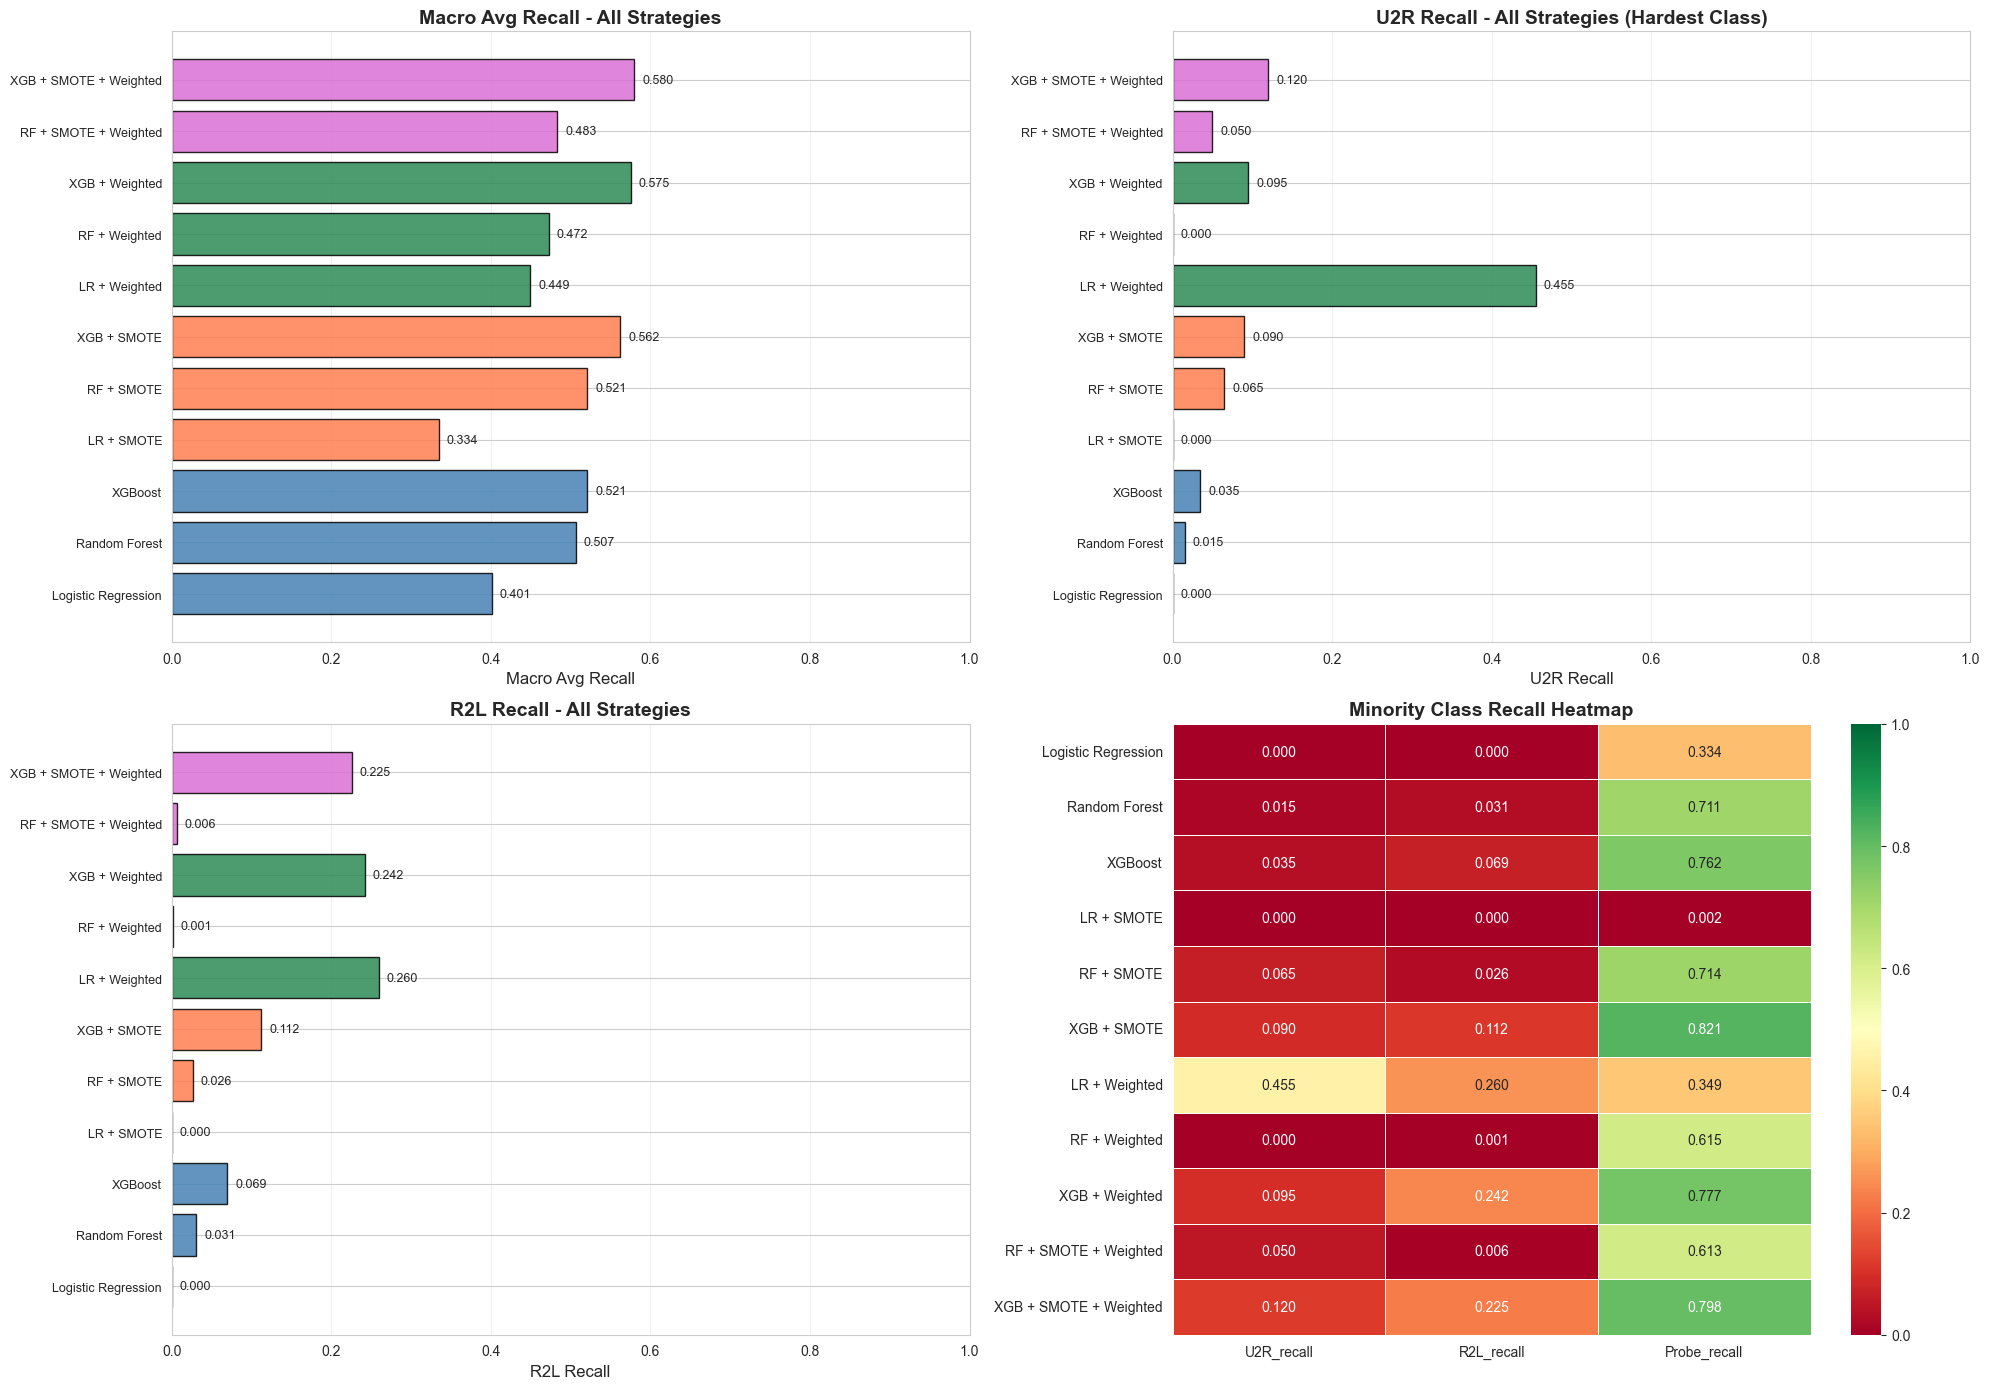



BEST MODEL BY METRIC
   Best Overall Minority Detection               → XGB + SMOTE + Weighted (0.5799)
   Best Overall Balance (Precision + Recall)     → XGB + SMOTE + Weighted (0.6132)
   Best U2R Detection                            → LR + Weighted (0.4550)
   Best R2L Detection                            → LR + Weighted (0.2596)
   Best Discrimination (AUC)                     → XGB + Weighted (0.9524)
   Best Raw Accuracy                             → XGB + Weighted (0.7941)

✅ COST-SENSITIVE ANALYSIS COMPLETE


In [ ]:
# ============================================================
# 9.1.4 COST-SENSITIVE LEARNING
# ============================================================
# SMOTE showed modest improvement for minority classes.
# Now test whether penalizing minority misclassification 
# (cost-sensitive learning) works better — alone and combined.
#
# Three approaches:
#   A) class_weight='balanced' alone (no SMOTE)
#   B) SMOTE + class_weight='balanced' together
#   C) Custom aggressive weights (manual)
# ============================================================
print("=" * 80)
print("COST-SENSITIVE LEARNING - ADDRESSING CLASS IMBALANCE")
print("=" * 80)

# Show what 'balanced' weights look like for our data
balanced_weights = compute_class_weight('balanced', 
                                         classes=np.unique(y_train), 
                                         y=y_train)
class_names = {0: 'DoS', 1: 'Normal', 2: 'Probe', 3: 'R2L', 4: 'U2R'}
print("\n📊 'balanced' CLASS WEIGHTS (auto-computed):")
print("-" * 60)
for cls, weight in zip(sorted(class_names.keys()), balanced_weights):
    print(f"   {class_names[cls]:>8}: {weight:>8.2f}x")
print("\nInterpretation: Each U2R misclassification costs ~484x more")
print("than a Normal misclassification during training.")


# ============================================================
# APPROACH A: class_weight='balanced' ALONE (original data)
# ============================================================

print("\n\n" + "=" * 80)
print("APPROACH A: CLASS_WEIGHT='BALANCED' (No SMOTE)")
print("=" * 80)

# --- Logistic Regression ---
print("\n" + "-" * 80)
print("LOGISTIC REGRESSION + BALANCED WEIGHTS")
print("-" * 80)

lr_weighted = LogisticRegression(
    max_iter=1000, random_state=42, class_weight='balanced'
)
print("Training...")
lr_weighted.fit(X_train, y_train)
y_pred_lr_w = lr_weighted.predict(X_test)
y_pred_proba_lr_w = lr_weighted.predict_proba(X_test)
evaluate_and_store('LR + Weighted', y_test, y_pred_lr_w, y_pred_proba_lr_w, model_results_smote)

# --- Random Forest ---
print("\n" + "-" * 80)
print("RANDOM FOREST + BALANCED WEIGHTS")
print("-" * 80)

rf_weighted = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'
)
print("Training...")
rf_weighted.fit(X_train, y_train)
y_pred_rf_w = rf_weighted.predict(X_test)
y_pred_proba_rf_w = rf_weighted.predict_proba(X_test)
evaluate_and_store('RF + Weighted', y_test, y_pred_rf_w, y_pred_proba_rf_w, model_results_smote)

# --- XGBoost (uses sample_weight instead of class_weight) ---
print("\n" + "-" * 80)
print("XGBOOST + BALANCED WEIGHTS")
print("-" * 80)

sample_weights_train = compute_sample_weight('balanced', y_train)

xgb_weighted = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6,
    random_state=42, eval_metric='mlogloss', verbosity=0
)
print("Training...")
xgb_weighted.fit(X_train, y_train, sample_weight=sample_weights_train)
y_pred_xgb_w = xgb_weighted.predict(X_test)
y_pred_proba_xgb_w = xgb_weighted.predict_proba(X_test)
evaluate_and_store('XGB + Weighted', y_test, y_pred_xgb_w, y_pred_proba_xgb_w, model_results_smote)


# ============================================================
# APPROACH B: SMOTE + class_weight='balanced' TOGETHER
# ============================================================

print("\n\n" + "=" * 80)
print("APPROACH B: SMOTE + CLASS_WEIGHT='BALANCED' (Combined)")
print("=" * 80)

# --- Random Forest ---
print("\n" + "-" * 80)
print("RANDOM FOREST + SMOTE + BALANCED WEIGHTS")
print("-" * 80)

rf_both = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'
)
print("Training...")
rf_both.fit(X_train_smote, y_train_smote)
y_pred_rf_b = rf_both.predict(X_test)
y_pred_proba_rf_b = rf_both.predict_proba(X_test)
evaluate_and_store('RF + SMOTE + Weighted', y_test, y_pred_rf_b, y_pred_proba_rf_b, model_results_smote)

# --- XGBoost ---
print("\n" + "-" * 80)
print("XGBOOST + SMOTE + BALANCED WEIGHTS")
print("-" * 80)

sample_weights_smote = compute_sample_weight('balanced', y_train_smote)

xgb_both = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6,
    random_state=42, eval_metric='mlogloss', verbosity=0
)
print("Training...")
xgb_both.fit(X_train_smote, y_train_smote, sample_weight=sample_weights_smote)
y_pred_xgb_b = xgb_both.predict(X_test)
y_pred_proba_xgb_b = xgb_both.predict_proba(X_test)
evaluate_and_store('XGB + SMOTE + Weighted', y_test, y_pred_xgb_b, y_pred_proba_xgb_b, model_results_smote)


# ============================================================
# FULL COMPARISON TABLE - ALL VARIANTS
# ============================================================

print("\n\n" + "=" * 80)
print("FULL COMPARISON: ALL IMBALANCE STRATEGIES")
print("=" * 80)

# Combine everything
all_results = pd.concat([
    pd.DataFrame(model_results),       # Original baselines
    pd.DataFrame(model_results_smote)   # All SMOTE + weighted variants
], ignore_index=True)

print("\n📊 OVERALL METRICS:")
print("-" * 100)
print(all_results[['model_name', 'macro_avg_recall', 'macro_avg_f1', 
                    'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n\n⚠️  MINORITY CLASS RECALL:")
print("-" * 100)
print(all_results[['model_name', 'R2L_recall', 'U2R_recall', 
                    'Probe_recall', 'DoS_recall']].to_string(index=False))

print("\n\n📊 MINORITY CLASS F1 (Recall + Precision balance):")
print("-" * 100)
print(all_results[['model_name', 'R2L_f1', 'U2R_f1', 
                    'Probe_f1', 'DoS_f1']].to_string(index=False))


# ============================================================
# VISUALIZATION - FULL COMPARISON
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 1. Macro Avg Recall - All models
ax1 = axes[0, 0]
model_names = all_results['model_name'].values
colors = ['steelblue']*3 + ['coral']*3 + ['seagreen']*3 + ['orchid']*2
bars = ax1.barh(range(len(model_names)), all_results['macro_avg_recall'].values, 
                color=colors[:len(model_names)], edgecolor='black', alpha=0.85)
ax1.set_yticks(range(len(model_names)))
ax1.set_yticklabels(model_names, fontsize=9)
ax1.set_xlabel('Macro Avg Recall', fontsize=12)
ax1.set_title('Macro Avg Recall - All Strategies', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_results['macro_avg_recall'].values):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# 2. U2R Recall (hardest class)
ax2 = axes[0, 1]
bars = ax2.barh(range(len(model_names)), all_results['U2R_recall'].values,
                color=colors[:len(model_names)], edgecolor='black', alpha=0.85)
ax2.set_yticks(range(len(model_names)))
ax2.set_yticklabels(model_names, fontsize=9)
ax2.set_xlabel('U2R Recall', fontsize=12)
ax2.set_title('U2R Recall - All Strategies (Hardest Class)', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_results['U2R_recall'].values):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# 3. R2L Recall
ax3 = axes[1, 0]
bars = ax3.barh(range(len(model_names)), all_results['R2L_recall'].values,
                color=colors[:len(model_names)], edgecolor='black', alpha=0.85)
ax3.set_yticks(range(len(model_names)))
ax3.set_yticklabels(model_names, fontsize=9)
ax3.set_xlabel('R2L Recall', fontsize=12)
ax3.set_title('R2L Recall - All Strategies', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_results['R2L_recall'].values):
    ax3.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# 4. Heatmap - Minority class recall all models
ax4 = axes[1, 1]
heatmap_data = all_results[['model_name', 'U2R_recall', 'R2L_recall', 
                             'Probe_recall']].set_index('model_name')
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, ax=ax4, linewidths=0.5)
ax4.set_title('Minority Class Recall Heatmap', fontsize=14, fontweight='bold')
ax4.set_ylabel('')

plt.tight_layout()
plt.savefig('imbalance_strategies_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================
# BEST MODEL IDENTIFICATION
# ============================================================

print("\n\n" + "=" * 80)
print("BEST MODEL BY METRIC")
print("=" * 80)

metrics_of_interest = {
    'macro_avg_recall': 'Best Overall Minority Detection',
    'macro_avg_f1': 'Best Overall Balance (Precision + Recall)',
    'U2R_recall': 'Best U2R Detection',
    'R2L_recall': 'Best R2L Detection',
    'roc_auc_macro': 'Best Discrimination (AUC)',
    'accuracy': 'Best Raw Accuracy'
}

for metric, description in metrics_of_interest.items():
    best_idx = all_results[metric].idxmax()
    best_model = all_results.loc[best_idx, 'model_name']
    best_val = all_results.loc[best_idx, metric]
    print(f"   {description:<45} → {best_model} ({metric} = {best_val:.4f})")

print("\n" + "=" * 80)
print("✅ COST-SENSITIVE ANALYSIS COMPLETE")
print("=" * 80)

APPROACH C: CUSTOM CYBERSECURITY-MOTIVATED WEIGHTS

📊 WEIGHT COMPARISON:
------------------------------------------------------------
   Class          Balanced       Custom  Rationale
------------------------------------------------------------
   DoS                0.55          0.3  Recoverable, suppress slightly
   Normal             0.37          0.3  Lowest risk, suppress slightly
   Probe              2.16          2.0  Keep stable
   R2L               25.32         50.0  2x balanced - serious breach
   U2R              484.51       1000.0  2x balanced - catastrophic breach

--------------------------------------------------------------------------------
LOGISTIC REGRESSION + CUSTOM WEIGHTS
--------------------------------------------------------------------------------
Training...

🎯 PRIMARY METRICS:
   Macro Avg Recall: 0.3427
   Macro Avg F1:     0.2270
   ROC-AUC (Macro):  0.6694
   Accuracy:         0.1885

⚠️  MINORITY CLASS RECALL:
   R2L: 0.2702  |  U2R: 0.8900  |  Probe

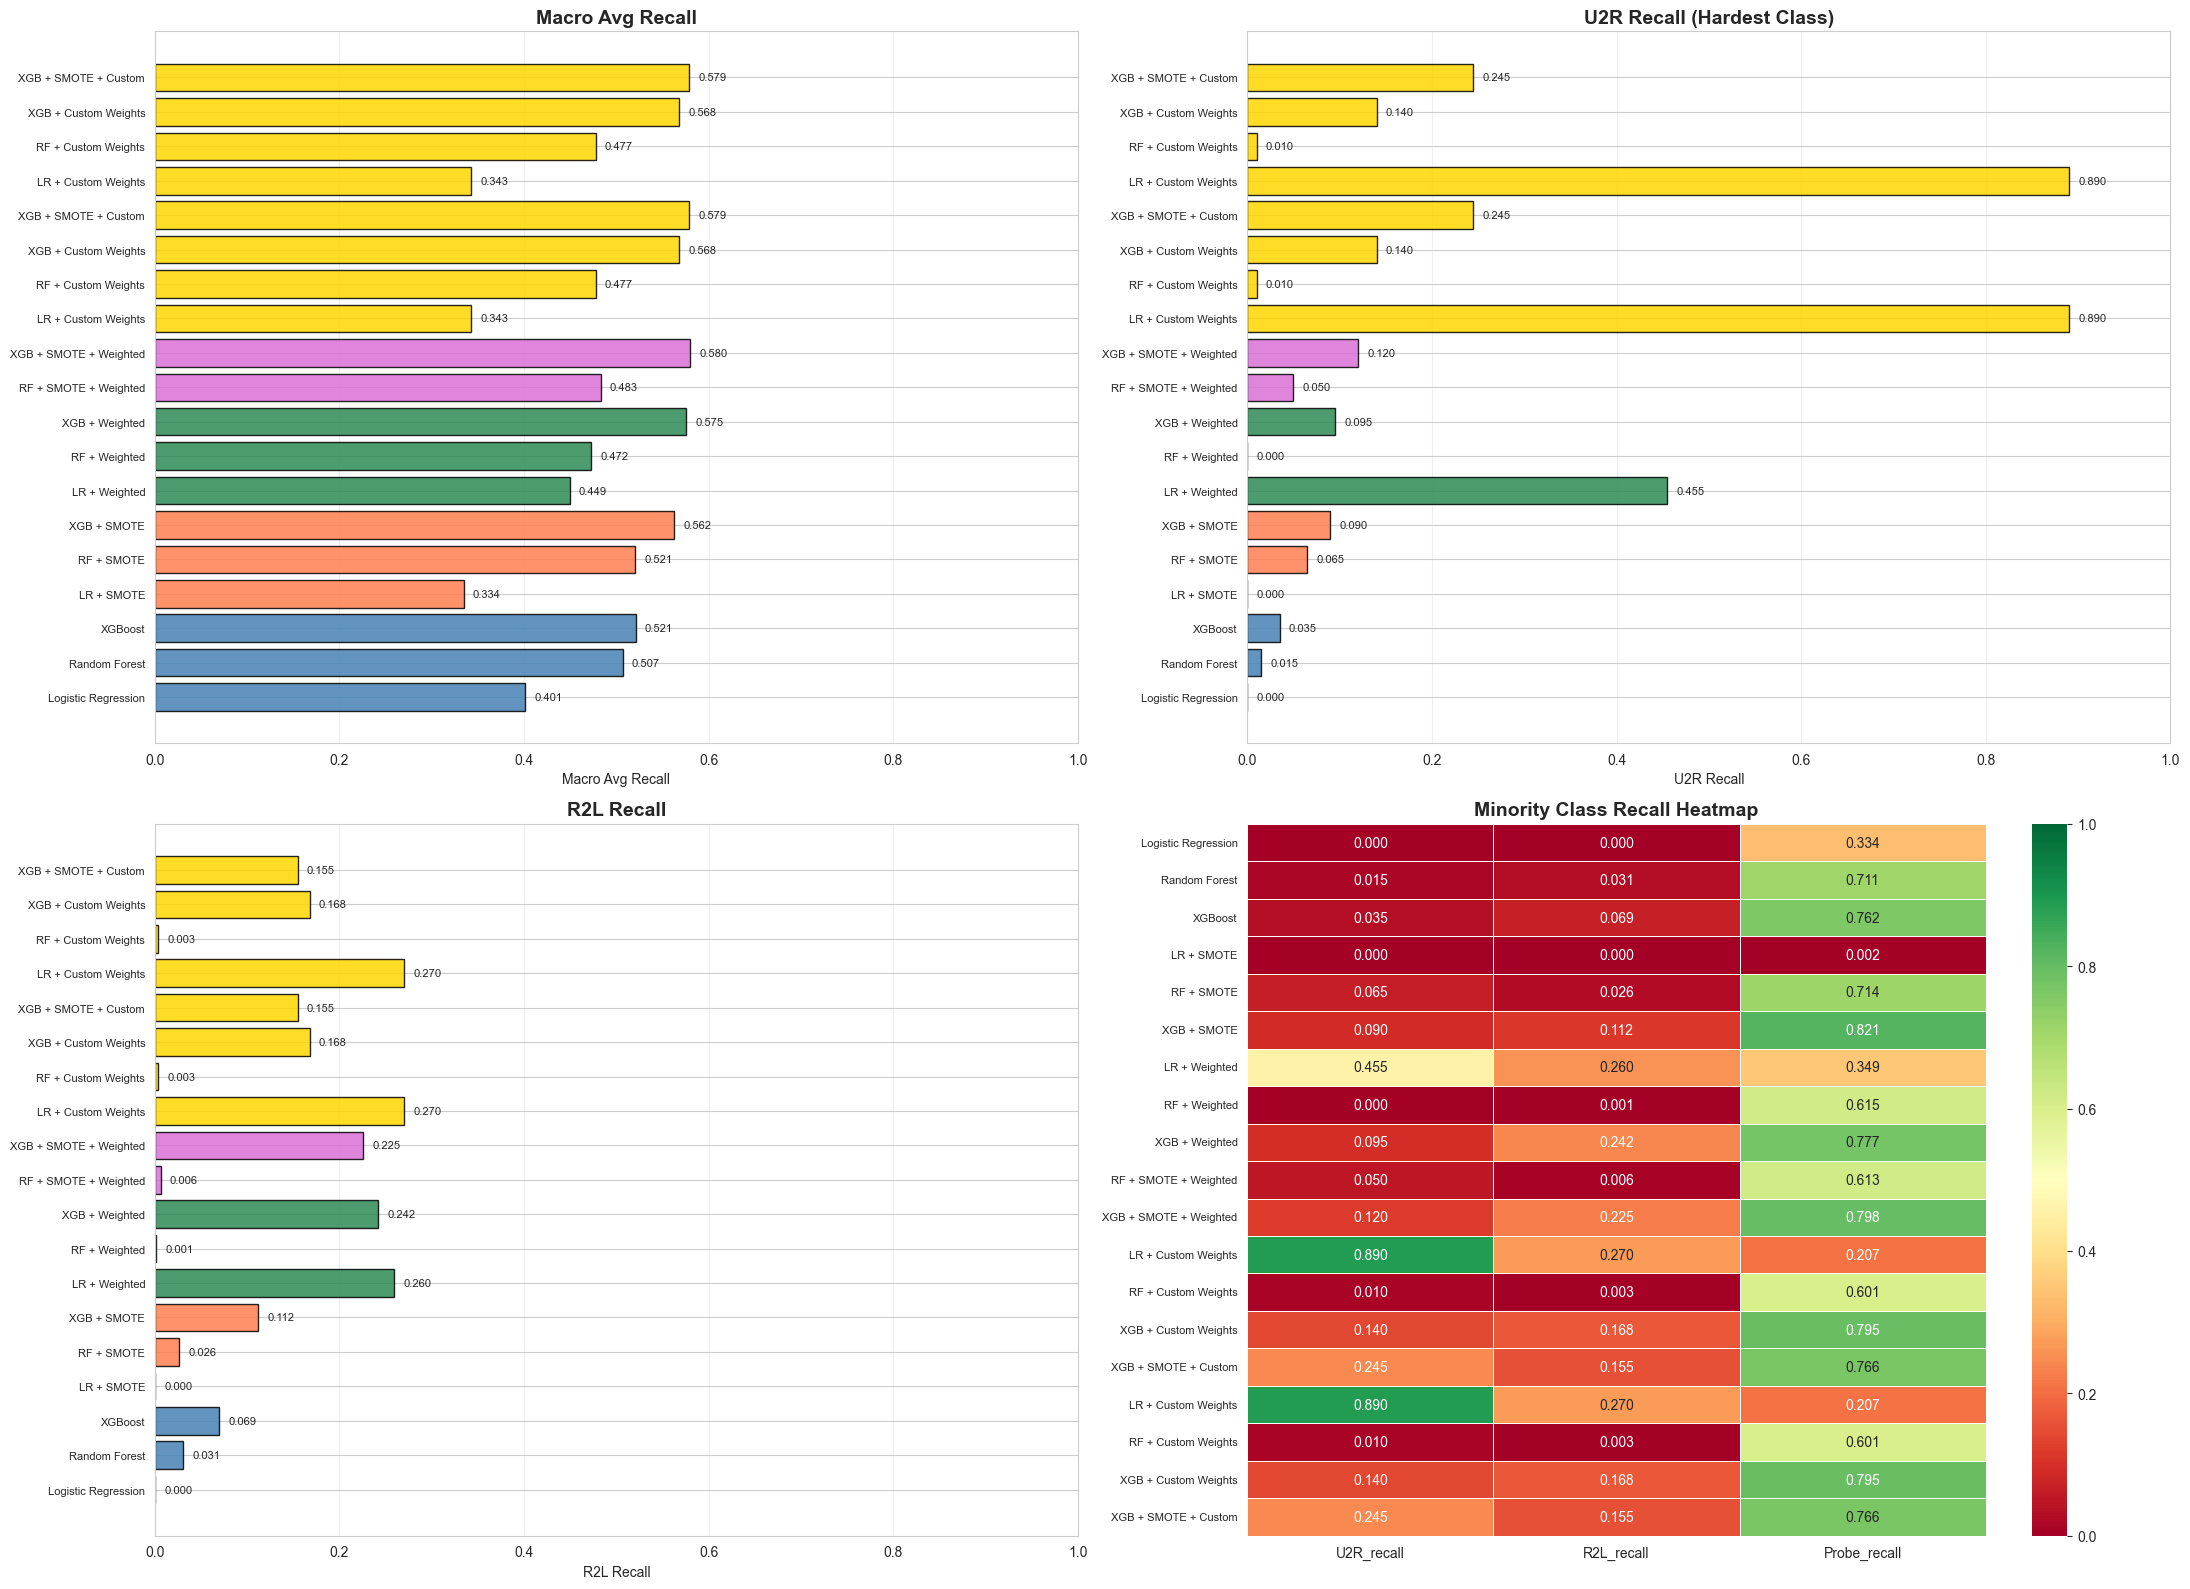


🎨 COLOUR KEY:
   🔵 Blue    = Baseline (no rebalancing)
   🟠 Coral   = SMOTE only
   🟢 Green   = Class weights only
   🟣 Purple  = SMOTE + balanced weights
   🟡 Gold    = Custom weights


BEST MODEL BY METRIC (FINAL)
   Best Overall Minority Detection               → XGB + SMOTE + Weighted (macro_avg_recall = 0.5799)
   Best Overall Balance (Precision + Recall)     → XGB + SMOTE + Weighted (macro_avg_f1 = 0.6132)
   Best U2R Detection                            → LR + Custom Weights (U2R_recall = 0.8900)
   Best R2L Detection                            → LR + Custom Weights (R2L_recall = 0.2702)
   Best Discrimination (AUC)                     → XGB + Weighted (roc_auc_macro = 0.9524)
   Best Raw Accuracy                             → XGB + Weighted (accuracy = 0.7941)

✅ ALL IMBALANCE STRATEGIES COMPLETE

Ready for Section 9.2: Hyperparameter Tuning


In [59]:
# ============================================================
# 9.1.5 APPROACH C: CUSTOM AGGRESSIVE WEIGHTS
# ============================================================
# 'balanced' gave U2R ~484x weight. But in cybersecurity:
#   - U2R (root access) = catastrophic breach → weight MORE
#   - R2L (remote to local) = serious breach → weight MORE  
#   - DoS = disruptive but recoverable → weight LESS
#
# Strategy: Scale beyond 'balanced' for U2R/R2L, 
# slightly suppress DoS/Normal to compensate.
# ============================================================

print("=" * 80)
print("APPROACH C: CUSTOM CYBERSECURITY-MOTIVATED WEIGHTS")
print("=" * 80)

# Compare balanced vs custom weights
print("\n📊 WEIGHT COMPARISON:")
print("-" * 60)
print(f"   {'Class':<10} {'Balanced':>12} {'Custom':>12}  {'Rationale'}")
print("-" * 60)

# Custom weights: push U2R and R2L harder
custom_weights = {
    0: 0.3,      # DoS - lower than balanced (0.55), recoverable attack
    1: 0.3,      # Normal - lower than balanced (0.37), least costly to misclassify
    2: 2.0,      # Probe - similar to balanced (2.16), keep stable
    3: 50.0,     # R2L - 2x balanced (25.32), serious breach
    4: 1000.0,   # U2R - 2x balanced (484.51), catastrophic breach
}

balanced_display = {0: 0.55, 1: 0.37, 2: 2.16, 3: 25.32, 4: 484.51}
rationales = {
    0: 'Recoverable, suppress slightly',
    1: 'Lowest risk, suppress slightly', 
    2: 'Keep stable',
    3: '2x balanced - serious breach',
    4: '2x balanced - catastrophic breach'
}

for cls in sorted(custom_weights.keys()):
    print(f"   {class_names[cls]:<10} {balanced_display[cls]:>12.2f} {custom_weights[cls]:>12.1f}  {rationales[cls]}")


# --- Logistic Regression + Custom Weights ---
print("\n" + "-" * 80)
print("LOGISTIC REGRESSION + CUSTOM WEIGHTS")
print("-" * 80)

lr_custom = LogisticRegression(
    max_iter=1000, random_state=42, class_weight=custom_weights
)
print("Training...")
lr_custom.fit(X_train, y_train)
y_pred_lr_c = lr_custom.predict(X_test)
y_pred_proba_lr_c = lr_custom.predict_proba(X_test)
evaluate_and_store('LR + Custom Weights', y_test, y_pred_lr_c, y_pred_proba_lr_c, model_results_smote)


# --- Random Forest + Custom Weights ---
print("\n" + "-" * 80)
print("RANDOM FOREST + CUSTOM WEIGHTS")
print("-" * 80)

rf_custom = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=-1, class_weight=custom_weights
)
print("Training...")
rf_custom.fit(X_train, y_train)
y_pred_rf_c = rf_custom.predict(X_test)
y_pred_proba_rf_c = rf_custom.predict_proba(X_test)
evaluate_and_store('RF + Custom Weights', y_test, y_pred_rf_c, y_pred_proba_rf_c, model_results_smote)


# --- XGBoost + Custom Weights (via sample_weight) ---
print("\n" + "-" * 80)
print("XGBOOST + CUSTOM WEIGHTS")
print("-" * 80)

# Convert class weights to per-sample weights for XGBoost
custom_sample_weights = np.array([custom_weights[y] for y in y_train])

xgb_custom = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6,
    random_state=42, eval_metric='mlogloss', verbosity=0
)
print("Training...")
xgb_custom.fit(X_train, y_train, sample_weight=custom_sample_weights)
y_pred_xgb_c = xgb_custom.predict(X_test)
y_pred_proba_xgb_c = xgb_custom.predict_proba(X_test)
evaluate_and_store('XGB + Custom Weights', y_test, y_pred_xgb_c, y_pred_proba_xgb_c, model_results_smote)


# --- XGBoost + SMOTE + Custom Weights ---
print("\n" + "-" * 80)
print("XGBOOST + SMOTE + CUSTOM WEIGHTS")
print("-" * 80)

custom_sample_weights_smote = np.array([custom_weights[y] for y in y_train_smote])

xgb_custom_smote = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6,
    random_state=42, eval_metric='mlogloss', verbosity=0
)
print("Training...")
xgb_custom_smote.fit(X_train_smote, y_train_smote, sample_weight=custom_sample_weights_smote)
y_pred_xgb_cs = xgb_custom_smote.predict(X_test)
y_pred_proba_xgb_cs = xgb_custom_smote.predict_proba(X_test)
evaluate_and_store('XGB + SMOTE + Custom', y_test, y_pred_xgb_cs, y_pred_proba_xgb_cs, model_results_smote)


# ============================================================
# UPDATED FULL COMPARISON
# ============================================================

print("\n\n" + "=" * 80)
print("FULL COMPARISON: ALL IMBALANCE STRATEGIES (UPDATED)")
print("=" * 80)

all_results = pd.concat([
    pd.DataFrame(model_results),
    pd.DataFrame(model_results_smote)
], ignore_index=True)

print("\n📊 OVERALL METRICS:")
print("-" * 100)
print(all_results[['model_name', 'macro_avg_recall', 'macro_avg_f1', 
                    'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n\n⚠️  MINORITY CLASS RECALL:")
print("-" * 100)
print(all_results[['model_name', 'R2L_recall', 'U2R_recall', 
                    'Probe_recall', 'DoS_recall']].to_string(index=False))

print("\n\n📊 MINORITY CLASS F1:")
print("-" * 100)
print(all_results[['model_name', 'R2L_f1', 'U2R_f1', 
                    'Probe_f1', 'DoS_f1']].to_string(index=False))


# ============================================================
# UPDATED VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(22, 16))

# Color coding by strategy
n_models = len(all_results)
color_map = []
for name in all_results['model_name']:
    if 'Custom' in name:
        color_map.append('gold')
    elif 'SMOTE' in name and 'Weighted' in name:
        color_map.append('orchid')
    elif 'Weighted' in name:
        color_map.append('seagreen')
    elif 'SMOTE' in name:
        color_map.append('coral')
    else:
        color_map.append('steelblue')

# 1. Macro Avg Recall
ax1 = axes[0, 0]
ax1.barh(range(n_models), all_results['macro_avg_recall'].values,
         color=color_map, edgecolor='black', alpha=0.85)
ax1.set_yticks(range(n_models))
ax1.set_yticklabels(all_results['model_name'].values, fontsize=8)
ax1.set_xlabel('Macro Avg Recall')
ax1.set_title('Macro Avg Recall', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_results['macro_avg_recall'].values):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# 2. U2R Recall
ax2 = axes[0, 1]
ax2.barh(range(n_models), all_results['U2R_recall'].values,
         color=color_map, edgecolor='black', alpha=0.85)
ax2.set_yticks(range(n_models))
ax2.set_yticklabels(all_results['model_name'].values, fontsize=8)
ax2.set_xlabel('U2R Recall')
ax2.set_title('U2R Recall (Hardest Class)', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_results['U2R_recall'].values):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# 3. R2L Recall
ax3 = axes[1, 0]
ax3.barh(range(n_models), all_results['R2L_recall'].values,
         color=color_map, edgecolor='black', alpha=0.85)
ax3.set_yticks(range(n_models))
ax3.set_yticklabels(all_results['model_name'].values, fontsize=8)
ax3.set_xlabel('R2L Recall')
ax3.set_title('R2L Recall', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.grid(axis='x', alpha=0.3)
for i, v in enumerate(all_results['R2L_recall'].values):
    ax3.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# 4. Legend + Heatmap
ax4 = axes[1, 1]
heatmap_data = all_results[['model_name', 'U2R_recall', 'R2L_recall',
                             'Probe_recall']].set_index('model_name')
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, ax=ax4, linewidths=0.5)
ax4.set_title('Minority Class Recall Heatmap', fontsize=14, fontweight='bold')
ax4.set_ylabel('')
ax4.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.savefig('all_imbalance_strategies.png', dpi=300, bbox_inches='tight')
plt.show()

# Legend
print("\n🎨 COLOUR KEY:")
print("   🔵 Blue    = Baseline (no rebalancing)")
print("   🟠 Coral   = SMOTE only")
print("   🟢 Green   = Class weights only")
print("   🟣 Purple  = SMOTE + balanced weights")
print("   🟡 Gold    = Custom weights")


# ============================================================
# BEST MODEL SUMMARY
# ============================================================

print("\n\n" + "=" * 80)
print("BEST MODEL BY METRIC (FINAL)")
print("=" * 80)

metrics_of_interest = {
    'macro_avg_recall': 'Best Overall Minority Detection',
    'macro_avg_f1': 'Best Overall Balance (Precision + Recall)',
    'U2R_recall': 'Best U2R Detection',
    'R2L_recall': 'Best R2L Detection',
    'roc_auc_macro': 'Best Discrimination (AUC)',
    'accuracy': 'Best Raw Accuracy'
}

for metric, description in metrics_of_interest.items():
    best_idx = all_results[metric].idxmax()
    best_model = all_results.loc[best_idx, 'model_name']
    best_val = all_results.loc[best_idx, metric]
    print(f"   {description:<45} → {best_model} ({metric} = {best_val:.4f})")

print("\n" + "=" * 80)
print("✅ ALL IMBALANCE STRATEGIES COMPLETE")
print("=" * 80)
print("\nReady for Section 9.2: Hyperparameter Tuning")

## 9.2 Hyperparameter Tuning

SECTION 8.4: HYPERPARAMETER TUNING

📋 SEARCH SPACE:
------------------------------------------------------------
   max_depth           : [3, 4, 5, 6, 7, 8, 10]
   n_estimators        : [100, 200, 300, 500]
   learning_rate       : [0.01, 0.05, 0.1, 0.2, 0.3]
   min_child_weight    : [1, 3, 5, 7, 10]
   subsample           : [0.6, 0.7, 0.8, 0.9, 1.0]
   colsample_bytree    : [0.6, 0.7, 0.8, 0.9, 1.0]
   gamma               : [0, 0.1, 0.2, 0.5, 1.0]
   reg_alpha           : [0, 0.01, 0.1, 1.0]
   reg_lambda          : [0.5, 1.0, 2.0, 5.0]

   Total possible combinations: 1,400,000
   Sampling: 100 random combinations × 3-fold CV = 300 fits per model

📊 Scoring metric: macro F1-score
   Rationale: Balances recall (detection) with precision (false alarms)
              across all 5 classes equally

TUNING MODEL 1: XGB + Weighted

   Training samples: 125,973
   Features: 47
   Using balanced sample weights on original data

   Starting RandomizedSearchCV (100 iterations, 3-fold CV)...
Fit

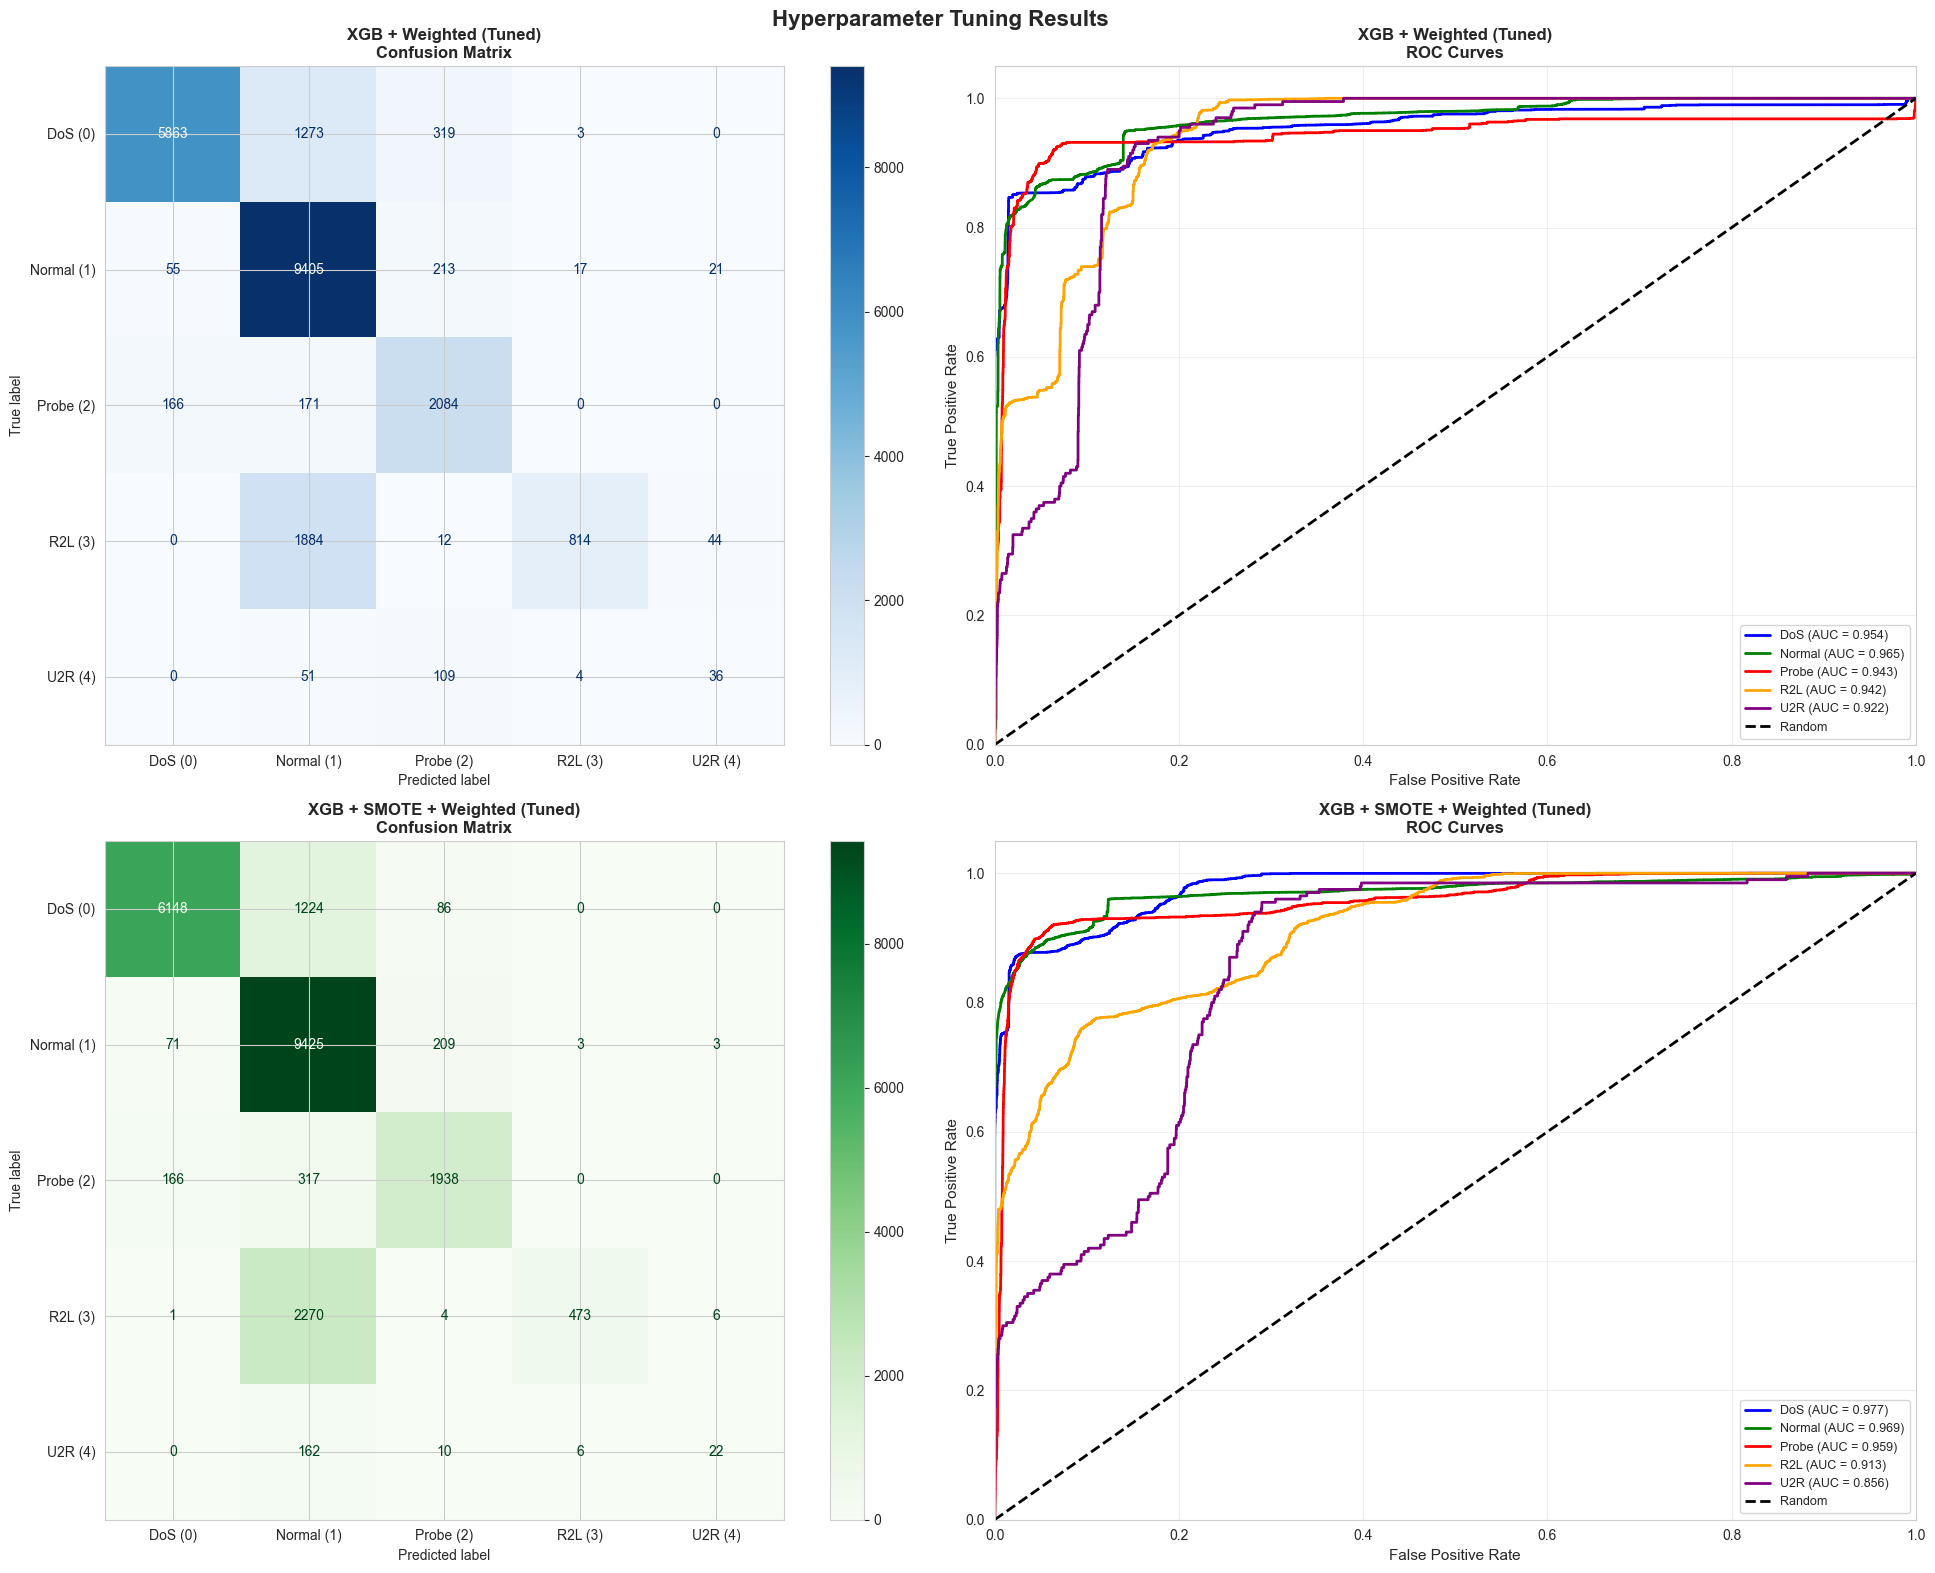


BEST PARAMETERS COMPARISON
       Parameter  XGB + Weighted  XGB + SMOTE + Weighted
colsample_bytree            0.80                    0.80
           gamma            0.00                    0.10
   learning_rate            0.01                    0.30
       max_depth            6.00                   10.00
min_child_weight            7.00                    5.00
    n_estimators          200.00                  200.00
       reg_alpha            0.10                    0.01
      reg_lambda            2.00                    5.00
       subsample            1.00                    0.60

✅ HYPERPARAMETER TUNING COMPLETE

   Total tuning time: 94.3 minutes
   Models evaluated: 2 × 100 combinations × 3-fold CV = 600 fits

   Results stored in model_results dictionary
   Visualizations saved to hyperparameter_tuning_results.png

   Ready for Section 9: Final Model Selection


In [66]:
# Tuning the two strongest candidates from imbalance strategies:
#   1. XGB + Weighted (best AUC 0.952, best accuracy 0.794)
#   2. XGB + SMOTE + Weighted (best macro recall 0.580, best macro F1 0.613)
# ============================================================
print("=" * 80)
print("SECTION 8.4: HYPERPARAMETER TUNING")
print("=" * 80)

# ============================================================
# HYPERPARAMETER SEARCH SPACE
# ============================================================

param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 2.0, 5.0],
}

print("\n📋 SEARCH SPACE:")
print("-" * 60)
for param, values in param_distributions.items():
    print(f"   {param:<20s}: {values}")

total_combinations = 1
for v in param_distributions.values():
    total_combinations *= len(v)
print(f"\n   Total possible combinations: {total_combinations:,}")
print(f"   Sampling: 100 random combinations × 3-fold CV = 300 fits per model")

# ============================================================
# SCORING: Use macro F1 as primary (balances recall + precision)
# ============================================================

scorer = make_scorer(f1_score, average='macro')
print(f"\n📊 Scoring metric: macro F1-score")
print(f"   Rationale: Balances recall (detection) with precision (false alarms)")
print(f"              across all 5 classes equally")

# ============================================================
# MODEL 1: XGB + WEIGHTED (TUNED)
# ============================================================

print("\n" + "=" * 80)
print("TUNING MODEL 1: XGB + Weighted")
print("=" * 80)

# Compute balanced sample weights for original training data
sample_weights_orig = compute_sample_weight('balanced', y_train)

print(f"\n   Training samples: {X_train.shape[0]:,}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Using balanced sample weights on original data")
print(f"\n   Starting RandomizedSearchCV (100 iterations, 3-fold CV)...")

start_time = time.time()

xgb_weighted_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',        # Fast histogram-based method
        n_jobs=-1
    ),
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scorer,
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit with sample weights
xgb_weighted_search.fit(X_train, y_train, sample_weight=sample_weights_orig)

elapsed_1 = time.time() - start_time
print(f"\n✅ Tuning complete in {elapsed_1/60:.1f} minutes")

# Best parameters
print(f"\n🏆 BEST PARAMETERS (XGB + Weighted):")
print("-" * 60)
for param, value in sorted(xgb_weighted_search.best_params_.items()):
    print(f"   {param:<20s}: {value}")
print(f"\n   Best CV macro F1: {xgb_weighted_search.best_score_:.4f}")

# Evaluate on test set
best_xgb_weighted = xgb_weighted_search.best_estimator_
y_pred_xgb_w_tuned = best_xgb_weighted.predict(X_test)
y_pred_proba_xgb_w_tuned = best_xgb_weighted.predict_proba(X_test)

# Metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_xgb_w_tuned, labels=[0, 1, 2, 3, 4], zero_division=0
)
roc_auc_macro = roc_auc_score(y_test, y_pred_proba_xgb_w_tuned,
                               multi_class='ovr', average='macro')

print(f"\n📊 TEST SET RESULTS (XGB + Weighted Tuned):")
print("-" * 60)
print(f"   Macro Avg Recall: {recall.mean():.4f}")
print(f"   Macro Avg F1:     {f1.mean():.4f}")
print(f"   ROC-AUC (Macro):  {roc_auc_macro:.4f}")
print(f"   Accuracy:         {accuracy_score(y_test, y_pred_xgb_w_tuned):.4f}")

print(f"\n⚠️  MINORITY CLASS RECALL:")
classes = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
for i, cls in enumerate(classes):
    print(f"   {cls}: {recall[i]:.4f}")

# Store results
model_results['model_name'].append('XGB + Weighted (Tuned)')
model_results['macro_avg_recall'].append(recall.mean())
model_results['macro_avg_f1'].append(f1.mean())
model_results['roc_auc_macro'].append(roc_auc_macro)
model_results['accuracy'].append(accuracy_score(y_test, y_pred_xgb_w_tuned))
model_results['macro_avg_precision'].append(precision.mean())
for i, class_name in enumerate(classes):
    model_results[f'{class_name}_precision'].append(precision[i])
    model_results[f'{class_name}_recall'].append(recall[i])
    model_results[f'{class_name}_f1'].append(f1[i])

# Full classification report
print("\n" + "-" * 80)
print("Detailed Classification Report:")
print("-" * 80)
target_names = ['DoS (0)', 'Normal (1)', 'Probe (2)', 'R2L (3)', 'U2R (4)']
print(classification_report(y_test, y_pred_xgb_w_tuned, target_names=target_names, digits=4))

# ============================================================
# MODEL 2: XGB + SMOTE + WEIGHTED (TUNED)
# ============================================================

print("\n" + "=" * 80)
print("TUNING MODEL 2: XGB + SMOTE + Weighted")
print("=" * 80)

# Compute balanced sample weights for SMOTE training data
sample_weights_smote = compute_sample_weight('balanced', y_train_smote)

print(f"\n   Training samples: {X_train_smote.shape[0]:,} (includes SMOTE synthetic)")
print(f"   Features: {X_train_smote.shape[1]}")
print(f"   Using balanced sample weights on SMOTE data")
print(f"\n   Starting RandomizedSearchCV (100 iterations, 3-fold CV)...")

start_time = time.time()

xgb_smote_weighted_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',
        n_jobs=-1
    ),
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scorer,
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit with sample weights on SMOTE data
xgb_smote_weighted_search.fit(X_train_smote, y_train_smote, 
                               sample_weight=sample_weights_smote)

elapsed_2 = time.time() - start_time
print(f"\n✅ Tuning complete in {elapsed_2/60:.1f} minutes")

# Best parameters
print(f"\n🏆 BEST PARAMETERS (XGB + SMOTE + Weighted):")
print("-" * 60)
for param, value in sorted(xgb_smote_weighted_search.best_params_.items()):
    print(f"   {param:<20s}: {value}")
print(f"\n   Best CV macro F1: {xgb_smote_weighted_search.best_score_:.4f}")

# Evaluate on test set
best_xgb_smote_weighted = xgb_smote_weighted_search.best_estimator_
y_pred_xgb_sw_tuned = best_xgb_smote_weighted.predict(X_test)
y_pred_proba_xgb_sw_tuned = best_xgb_smote_weighted.predict_proba(X_test)

# Metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_xgb_sw_tuned, labels=[0, 1, 2, 3, 4], zero_division=0
)
roc_auc_macro = roc_auc_score(y_test, y_pred_proba_xgb_sw_tuned,
                               multi_class='ovr', average='macro')

print(f"\n📊 TEST SET RESULTS (XGB + SMOTE + Weighted Tuned):")
print("-" * 60)
print(f"   Macro Avg Recall: {recall.mean():.4f}")
print(f"   Macro Avg F1:     {f1.mean():.4f}")
print(f"   ROC-AUC (Macro):  {roc_auc_macro:.4f}")
print(f"   Accuracy:         {accuracy_score(y_test, y_pred_xgb_sw_tuned):.4f}")

print(f"\n⚠️  MINORITY CLASS RECALL:")
for i, cls in enumerate(classes):
    print(f"   {cls}: {recall[i]:.4f}")

# Store results
model_results['model_name'].append('XGB + SMOTE + Weighted (Tuned)')
model_results['macro_avg_recall'].append(recall.mean())
model_results['macro_avg_f1'].append(f1.mean())
model_results['roc_auc_macro'].append(roc_auc_macro)
model_results['accuracy'].append(accuracy_score(y_test, y_pred_xgb_sw_tuned))
model_results['macro_avg_precision'].append(precision.mean())
for i, class_name in enumerate(classes):
    model_results[f'{class_name}_precision'].append(precision[i])
    model_results[f'{class_name}_recall'].append(recall[i])
    model_results[f'{class_name}_f1'].append(f1[i])

# Full classification report
print("\n" + "-" * 80)
print("Detailed Classification Report:")
print("-" * 80)
print(classification_report(y_test, y_pred_xgb_sw_tuned, target_names=target_names, digits=4))

# ============================================================
# COMPARISON: PRE-TUNING vs POST-TUNING
# ============================================================

print("\n" + "=" * 80)
print("COMPARISON: PRE-TUNING vs POST-TUNING")
print("=" * 80)

# Get pre-tuning results from model_results
results_df = pd.DataFrame(model_results)

# Filter to the relevant models
compare_models = [
    'XGB + Weighted', 'XGB + Weighted (Tuned)',
    'XGB + SMOTE + Weighted', 'XGB + SMOTE + Weighted (Tuned)'
]
compare_df = results_df[results_df['model_name'].isin(compare_models)]

print("\n📊 OVERALL METRICS:")
print("-" * 100)
print(compare_df[['model_name', 'macro_avg_recall', 'macro_avg_f1',
                   'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n\n⚠️  MINORITY CLASS RECALL:")
print("-" * 100)
print(compare_df[['model_name', 'R2L_recall', 'U2R_recall',
                   'Probe_recall', 'DoS_recall']].to_string(index=False))

print("\n\n📊 MINORITY CLASS F1:")
print("-" * 100)
print(compare_df[['model_name', 'R2L_f1', 'U2R_f1',
                   'Probe_f1', 'DoS_f1']].to_string(index=False))

# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Hyperparameter Tuning Results', fontsize=16, fontweight='bold', y=0.98)

# --- Model 1: XGB + Weighted (Tuned) ---

# Confusion Matrix
ax1 = axes[0, 0]
cm1 = confusion_matrix(y_test, y_pred_xgb_w_tuned)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=target_names)
disp1.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('XGB + Weighted (Tuned)\nConfusion Matrix', fontsize=12, fontweight='bold')

# ROC Curves
ax2 = axes[0, 1]
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (color, class_name) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_xgb_w_tuned[:, i])
    roc_auc_i = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc_i:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('XGB + Weighted (Tuned)\nROC Curves', fontsize=12, fontweight='bold')
ax2.legend(loc="lower right", fontsize=9)
ax2.grid(alpha=0.3)

# --- Model 2: XGB + SMOTE + Weighted (Tuned) ---

# Confusion Matrix
ax3 = axes[1, 0]
cm2 = confusion_matrix(y_test, y_pred_xgb_sw_tuned)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=target_names)
disp2.plot(ax=ax3, cmap='Greens', values_format='d')
ax3.set_title('XGB + SMOTE + Weighted (Tuned)\nConfusion Matrix', fontsize=12, fontweight='bold')

# ROC Curves
ax4 = axes[1, 1]
for i, (color, class_name) in enumerate(zip(colors, classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_xgb_sw_tuned[:, i])
    roc_auc_i = auc(fpr, tpr)
    ax4.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc_i:.3f})')
ax4.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=11)
ax4.set_ylabel('True Positive Rate', fontsize=11)
ax4.set_title('XGB + SMOTE + Weighted (Tuned)\nROC Curves', fontsize=12, fontweight='bold')
ax4.legend(loc="lower right", fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# PARAMETER COMPARISON
# ============================================================

print("\n" + "=" * 80)
print("BEST PARAMETERS COMPARISON")
print("=" * 80)

params_compare = pd.DataFrame({
    'Parameter': sorted(xgb_weighted_search.best_params_.keys()),
    'XGB + Weighted': [xgb_weighted_search.best_params_[k] 
                       for k in sorted(xgb_weighted_search.best_params_.keys())],
    'XGB + SMOTE + Weighted': [xgb_smote_weighted_search.best_params_[k]
                                for k in sorted(xgb_smote_weighted_search.best_params_.keys())]
})
print(params_compare.to_string(index=False))

# ============================================================
# SUMMARY
# ============================================================

print("\n" + "=" * 80)
print("✅ HYPERPARAMETER TUNING COMPLETE")
print("=" * 80)
print(f"\n   Total tuning time: {(elapsed_1 + elapsed_2)/60:.1f} minutes")
print(f"   Models evaluated: 2 × 100 combinations × 3-fold CV = 600 fits")
print(f"\n   Results stored in model_results dictionary")
print(f"   Visualizations saved to hyperparameter_tuning_results.png")
print(f"\n   Ready for Section 9: Final Model Selection")

PRE-TUNING vs POST-TUNING COMPARISON

   XGB + Weighted → Tuned:
      macro_avg_recall    : 0.5754 → 0.6182 (↑ 0.0428)
      macro_avg_f1        : 0.6085 → 0.6405 (↑ 0.0320)
      roc_auc_macro       : 0.9524 → 0.9451 (↓ 0.0073)
      accuracy            : 0.7941 → 0.8074 (↑ 0.0133)
      R2L_recall          : 0.2418 → 0.2956 (↑ 0.0537)
      U2R_recall          : 0.0950 → 0.1800 (↑ 0.0850)
      Probe_recall        : 0.7770 → 0.8608 (↑ 0.0838)
      DoS_recall          : 0.7923 → 0.7861 (↓ 0.0062)

   XGB + SMOTE + Weighted → Tuned:
      macro_avg_recall    : 0.5799 → 0.5754 (↓ 0.0045)
      macro_avg_f1        : 0.6132 → 0.6034 (↓ 0.0098)
      roc_auc_macro       : 0.9500 → 0.9348 (↓ 0.0152)
      accuracy            : 0.7923 → 0.7987 (↑ 0.0064)
      R2L_recall          : 0.2255 → 0.1718 (↓ 0.0537)
      U2R_recall          : 0.1200 → 0.1100 (↓ 0.0100)
      Probe_recall        : 0.7984 → 0.8005 (↑ 0.0021)
      DoS_recall          : 0.7840 → 0.8243 (↑ 0.0404)


PER-CLASS ROC-AUC

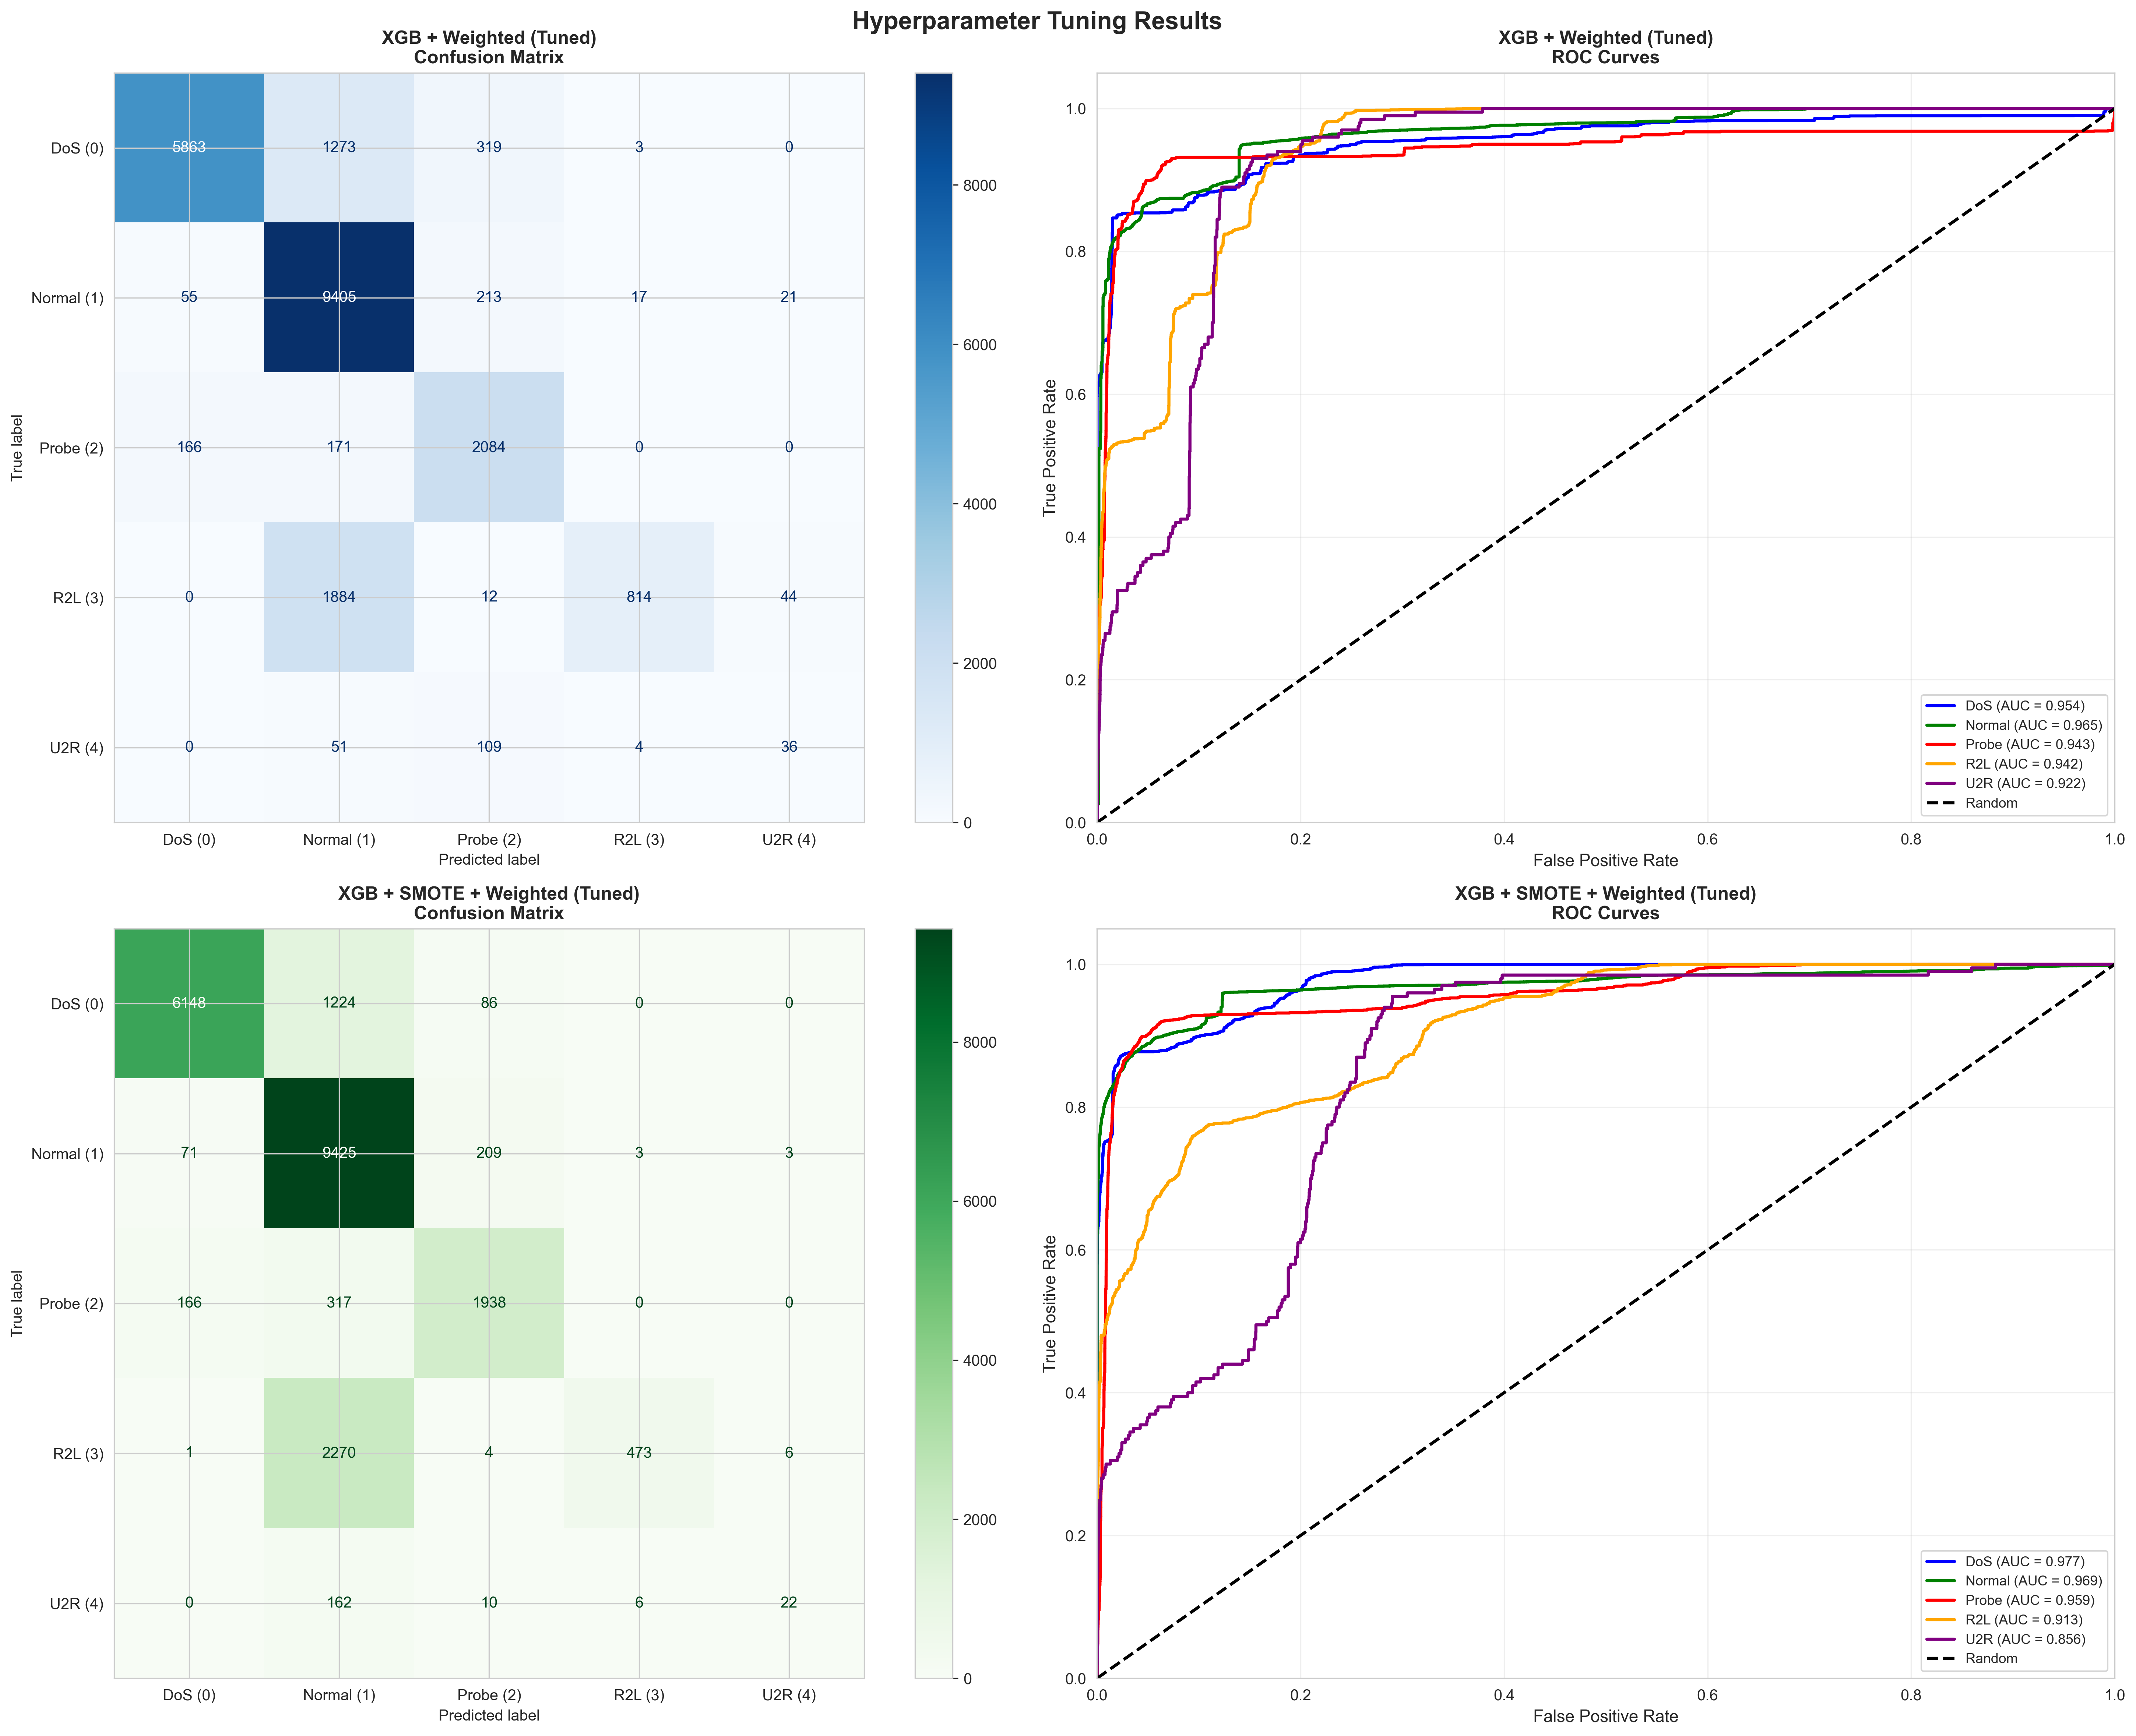

In [71]:
# ============================================================
# FULL COMPARISON INCLUDING TUNED MODELS
# ============================================================

# Combine all results (same as your previous cell)
all_results = pd.concat([
    pd.DataFrame(model_results),
    pd.DataFrame(model_results_smote)
], ignore_index=True)

print("=" * 110)
print("PRE-TUNING vs POST-TUNING COMPARISON")
print("=" * 110)

for base_name, tuned_name in [('XGB + Weighted', 'XGB + Weighted (Tuned)'),
                                ('XGB + SMOTE + Weighted', 'XGB + SMOTE + Weighted (Tuned)')]:
    base_row = all_results[all_results['model_name'] == base_name].iloc[0]
    tuned_row = all_results[all_results['model_name'] == tuned_name].iloc[0]
    
    print(f"\n   {base_name} → Tuned:")
    for metric in ['macro_avg_recall', 'macro_avg_f1', 'roc_auc_macro', 'accuracy',
                    'R2L_recall', 'U2R_recall', 'Probe_recall', 'DoS_recall']:
        old = base_row[metric]
        new = tuned_row[metric]
        diff = new - old
        arrow = "↑" if diff > 0.001 else "↓" if diff < -0.001 else "→"
        print(f"      {metric:<20s}: {old:.4f} → {new:.4f} ({arrow} {abs(diff):.4f})")

# Per-class ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

print("\n\n" + "=" * 110)
print("PER-CLASS ROC-AUC: TUNED MODELS")
print("=" * 110)
print(f"\n{'Class':<10} {'XGB+W (Tuned)':<20} {'XGB+SW (Tuned)':<20}")
print("-" * 50)
for i, cls in enumerate(classes):
    auc_w = roc_auc_score(y_test_bin[:, i], y_pred_proba_xgb_w_tuned[:, i])
    auc_sw = roc_auc_score(y_test_bin[:, i], y_pred_proba_xgb_sw_tuned[:, i])
    print(f"{cls:<10} {auc_w:<20.4f} {auc_sw:<20.4f}")

# Full table with all 17 models
print("\n\n" + "=" * 110)
print("FULL COMPARISON: ALL STRATEGIES INCLUDING TUNED")
print("=" * 110)

print("\n📊 OVERALL METRICS:")
print("-" * 120)
print(all_results[['model_name', 'macro_avg_recall', 'macro_avg_f1',
                    'roc_auc_macro', 'accuracy']].to_string(index=False))

print("\n\n⚠️  MINORITY CLASS RECALL:")
print("-" * 120)
print(all_results[['model_name', 'R2L_recall', 'U2R_recall',
                    'Probe_recall', 'DoS_recall']].to_string(index=False))

# Best model by metric (updated)
print("\n\n" + "=" * 110)
print("🏆 BEST MODEL BY METRIC (FINAL - INCLUDING TUNED)")
print("=" * 110)

metrics_of_interest = {
    'macro_avg_recall': 'Best Overall Minority Detection',
    'macro_avg_f1': 'Best Overall Balance (F1)',
    'U2R_recall': 'Best U2R Detection',
    'R2L_recall': 'Best R2L Detection',
    'roc_auc_macro': 'Best Discrimination (AUC)',
    'accuracy': 'Best Raw Accuracy'
}

for metric, description in metrics_of_interest.items():
    best_idx = all_results[metric].idxmax()
    best = all_results.loc[best_idx]
    print(f"   {description:<45s} → {best['model_name']} ({metric} = {best[metric]:.4f})")

# Show visualizations
from IPython.display import Image, display
try:
    display(Image('hyperparameter_tuning_results.png'))
except:
    print("\n⚠️  Image not found")

TOP 20 FEATURES: XGB + Weighted (Tuned)
                    Feature  Importance
                    flag_S0    0.190446
                 root_shell    0.107345
            service_encoded    0.057882
         srv_diff_host_rate    0.057746
       dst_host_serror_rate    0.043551
          protocol_type_tcp    0.042873
                   duration    0.040823
                      count    0.038758
                  src_bytes    0.033000
                  dst_bytes    0.032996
         num_file_creations    0.031696
         dst_host_srv_count    0.029196
          num_failed_logins    0.026778
     dst_host_diff_srv_rate    0.024037
                  logged_in    0.022712
             is_guest_login    0.022122
dst_host_srv_diff_host_rate    0.015757
                  flag_RSTO    0.015509
                    flag_SF    0.012967
dst_host_same_src_port_rate    0.012107


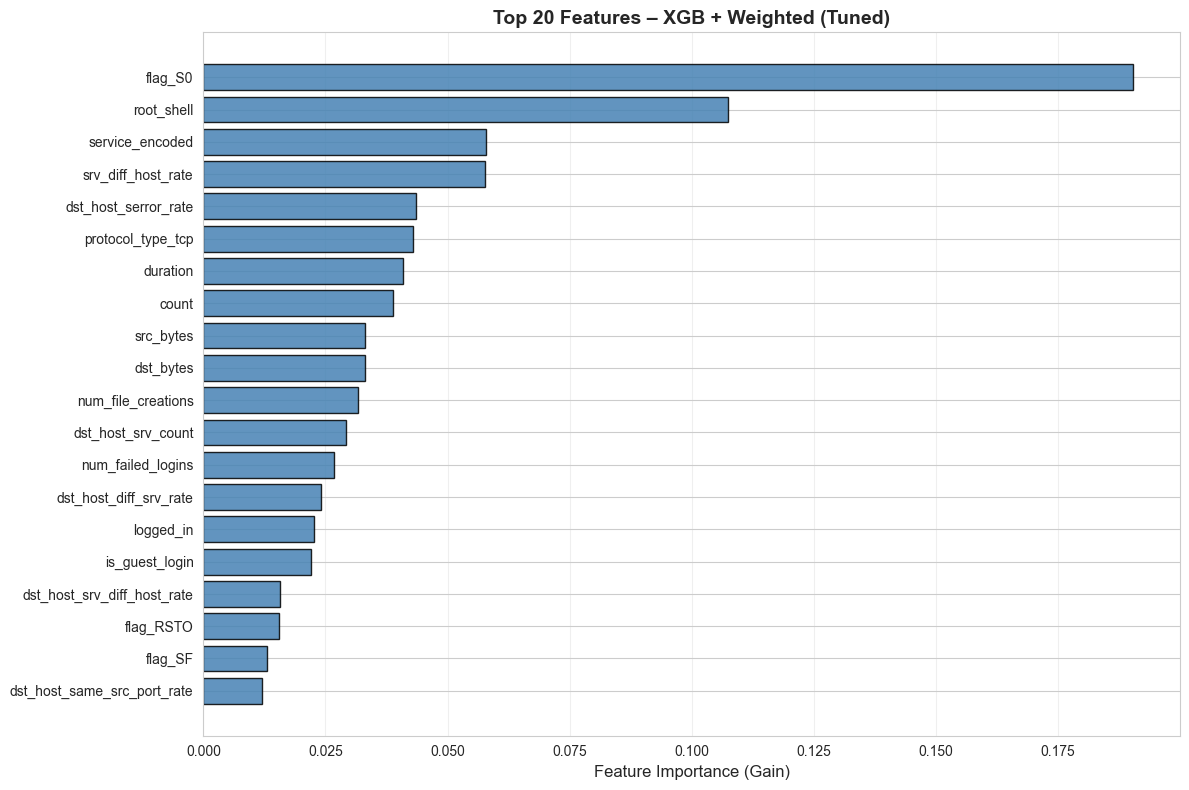


📊 SUMMARY:
   Total features: 47
   Top 5 account for: 45.7% of total importance
   Top 10 account for: 64.5% of total importance
   Features with zero importance: 1


In [72]:
# ============================================================
# FEATURE IMPORTANCE: XGB + Weighted (Tuned)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
importances = best_xgb_weighted.feature_importances_
feature_names = X_train.columns

# Create sorted DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("TOP 20 FEATURES: XGB + Weighted (Tuned)")
print("=" * 80)
print(feat_imp.head(20).to_string(index=False))

# Plot top 20
fig, ax = plt.subplots(figsize=(12, 8))
top20 = feat_imp.head(20)
ax.barh(range(len(top20)), top20['Importance'].values, color='steelblue', edgecolor='black', alpha=0.85)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['Feature'].values, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (Gain)', fontsize=12)
ax.set_title('Top 20 Features \u2013 XGB + Weighted (Tuned)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary stats
print(f"\n📊 SUMMARY:")
print(f"   Total features: {len(feat_imp)}")
print(f"   Top 5 account for: {feat_imp.head(5)['Importance'].sum()*100:.1f}% of total importance")
print(f"   Top 10 account for: {feat_imp.head(10)['Importance'].sum()*100:.1f}% of total importance")
print(f"   Features with zero importance: {(feat_imp['Importance'] == 0).sum()}")

---

# 📚 References

1. NSL-KDD Dataset: https://www.unb.ca/cic/datasets/nsl.html
2. Tavallaee, M., Bagheri, E., Lu, W., & Ghorbani, A. A. (2009). A detailed analysis of the KDD CUP 99 data set. IEEE Symposium on Computational Intelligence for Security and Defense Applications.
3. [Additional references to be added]